# Neural Machine Translation

Welcome to your first programming assignment for this week! 

You will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). You will do this using an attention model, one of the most sophisticated sequence to sequence models. 

This notebook was produced together with NVIDIA's Deep Learning Institute. 

Let's load all the packages you will need for this assignment.

In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, LSTM, Multiply
from tensorflow.keras import Input
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1 - Translating human readable dates into machine readable dates

The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give you a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task. 

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

### 1.1 - Dataset

We will train the model on a dataset of 10000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5496.13it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

You've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


You now have:
- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


Lets also look at some examples of preprocessed training examples. Feel free to play with `index` in the cell below to navigate the dataset and see how source/target dates are preprocessed. 

In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 2 - Neural machine translation with attention

If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


### 2.1 - Attention mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. Here is a figure to remind you how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>



Here are some properties of the model that you may notice: 

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date. 

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM. 

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

Lets implement this model. You will start by implementing two functions: `one_step_attention()` and `model()`.

**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector (see Figure  1 (right) for details):
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

Note that we are denoting the attention in this notebook $context^{\langle t \rangle}$. In the lecture videos, the context was denoted $c^{\langle t \rangle}$, but here we are calling it $context^{\langle t \rangle}$ to avoid confusion with the (post-attention) LSTM's internal memory cell variable, which is sometimes also denoted $c^{\langle t \rangle}$. 
  
**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$. 



**Exercise**: Implement `one_step_attention()`. The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop, and it is important that all $T_y$ copies have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras:
1. Define the layer objects (as global variables for examples).
2. Call these objects when propagating the input.

We have defined the layers you need as global variables. Please run the following cells to create them. Please check the Keras documentation to make sure you understand what these layers are: [RepeatVector()](https://keras.io/layers/core/#repeatvector), [Concatenate()](https://keras.io/layers/merge/#concatenate), [Dense()](https://keras.io/layers/core/#dense), [Activation()](https://keras.io/layers/core/#activation), [Dot()](https://keras.io/layers/merge/#dot).

In [6]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [7]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor to propagate concat through a small fully-connected neural network to compute the "energies" variable e. (≈1 lines)
    e = densor(concat)
    # Use activator and e to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(e)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

You will be able to check the expected output of `one_step_attention()` after you've coded the `model()` function.

**Exercise**: Implement `model()` as explained in figure 2 and the text above. Again, we have defined global layers that will share weights to be used in `model()`.

In [8]:
n_a = 64
n_s = 128
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps: 

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$: 
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output. 
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [9]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model.

In [10]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

Let's get a summary of the model to check if it matches the expected output.

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 128)]        0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 128)      52224       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 128)      0           s0[0][0]                         
                                                                 lstm[0][0]                   

                                                                 bidirectional[0][0]              
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 131584      dot[0][0]                        
                                                                 s0[0][0]                         
                                                                 c0[0][0]                         
                                                                 dot[1][0]                        
                                                                 lstm[0][0]                       
                                                                 lstm[0][2]                       
          

**Expected Output**:

Here is the summary you should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         185,484
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         185,484
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 128)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 128)  
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 256) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 128) 
        </td>
    </tr>
           <tr>
        <td>
            **dense_2's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)  and `['accuracy']` metrics:

In [12]:
### START CODE HERE ### (≈2 lines)
out = model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01),
                    metrics=['accuracy'],
                    loss='categorical_crossentropy')
out
### END CODE HERE ###

The last step is to define all your inputs and outputs to fit the model:
- You already have X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_activation_LSTM_cell` with 0s.
- Given the `model()` you coded, you need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [13]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [40]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Train on 10000 samples
Epoch 1/10


 1500/10000 [===>..........................] - ETA: 2:27:08 - loss: 120.4697 - dense_1_loss: 0.6231 - dense_1_1_loss: 10.3945 - dense_1_2_loss: 11.4401 - dense_1_3_loss: 13.2887 - dense_1_4_loss: 24.1541 - dense_1_5_loss: 7.9286 - dense_1_6_loss: 11.4671 - dense_1_7_loss: 24.1542 - dense_1_8_loss: 4.0704 - dense_1_9_loss: 12.9488 - dense_1_accuracy: 0.7000 - dense_1_1_accuracy: 0.0000e+00 - dense_1_2_accuracy: 0.0500 - dense_1_3_accuracy: 0.0800 - dense_1_4_accuracy: 0.0000e+00 - dense_1_5_accuracy: 0.0600 - dense_1_6_accuracy: 0.1200 - dense_1_7_accuracy: 0.0000e+00 - dense_1_8_accuracy: 0.3500 - dense_1_9_accuracy: 0.060 - ETA: 1:13:25 - loss: 112.7437 - dense_1_loss: 0.6274 - dense_1_1_loss: 9.7655 - dense_1_2_loss: 10.9922 - dense_1_3_loss: 12.4743 - dense_1_4_loss: 23.0611 - dense_1_5_loss: 6.8203 - dense_1_6_loss: 9.7728 - dense_1_7_loss: 23.0654 - dense_1_8_loss: 3.7945 - dense_1_9_loss: 12.3701 - dense_1_accuracy: 0.7200 - dense_1_1_accuracy: 0.0000e+00 - dense_1_2_accuracy: 0.

 6000/10000 [=================>............] - ETA: 2:20 - loss: 33.1500 - dense_1_loss: 1.5043 - dense_1_1_loss: 2.5809 - dense_1_2_loss: 3.2599 - dense_1_3_loss: 4.2365 - dense_1_4_loss: 4.7042 - dense_1_5_loss: 2.0405 - dense_1_6_loss: 3.8006 - dense_1_7_loss: 4.7027 - dense_1_8_loss: 2.2049 - dense_1_9_loss: 4.1155 - dense_1_accuracy: 0.5791 - dense_1_1_accuracy: 0.1687 - dense_1_2_accuracy: 0.1304 - dense_1_3_accuracy: 0.0807 - dense_1_4_accuracy: 0.4198 - dense_1_5_accuracy: 0.2317 - dense_1_6_accuracy: 0.0859 - dense_1_7_accuracy: 0.4289 - dense_1_8_accuracy: 0.1759 - dense_1_9_accuracy: 0.07 - ETA: 2:15 - loss: 32.8857 - dense_1_loss: 1.5041 - dense_1_1_loss: 2.5631 - dense_1_2_loss: 3.2369 - dense_1_3_loss: 4.2069 - dense_1_4_loss: 4.6378 - dense_1_5_loss: 2.0316 - dense_1_6_loss: 3.7793 - dense_1_7_loss: 4.6356 - dense_1_8_loss: 2.2018 - dense_1_9_loss: 4.0885 - dense_1_accuracy: 0.5804 - dense_1_1_accuracy: 0.1704 - dense_1_2_accuracy: 0.1321 - dense_1_3_accuracy: 0.0811 - d

 7500/10000 [=====================>........] - ETA: 1:22 - loss: 29.9924 - dense_1_loss: 1.4522 - dense_1_1_loss: 2.3677 - dense_1_2_loss: 2.9953 - dense_1_3_loss: 3.8712 - dense_1_4_loss: 3.9349 - dense_1_5_loss: 1.9472 - dense_1_6_loss: 3.5378 - dense_1_7_loss: 3.9278 - dense_1_8_loss: 2.1686 - dense_1_9_loss: 3.7898 - dense_1_accuracy: 0.6239 - dense_1_1_accuracy: 0.1998 - dense_1_2_accuracy: 0.1461 - dense_1_3_accuracy: 0.0779 - dense_1_4_accuracy: 0.4516 - dense_1_5_accuracy: 0.2475 - dense_1_6_accuracy: 0.0769 - dense_1_7_accuracy: 0.4649 - dense_1_8_accuracy: 0.1680 - dense_1_9_accuracy: 0.07 - ETA: 1:19 - loss: 29.8334 - dense_1_loss: 1.4480 - dense_1_1_loss: 2.3589 - dense_1_2_loss: 2.9825 - dense_1_3_loss: 3.8532 - dense_1_4_loss: 3.8954 - dense_1_5_loss: 1.9441 - dense_1_6_loss: 3.5217 - dense_1_7_loss: 3.8882 - dense_1_8_loss: 2.1680 - dense_1_9_loss: 3.7734 - dense_1_accuracy: 0.6258 - dense_1_1_accuracy: 0.1995 - dense_1_2_accuracy: 0.1466 - dense_1_3_accuracy: 0.0774 - d

 9000/10000 [==========================>...] - ETA: 43s - loss: 28.0079 - dense_1_loss: 1.3917 - dense_1_1_loss: 2.2278 - dense_1_2_loss: 2.8308 - dense_1_3_loss: 3.6522 - dense_1_4_loss: 3.4711 - dense_1_5_loss: 1.8839 - dense_1_6_loss: 3.3590 - dense_1_7_loss: 3.4589 - dense_1_8_loss: 2.1453 - dense_1_9_loss: 3.5873 - dense_1_accuracy: 0.6497 - dense_1_1_accuracy: 0.2234 - dense_1_2_accuracy: 0.1575 - dense_1_3_accuracy: 0.0767 - dense_1_4_accuracy: 0.4593 - dense_1_5_accuracy: 0.2684 - dense_1_6_accuracy: 0.0778 - dense_1_7_accuracy: 0.4778 - dense_1_8_accuracy: 0.1699 - dense_1_9_accuracy: 0.070 - ETA: 41s - loss: 27.9010 - dense_1_loss: 1.3888 - dense_1_1_loss: 2.2196 - dense_1_2_loss: 2.8208 - dense_1_3_loss: 3.6399 - dense_1_4_loss: 3.4470 - dense_1_5_loss: 1.8802 - dense_1_6_loss: 3.3495 - dense_1_7_loss: 3.4344 - dense_1_8_loss: 2.1458 - dense_1_9_loss: 3.5748 - dense_1_accuracy: 0.6488 - dense_1_1_accuracy: 0.2248 - dense_1_2_accuracy: 0.1584 - dense_1_3_accuracy: 0.0770 - de

10000/10000 [==============================] - ETA: 14s - loss: 26.6586 - dense_1_loss: 1.3417 - dense_1_1_loss: 2.1306 - dense_1_2_loss: 2.7211 - dense_1_3_loss: 3.4941 - dense_1_4_loss: 3.1561 - dense_1_5_loss: 1.8472 - dense_1_6_loss: 3.2427 - dense_1_7_loss: 3.1398 - dense_1_8_loss: 2.1355 - dense_1_9_loss: 3.4499 - dense_1_accuracy: 0.6640 - dense_1_1_accuracy: 0.2447 - dense_1_2_accuracy: 0.1658 - dense_1_3_accuracy: 0.0785 - dense_1_4_accuracy: 0.4662 - dense_1_5_accuracy: 0.2842 - dense_1_6_accuracy: 0.0751 - dense_1_7_accuracy: 0.4896 - dense_1_8_accuracy: 0.1655 - dense_1_9_accuracy: 0.069 - ETA: 12s - loss: 26.5819 - dense_1_loss: 1.3387 - dense_1_1_loss: 2.1243 - dense_1_2_loss: 2.7155 - dense_1_3_loss: 3.4841 - dense_1_4_loss: 3.1386 - dense_1_5_loss: 1.8445 - dense_1_6_loss: 3.2362 - dense_1_7_loss: 3.1220 - dense_1_8_loss: 2.1346 - dense_1_9_loss: 3.4432 - dense_1_accuracy: 0.6654 - dense_1_1_accuracy: 0.2473 - dense_1_2_accuracy: 0.1660 - dense_1_3_accuracy: 0.0789 - de

 1500/10000 [===>..........................] - ETA: 48s - loss: 19.5987 - dense_1_loss: 0.9632 - dense_1_1_loss: 1.5262 - dense_1_2_loss: 2.2560 - dense_1_3_loss: 2.6290 - dense_1_4_loss: 1.5610 - dense_1_5_loss: 1.6164 - dense_1_6_loss: 2.7207 - dense_1_7_loss: 1.5107 - dense_1_8_loss: 2.0008 - dense_1_9_loss: 2.8148 - dense_1_accuracy: 0.9100 - dense_1_1_accuracy: 0.4400 - dense_1_2_accuracy: 0.1800 - dense_1_3_accuracy: 0.1000 - dense_1_4_accuracy: 0.4900 - dense_1_5_accuracy: 0.4100 - dense_1_6_accuracy: 0.0800 - dense_1_7_accuracy: 0.5300 - dense_1_8_accuracy: 0.1700 - dense_1_9_accuracy: 0.080 - ETA: 47s - loss: 19.7266 - dense_1_loss: 0.9923 - dense_1_1_loss: 1.5455 - dense_1_2_loss: 2.2675 - dense_1_3_loss: 2.6436 - dense_1_4_loss: 1.5635 - dense_1_5_loss: 1.6307 - dense_1_6_loss: 2.7013 - dense_1_7_loss: 1.5171 - dense_1_8_loss: 2.0606 - dense_1_9_loss: 2.8045 - dense_1_accuracy: 0.8600 - dense_1_1_accuracy: 0.4300 - dense_1_2_accuracy: 0.1750 - dense_1_3_accuracy: 0.0850 - de

 6000/10000 [=================>............] - ETA: 26s - loss: 19.3895 - dense_1_loss: 0.9881 - dense_1_1_loss: 1.5277 - dense_1_2_loss: 2.1049 - dense_1_3_loss: 2.6688 - dense_1_4_loss: 1.5398 - dense_1_5_loss: 1.6403 - dense_1_6_loss: 2.6345 - dense_1_7_loss: 1.4895 - dense_1_8_loss: 2.0756 - dense_1_9_loss: 2.7203 - dense_1_accuracy: 0.8309 - dense_1_1_accuracy: 0.5159 - dense_1_2_accuracy: 0.2393 - dense_1_3_accuracy: 0.0848 - dense_1_4_accuracy: 0.4859 - dense_1_5_accuracy: 0.3787 - dense_1_6_accuracy: 0.0811 - dense_1_7_accuracy: 0.5439 - dense_1_8_accuracy: 0.1600 - dense_1_9_accuracy: 0.071 - ETA: 26s - loss: 19.3795 - dense_1_loss: 0.9884 - dense_1_1_loss: 1.5288 - dense_1_2_loss: 2.1030 - dense_1_3_loss: 2.6676 - dense_1_4_loss: 1.5394 - dense_1_5_loss: 1.6401 - dense_1_6_loss: 2.6335 - dense_1_7_loss: 1.4889 - dense_1_8_loss: 2.0720 - dense_1_9_loss: 2.7177 - dense_1_accuracy: 0.8298 - dense_1_1_accuracy: 0.5147 - dense_1_2_accuracy: 0.2409 - dense_1_3_accuracy: 0.0860 - de

 7500/10000 [=====================>........] - ETA: 19s - loss: 19.3262 - dense_1_loss: 0.9805 - dense_1_1_loss: 1.5218 - dense_1_2_loss: 2.1028 - dense_1_3_loss: 2.6575 - dense_1_4_loss: 1.5351 - dense_1_5_loss: 1.6438 - dense_1_6_loss: 2.6246 - dense_1_7_loss: 1.4829 - dense_1_8_loss: 2.0652 - dense_1_9_loss: 2.7119 - dense_1_accuracy: 0.8369 - dense_1_1_accuracy: 0.5267 - dense_1_2_accuracy: 0.2420 - dense_1_3_accuracy: 0.0913 - dense_1_4_accuracy: 0.4821 - dense_1_5_accuracy: 0.3766 - dense_1_6_accuracy: 0.0833 - dense_1_7_accuracy: 0.5444 - dense_1_8_accuracy: 0.1615 - dense_1_9_accuracy: 0.069 - ETA: 18s - loss: 19.3238 - dense_1_loss: 0.9803 - dense_1_1_loss: 1.5201 - dense_1_2_loss: 2.1013 - dense_1_3_loss: 2.6584 - dense_1_4_loss: 1.5339 - dense_1_5_loss: 1.6456 - dense_1_6_loss: 2.6249 - dense_1_7_loss: 1.4818 - dense_1_8_loss: 2.0661 - dense_1_9_loss: 2.7113 - dense_1_accuracy: 0.8365 - dense_1_1_accuracy: 0.5298 - dense_1_2_accuracy: 0.2415 - dense_1_3_accuracy: 0.0911 - de

 9000/10000 [==========================>...] - ETA: 11s - loss: 19.2563 - dense_1_loss: 0.9676 - dense_1_1_loss: 1.5104 - dense_1_2_loss: 2.1009 - dense_1_3_loss: 2.6479 - dense_1_4_loss: 1.5298 - dense_1_5_loss: 1.6475 - dense_1_6_loss: 2.6143 - dense_1_7_loss: 1.4769 - dense_1_8_loss: 2.0647 - dense_1_9_loss: 2.6964 - dense_1_accuracy: 0.8387 - dense_1_1_accuracy: 0.5362 - dense_1_2_accuracy: 0.2422 - dense_1_3_accuracy: 0.0936 - dense_1_4_accuracy: 0.4863 - dense_1_5_accuracy: 0.3711 - dense_1_6_accuracy: 0.0864 - dense_1_7_accuracy: 0.5507 - dense_1_8_accuracy: 0.1604 - dense_1_9_accuracy: 0.070 - ETA: 11s - loss: 19.2514 - dense_1_loss: 0.9668 - dense_1_1_loss: 1.5094 - dense_1_2_loss: 2.1002 - dense_1_3_loss: 2.6467 - dense_1_4_loss: 1.5287 - dense_1_5_loss: 1.6474 - dense_1_6_loss: 2.6148 - dense_1_7_loss: 1.4758 - dense_1_8_loss: 2.0648 - dense_1_9_loss: 2.6969 - dense_1_accuracy: 0.8390 - dense_1_1_accuracy: 0.5377 - dense_1_2_accuracy: 0.2421 - dense_1_3_accuracy: 0.0940 - de

10000/10000 [==============================] - ETA: 4s - loss: 19.1840 - dense_1_loss: 0.9532 - dense_1_1_loss: 1.4984 - dense_1_2_loss: 2.0993 - dense_1_3_loss: 2.6377 - dense_1_4_loss: 1.5280 - dense_1_5_loss: 1.6416 - dense_1_6_loss: 2.6011 - dense_1_7_loss: 1.4741 - dense_1_8_loss: 2.0605 - dense_1_9_loss: 2.6900 - dense_1_accuracy: 0.8354 - dense_1_1_accuracy: 0.5479 - dense_1_2_accuracy: 0.2423 - dense_1_3_accuracy: 0.0971 - dense_1_4_accuracy: 0.4837 - dense_1_5_accuracy: 0.3769 - dense_1_6_accuracy: 0.0902 - dense_1_7_accuracy: 0.5498 - dense_1_8_accuracy: 0.1624 - dense_1_9_accuracy: 0.07 - ETA: 3s - loss: 19.1790 - dense_1_loss: 0.9525 - dense_1_1_loss: 1.4967 - dense_1_2_loss: 2.0981 - dense_1_3_loss: 2.6369 - dense_1_4_loss: 1.5272 - dense_1_5_loss: 1.6420 - dense_1_6_loss: 2.6012 - dense_1_7_loss: 1.4734 - dense_1_8_loss: 2.0607 - dense_1_9_loss: 2.6905 - dense_1_accuracy: 0.8343 - dense_1_1_accuracy: 0.5495 - dense_1_2_accuracy: 0.2426 - dense_1_3_accuracy: 0.0978 - dense

 1500/10000 [===>..........................] - ETA: 47s - loss: 18.4796 - dense_1_loss: 0.8048 - dense_1_1_loss: 1.3451 - dense_1_2_loss: 2.0339 - dense_1_3_loss: 2.6167 - dense_1_4_loss: 1.4864 - dense_1_5_loss: 1.7138 - dense_1_6_loss: 2.4895 - dense_1_7_loss: 1.4176 - dense_1_8_loss: 1.9984 - dense_1_9_loss: 2.5735 - dense_1_accuracy: 0.8300 - dense_1_1_accuracy: 0.7300 - dense_1_2_accuracy: 0.3200 - dense_1_3_accuracy: 0.1000 - dense_1_4_accuracy: 0.5200 - dense_1_5_accuracy: 0.2800 - dense_1_6_accuracy: 0.1000 - dense_1_7_accuracy: 0.6400 - dense_1_8_accuracy: 0.1300 - dense_1_9_accuracy: 0.080 - ETA: 49s - loss: 18.6065 - dense_1_loss: 0.8013 - dense_1_1_loss: 1.3170 - dense_1_2_loss: 2.0472 - dense_1_3_loss: 2.5472 - dense_1_4_loss: 1.4847 - dense_1_5_loss: 1.7278 - dense_1_6_loss: 2.5680 - dense_1_7_loss: 1.4156 - dense_1_8_loss: 2.0533 - dense_1_9_loss: 2.6443 - dense_1_accuracy: 0.8400 - dense_1_1_accuracy: 0.7450 - dense_1_2_accuracy: 0.3200 - dense_1_3_accuracy: 0.1200 - de

 6000/10000 [=================>............] - ETA: 26s - loss: 18.4426 - dense_1_loss: 0.8142 - dense_1_1_loss: 1.2762 - dense_1_2_loss: 2.0421 - dense_1_3_loss: 2.5608 - dense_1_4_loss: 1.4941 - dense_1_5_loss: 1.6263 - dense_1_6_loss: 2.5436 - dense_1_7_loss: 1.4295 - dense_1_8_loss: 2.0399 - dense_1_9_loss: 2.6156 - dense_1_accuracy: 0.8022 - dense_1_1_accuracy: 0.7470 - dense_1_2_accuracy: 0.2804 - dense_1_3_accuracy: 0.1183 - dense_1_4_accuracy: 0.4972 - dense_1_5_accuracy: 0.3559 - dense_1_6_accuracy: 0.0898 - dense_1_7_accuracy: 0.5885 - dense_1_8_accuracy: 0.1557 - dense_1_9_accuracy: 0.086 - ETA: 26s - loss: 18.4423 - dense_1_loss: 0.8145 - dense_1_1_loss: 1.2744 - dense_1_2_loss: 2.0415 - dense_1_3_loss: 2.5635 - dense_1_4_loss: 1.4959 - dense_1_5_loss: 1.6253 - dense_1_6_loss: 2.5423 - dense_1_7_loss: 1.4310 - dense_1_8_loss: 2.0379 - dense_1_9_loss: 2.6159 - dense_1_accuracy: 0.8006 - dense_1_1_accuracy: 0.7481 - dense_1_2_accuracy: 0.2819 - dense_1_3_accuracy: 0.1181 - de

 7500/10000 [=====================>........] - ETA: 19s - loss: 18.3796 - dense_1_loss: 0.8110 - dense_1_1_loss: 1.2529 - dense_1_2_loss: 2.0263 - dense_1_3_loss: 2.5605 - dense_1_4_loss: 1.4964 - dense_1_5_loss: 1.6174 - dense_1_6_loss: 2.5380 - dense_1_7_loss: 1.4307 - dense_1_8_loss: 2.0312 - dense_1_9_loss: 2.6151 - dense_1_accuracy: 0.8023 - dense_1_1_accuracy: 0.7554 - dense_1_2_accuracy: 0.2893 - dense_1_3_accuracy: 0.1205 - dense_1_4_accuracy: 0.4869 - dense_1_5_accuracy: 0.3633 - dense_1_6_accuracy: 0.0923 - dense_1_7_accuracy: 0.5790 - dense_1_8_accuracy: 0.1580 - dense_1_9_accuracy: 0.085 - ETA: 18s - loss: 18.3754 - dense_1_loss: 0.8100 - dense_1_1_loss: 1.2507 - dense_1_2_loss: 2.0285 - dense_1_3_loss: 2.5589 - dense_1_4_loss: 1.4952 - dense_1_5_loss: 1.6174 - dense_1_6_loss: 2.5398 - dense_1_7_loss: 1.4298 - dense_1_8_loss: 2.0303 - dense_1_9_loss: 2.6149 - dense_1_accuracy: 0.8034 - dense_1_1_accuracy: 0.7573 - dense_1_2_accuracy: 0.2871 - dense_1_3_accuracy: 0.1208 - de

 9000/10000 [==========================>...] - ETA: 12s - loss: 18.3122 - dense_1_loss: 0.8069 - dense_1_1_loss: 1.2249 - dense_1_2_loss: 2.0150 - dense_1_3_loss: 2.5552 - dense_1_4_loss: 1.4945 - dense_1_5_loss: 1.6142 - dense_1_6_loss: 2.5339 - dense_1_7_loss: 1.4279 - dense_1_8_loss: 2.0291 - dense_1_9_loss: 2.6107 - dense_1_accuracy: 0.8057 - dense_1_1_accuracy: 0.7678 - dense_1_2_accuracy: 0.2953 - dense_1_3_accuracy: 0.1209 - dense_1_4_accuracy: 0.4905 - dense_1_5_accuracy: 0.3634 - dense_1_6_accuracy: 0.0907 - dense_1_7_accuracy: 0.5818 - dense_1_8_accuracy: 0.1607 - dense_1_9_accuracy: 0.086 - ETA: 11s - loss: 18.3079 - dense_1_loss: 0.8065 - dense_1_1_loss: 1.2248 - dense_1_2_loss: 2.0172 - dense_1_3_loss: 2.5549 - dense_1_4_loss: 1.4937 - dense_1_5_loss: 1.6128 - dense_1_6_loss: 2.5334 - dense_1_7_loss: 1.4275 - dense_1_8_loss: 2.0266 - dense_1_9_loss: 2.6106 - dense_1_accuracy: 0.8069 - dense_1_1_accuracy: 0.7678 - dense_1_2_accuracy: 0.2945 - dense_1_3_accuracy: 0.1206 - de

10000/10000 [==============================] - ETA: 4s - loss: 18.2398 - dense_1_loss: 0.8062 - dense_1_1_loss: 1.2047 - dense_1_2_loss: 2.0036 - dense_1_3_loss: 2.5442 - dense_1_4_loss: 1.4901 - dense_1_5_loss: 1.6080 - dense_1_6_loss: 2.5286 - dense_1_7_loss: 1.4234 - dense_1_8_loss: 2.0244 - dense_1_9_loss: 2.6067 - dense_1_accuracy: 0.8076 - dense_1_1_accuracy: 0.7782 - dense_1_2_accuracy: 0.2996 - dense_1_3_accuracy: 0.1211 - dense_1_4_accuracy: 0.4905 - dense_1_5_accuracy: 0.3653 - dense_1_6_accuracy: 0.0888 - dense_1_7_accuracy: 0.5827 - dense_1_8_accuracy: 0.1602 - dense_1_9_accuracy: 0.08 - ETA: 4s - loss: 18.2349 - dense_1_loss: 0.8061 - dense_1_1_loss: 1.2033 - dense_1_2_loss: 2.0027 - dense_1_3_loss: 2.5459 - dense_1_4_loss: 1.4900 - dense_1_5_loss: 1.6074 - dense_1_6_loss: 2.5279 - dense_1_7_loss: 1.4232 - dense_1_8_loss: 2.0240 - dense_1_9_loss: 2.6043 - dense_1_accuracy: 0.8083 - dense_1_1_accuracy: 0.7792 - dense_1_2_accuracy: 0.2997 - dense_1_3_accuracy: 0.1210 - dense

 1500/10000 [===>..........................] - ETA: 57s - loss: 17.6033 - dense_1_loss: 0.7677 - dense_1_1_loss: 1.0081 - dense_1_2_loss: 1.9368 - dense_1_3_loss: 2.5275 - dense_1_4_loss: 1.4231 - dense_1_5_loss: 1.6097 - dense_1_6_loss: 2.3888 - dense_1_7_loss: 1.3665 - dense_1_8_loss: 1.9413 - dense_1_9_loss: 2.6337 - dense_1_accuracy: 0.9000 - dense_1_1_accuracy: 0.9100 - dense_1_2_accuracy: 0.3300 - dense_1_3_accuracy: 0.1000 - dense_1_4_accuracy: 0.5700 - dense_1_5_accuracy: 0.2800 - dense_1_6_accuracy: 0.0800 - dense_1_7_accuracy: 0.6800 - dense_1_8_accuracy: 0.1500 - dense_1_9_accuracy: 0.060 - ETA: 57s - loss: 17.7630 - dense_1_loss: 0.7642 - dense_1_1_loss: 0.9673 - dense_1_2_loss: 1.8916 - dense_1_3_loss: 2.5595 - dense_1_4_loss: 1.4286 - dense_1_5_loss: 1.5969 - dense_1_6_loss: 2.5002 - dense_1_7_loss: 1.3772 - dense_1_8_loss: 2.0700 - dense_1_9_loss: 2.6074 - dense_1_accuracy: 0.9050 - dense_1_1_accuracy: 0.9350 - dense_1_2_accuracy: 0.3450 - dense_1_3_accuracy: 0.0950 - de

 6000/10000 [=================>............] - ETA: 26s - loss: 17.6532 - dense_1_loss: 0.7502 - dense_1_1_loss: 0.9753 - dense_1_2_loss: 1.9053 - dense_1_3_loss: 2.5102 - dense_1_4_loss: 1.4603 - dense_1_5_loss: 1.5920 - dense_1_6_loss: 2.4904 - dense_1_7_loss: 1.3915 - dense_1_8_loss: 1.9877 - dense_1_9_loss: 2.5902 - dense_1_accuracy: 0.8596 - dense_1_1_accuracy: 0.8774 - dense_1_2_accuracy: 0.3387 - dense_1_3_accuracy: 0.1180 - dense_1_4_accuracy: 0.5259 - dense_1_5_accuracy: 0.3535 - dense_1_6_accuracy: 0.0820 - dense_1_7_accuracy: 0.6107 - dense_1_8_accuracy: 0.1567 - dense_1_9_accuracy: 0.084 - ETA: 26s - loss: 17.6529 - dense_1_loss: 0.7500 - dense_1_1_loss: 0.9747 - dense_1_2_loss: 1.9052 - dense_1_3_loss: 2.5110 - dense_1_4_loss: 1.4593 - dense_1_5_loss: 1.5925 - dense_1_6_loss: 2.4917 - dense_1_7_loss: 1.3908 - dense_1_8_loss: 1.9864 - dense_1_9_loss: 2.5912 - dense_1_accuracy: 0.8602 - dense_1_1_accuracy: 0.8772 - dense_1_2_accuracy: 0.3394 - dense_1_3_accuracy: 0.1172 - de

 7500/10000 [=====================>........] - ETA: 21s - loss: 17.6068 - dense_1_loss: 0.7469 - dense_1_1_loss: 0.9625 - dense_1_2_loss: 1.8954 - dense_1_3_loss: 2.5075 - dense_1_4_loss: 1.4583 - dense_1_5_loss: 1.5919 - dense_1_6_loss: 2.4830 - dense_1_7_loss: 1.3893 - dense_1_8_loss: 1.9824 - dense_1_9_loss: 2.5897 - dense_1_accuracy: 0.8626 - dense_1_1_accuracy: 0.8811 - dense_1_2_accuracy: 0.3403 - dense_1_3_accuracy: 0.1172 - dense_1_4_accuracy: 0.5287 - dense_1_5_accuracy: 0.3482 - dense_1_6_accuracy: 0.0825 - dense_1_7_accuracy: 0.6175 - dense_1_8_accuracy: 0.1516 - dense_1_9_accuracy: 0.083 - ETA: 20s - loss: 17.5991 - dense_1_loss: 0.7459 - dense_1_1_loss: 0.9608 - dense_1_2_loss: 1.8938 - dense_1_3_loss: 2.5061 - dense_1_4_loss: 1.4585 - dense_1_5_loss: 1.5931 - dense_1_6_loss: 2.4821 - dense_1_7_loss: 1.3894 - dense_1_8_loss: 1.9821 - dense_1_9_loss: 2.5872 - dense_1_accuracy: 0.8637 - dense_1_1_accuracy: 0.8815 - dense_1_2_accuracy: 0.3419 - dense_1_3_accuracy: 0.1176 - de

 9000/10000 [==========================>...] - ETA: 12s - loss: 17.5474 - dense_1_loss: 0.7410 - dense_1_1_loss: 0.9465 - dense_1_2_loss: 1.8842 - dense_1_3_loss: 2.4950 - dense_1_4_loss: 1.4583 - dense_1_5_loss: 1.5935 - dense_1_6_loss: 2.4761 - dense_1_7_loss: 1.3888 - dense_1_8_loss: 1.9779 - dense_1_9_loss: 2.5863 - dense_1_accuracy: 0.8680 - dense_1_1_accuracy: 0.8842 - dense_1_2_accuracy: 0.3462 - dense_1_3_accuracy: 0.1205 - dense_1_4_accuracy: 0.5274 - dense_1_5_accuracy: 0.3457 - dense_1_6_accuracy: 0.0842 - dense_1_7_accuracy: 0.6213 - dense_1_8_accuracy: 0.1533 - dense_1_9_accuracy: 0.080 - ETA: 12s - loss: 17.5428 - dense_1_loss: 0.7402 - dense_1_1_loss: 0.9455 - dense_1_2_loss: 1.8850 - dense_1_3_loss: 2.4954 - dense_1_4_loss: 1.4575 - dense_1_5_loss: 1.5943 - dense_1_6_loss: 2.4740 - dense_1_7_loss: 1.3881 - dense_1_8_loss: 1.9775 - dense_1_9_loss: 2.5854 - dense_1_accuracy: 0.8686 - dense_1_1_accuracy: 0.8843 - dense_1_2_accuracy: 0.3457 - dense_1_3_accuracy: 0.1200 - de

10000/10000 [==============================] - ETA: 5s - loss: 17.5080 - dense_1_loss: 0.7357 - dense_1_1_loss: 0.9321 - dense_1_2_loss: 1.8763 - dense_1_3_loss: 2.4961 - dense_1_4_loss: 1.4548 - dense_1_5_loss: 1.5934 - dense_1_6_loss: 2.4720 - dense_1_7_loss: 1.3856 - dense_1_8_loss: 1.9768 - dense_1_9_loss: 2.5853 - dense_1_accuracy: 0.8704 - dense_1_1_accuracy: 0.8869 - dense_1_2_accuracy: 0.3485 - dense_1_3_accuracy: 0.1197 - dense_1_4_accuracy: 0.5340 - dense_1_5_accuracy: 0.3404 - dense_1_6_accuracy: 0.0830 - dense_1_7_accuracy: 0.6273 - dense_1_8_accuracy: 0.1523 - dense_1_9_accuracy: 0.07 - ETA: 4s - loss: 17.5055 - dense_1_loss: 0.7350 - dense_1_1_loss: 0.9317 - dense_1_2_loss: 1.8775 - dense_1_3_loss: 2.4957 - dense_1_4_loss: 1.4547 - dense_1_5_loss: 1.5929 - dense_1_6_loss: 2.4725 - dense_1_7_loss: 1.3855 - dense_1_8_loss: 1.9757 - dense_1_9_loss: 2.5843 - dense_1_accuracy: 0.8705 - dense_1_1_accuracy: 0.8867 - dense_1_2_accuracy: 0.3477 - dense_1_3_accuracy: 0.1196 - dense

 1500/10000 [===>..........................] - ETA: 45s - loss: 17.2006 - dense_1_loss: 0.7149 - dense_1_1_loss: 0.8245 - dense_1_2_loss: 1.7561 - dense_1_3_loss: 2.5448 - dense_1_4_loss: 1.4254 - dense_1_5_loss: 1.6196 - dense_1_6_loss: 2.4139 - dense_1_7_loss: 1.3547 - dense_1_8_loss: 1.8614 - dense_1_9_loss: 2.6855 - dense_1_accuracy: 0.8900 - dense_1_1_accuracy: 0.9300 - dense_1_2_accuracy: 0.4100 - dense_1_3_accuracy: 0.0700 - dense_1_4_accuracy: 0.6200 - dense_1_5_accuracy: 0.2400 - dense_1_6_accuracy: 0.0600 - dense_1_7_accuracy: 0.7500 - dense_1_8_accuracy: 0.1400 - dense_1_9_accuracy: 0.030 - ETA: 55s - loss: 17.3031 - dense_1_loss: 0.7408 - dense_1_1_loss: 0.8761 - dense_1_2_loss: 1.7808 - dense_1_3_loss: 2.4791 - dense_1_4_loss: 1.4779 - dense_1_5_loss: 1.5708 - dense_1_6_loss: 2.4474 - dense_1_7_loss: 1.4012 - dense_1_8_loss: 1.9126 - dense_1_9_loss: 2.6163 - dense_1_accuracy: 0.8500 - dense_1_1_accuracy: 0.8800 - dense_1_2_accuracy: 0.4100 - dense_1_3_accuracy: 0.0900 - de

 6000/10000 [=================>............] - ETA: 29s - loss: 17.0935 - dense_1_loss: 0.6944 - dense_1_1_loss: 0.8004 - dense_1_2_loss: 1.7661 - dense_1_3_loss: 2.4716 - dense_1_4_loss: 1.4354 - dense_1_5_loss: 1.5867 - dense_1_6_loss: 2.4416 - dense_1_7_loss: 1.3681 - dense_1_8_loss: 1.9469 - dense_1_9_loss: 2.5824 - dense_1_accuracy: 0.9007 - dense_1_1_accuracy: 0.9178 - dense_1_2_accuracy: 0.3887 - dense_1_3_accuracy: 0.1170 - dense_1_4_accuracy: 0.5600 - dense_1_5_accuracy: 0.3154 - dense_1_6_accuracy: 0.0833 - dense_1_7_accuracy: 0.6583 - dense_1_8_accuracy: 0.1480 - dense_1_9_accuracy: 0.071 - ETA: 28s - loss: 17.0911 - dense_1_loss: 0.6933 - dense_1_1_loss: 0.7975 - dense_1_2_loss: 1.7642 - dense_1_3_loss: 2.4725 - dense_1_4_loss: 1.4344 - dense_1_5_loss: 1.5867 - dense_1_6_loss: 2.4429 - dense_1_7_loss: 1.3673 - dense_1_8_loss: 1.9492 - dense_1_9_loss: 2.5831 - dense_1_accuracy: 0.9006 - dense_1_1_accuracy: 0.9185 - dense_1_2_accuracy: 0.3900 - dense_1_3_accuracy: 0.1168 - de

 7500/10000 [=====================>........] - ETA: 21s - loss: 17.0417 - dense_1_loss: 0.6876 - dense_1_1_loss: 0.7862 - dense_1_2_loss: 1.7598 - dense_1_3_loss: 2.4622 - dense_1_4_loss: 1.4355 - dense_1_5_loss: 1.5846 - dense_1_6_loss: 2.4411 - dense_1_7_loss: 1.3686 - dense_1_8_loss: 1.9399 - dense_1_9_loss: 2.5761 - dense_1_accuracy: 0.9039 - dense_1_1_accuracy: 0.9200 - dense_1_2_accuracy: 0.3925 - dense_1_3_accuracy: 0.1190 - dense_1_4_accuracy: 0.5575 - dense_1_5_accuracy: 0.3144 - dense_1_6_accuracy: 0.0851 - dense_1_7_accuracy: 0.6587 - dense_1_8_accuracy: 0.1510 - dense_1_9_accuracy: 0.072 - ETA: 20s - loss: 17.0359 - dense_1_loss: 0.6872 - dense_1_1_loss: 0.7849 - dense_1_2_loss: 1.7577 - dense_1_3_loss: 2.4618 - dense_1_4_loss: 1.4351 - dense_1_5_loss: 1.5843 - dense_1_6_loss: 2.4417 - dense_1_7_loss: 1.3683 - dense_1_8_loss: 1.9406 - dense_1_9_loss: 2.5742 - dense_1_accuracy: 0.9042 - dense_1_1_accuracy: 0.9205 - dense_1_2_accuracy: 0.3937 - dense_1_3_accuracy: 0.1194 - de

 9000/10000 [==========================>...] - ETA: 13s - loss: 17.0043 - dense_1_loss: 0.6812 - dense_1_1_loss: 0.7755 - dense_1_2_loss: 1.7533 - dense_1_3_loss: 2.4564 - dense_1_4_loss: 1.4316 - dense_1_5_loss: 1.5846 - dense_1_6_loss: 2.4419 - dense_1_7_loss: 1.3654 - dense_1_8_loss: 1.9405 - dense_1_9_loss: 2.5739 - dense_1_accuracy: 0.9055 - dense_1_1_accuracy: 0.9184 - dense_1_2_accuracy: 0.3939 - dense_1_3_accuracy: 0.1205 - dense_1_4_accuracy: 0.5632 - dense_1_5_accuracy: 0.3109 - dense_1_6_accuracy: 0.0828 - dense_1_7_accuracy: 0.6616 - dense_1_8_accuracy: 0.1504 - dense_1_9_accuracy: 0.072 - ETA: 12s - loss: 17.0046 - dense_1_loss: 0.6810 - dense_1_1_loss: 0.7746 - dense_1_2_loss: 1.7532 - dense_1_3_loss: 2.4564 - dense_1_4_loss: 1.4310 - dense_1_5_loss: 1.5851 - dense_1_6_loss: 2.4426 - dense_1_7_loss: 1.3650 - dense_1_8_loss: 1.9406 - dense_1_9_loss: 2.5752 - dense_1_accuracy: 0.9062 - dense_1_1_accuracy: 0.9191 - dense_1_2_accuracy: 0.3940 - dense_1_3_accuracy: 0.1203 - de

10000/10000 [==============================] - ETA: 4s - loss: 16.9777 - dense_1_loss: 0.6767 - dense_1_1_loss: 0.7655 - dense_1_2_loss: 1.7458 - dense_1_3_loss: 2.4568 - dense_1_4_loss: 1.4286 - dense_1_5_loss: 1.5868 - dense_1_6_loss: 2.4428 - dense_1_7_loss: 1.3634 - dense_1_8_loss: 1.9403 - dense_1_9_loss: 2.5710 - dense_1_accuracy: 0.9086 - dense_1_1_accuracy: 0.9215 - dense_1_2_accuracy: 0.3956 - dense_1_3_accuracy: 0.1203 - dense_1_4_accuracy: 0.5686 - dense_1_5_accuracy: 0.3052 - dense_1_6_accuracy: 0.0823 - dense_1_7_accuracy: 0.6680 - dense_1_8_accuracy: 0.1488 - dense_1_9_accuracy: 0.07 - ETA: 4s - loss: 16.9759 - dense_1_loss: 0.6764 - dense_1_1_loss: 0.7655 - dense_1_2_loss: 1.7457 - dense_1_3_loss: 2.4575 - dense_1_4_loss: 1.4281 - dense_1_5_loss: 1.5876 - dense_1_6_loss: 2.4419 - dense_1_7_loss: 1.3629 - dense_1_8_loss: 1.9394 - dense_1_9_loss: 2.5709 - dense_1_accuracy: 0.9088 - dense_1_1_accuracy: 0.9213 - dense_1_2_accuracy: 0.3955 - dense_1_3_accuracy: 0.1198 - dense

 1500/10000 [===>..........................] - ETA: 45s - loss: 16.7922 - dense_1_loss: 0.6728 - dense_1_1_loss: 0.7646 - dense_1_2_loss: 1.7481 - dense_1_3_loss: 2.5904 - dense_1_4_loss: 1.3815 - dense_1_5_loss: 1.5766 - dense_1_6_loss: 2.3189 - dense_1_7_loss: 1.3069 - dense_1_8_loss: 1.8926 - dense_1_9_loss: 2.5400 - dense_1_accuracy: 0.8900 - dense_1_1_accuracy: 0.9100 - dense_1_2_accuracy: 0.4000 - dense_1_3_accuracy: 0.1000 - dense_1_4_accuracy: 0.6100 - dense_1_5_accuracy: 0.2400 - dense_1_6_accuracy: 0.1100 - dense_1_7_accuracy: 0.7400 - dense_1_8_accuracy: 0.1600 - dense_1_9_accuracy: 0.070 - ETA: 47s - loss: 16.8196 - dense_1_loss: 0.6570 - dense_1_1_loss: 0.6904 - dense_1_2_loss: 1.7068 - dense_1_3_loss: 2.5700 - dense_1_4_loss: 1.3499 - dense_1_5_loss: 1.5605 - dense_1_6_loss: 2.4587 - dense_1_7_loss: 1.2864 - dense_1_8_loss: 1.9566 - dense_1_9_loss: 2.5833 - dense_1_accuracy: 0.9400 - dense_1_1_accuracy: 0.9300 - dense_1_2_accuracy: 0.4200 - dense_1_3_accuracy: 0.1000 - de

 6000/10000 [=================>............] - ETA: 29s - loss: 16.6679 - dense_1_loss: 0.6363 - dense_1_1_loss: 0.6780 - dense_1_2_loss: 1.6615 - dense_1_3_loss: 2.4445 - dense_1_4_loss: 1.4042 - dense_1_5_loss: 1.5812 - dense_1_6_loss: 2.4300 - dense_1_7_loss: 1.3430 - dense_1_8_loss: 1.9235 - dense_1_9_loss: 2.5657 - dense_1_accuracy: 0.9254 - dense_1_1_accuracy: 0.9304 - dense_1_2_accuracy: 0.4246 - dense_1_3_accuracy: 0.1152 - dense_1_4_accuracy: 0.6254 - dense_1_5_accuracy: 0.2663 - dense_1_6_accuracy: 0.0865 - dense_1_7_accuracy: 0.7013 - dense_1_8_accuracy: 0.1404 - dense_1_9_accuracy: 0.065 - ETA: 28s - loss: 16.6646 - dense_1_loss: 0.6361 - dense_1_1_loss: 0.6778 - dense_1_2_loss: 1.6604 - dense_1_3_loss: 2.4443 - dense_1_4_loss: 1.4033 - dense_1_5_loss: 1.5836 - dense_1_6_loss: 2.4306 - dense_1_7_loss: 1.3419 - dense_1_8_loss: 1.9230 - dense_1_9_loss: 2.5635 - dense_1_accuracy: 0.9260 - dense_1_1_accuracy: 0.9302 - dense_1_2_accuracy: 0.4249 - dense_1_3_accuracy: 0.1151 - de

 7500/10000 [=====================>........] - ETA: 20s - loss: 16.6285 - dense_1_loss: 0.6300 - dense_1_1_loss: 0.6682 - dense_1_2_loss: 1.6448 - dense_1_3_loss: 2.4440 - dense_1_4_loss: 1.4016 - dense_1_5_loss: 1.5831 - dense_1_6_loss: 2.4290 - dense_1_7_loss: 1.3421 - dense_1_8_loss: 1.9150 - dense_1_9_loss: 2.5708 - dense_1_accuracy: 0.9302 - dense_1_1_accuracy: 0.9328 - dense_1_2_accuracy: 0.4303 - dense_1_3_accuracy: 0.1139 - dense_1_4_accuracy: 0.6295 - dense_1_5_accuracy: 0.2659 - dense_1_6_accuracy: 0.0833 - dense_1_7_accuracy: 0.7044 - dense_1_8_accuracy: 0.1423 - dense_1_9_accuracy: 0.063 - ETA: 20s - loss: 16.6270 - dense_1_loss: 0.6295 - dense_1_1_loss: 0.6677 - dense_1_2_loss: 1.6450 - dense_1_3_loss: 2.4435 - dense_1_4_loss: 1.4008 - dense_1_5_loss: 1.5834 - dense_1_6_loss: 2.4299 - dense_1_7_loss: 1.3414 - dense_1_8_loss: 1.9145 - dense_1_9_loss: 2.5712 - dense_1_accuracy: 0.9302 - dense_1_1_accuracy: 0.9327 - dense_1_2_accuracy: 0.4297 - dense_1_3_accuracy: 0.1139 - de

 9000/10000 [==========================>...] - ETA: 12s - loss: 16.5848 - dense_1_loss: 0.6250 - dense_1_1_loss: 0.6601 - dense_1_2_loss: 1.6330 - dense_1_3_loss: 2.4332 - dense_1_4_loss: 1.3990 - dense_1_5_loss: 1.5826 - dense_1_6_loss: 2.4307 - dense_1_7_loss: 1.3399 - dense_1_8_loss: 1.9128 - dense_1_9_loss: 2.5684 - dense_1_accuracy: 0.9320 - dense_1_1_accuracy: 0.9346 - dense_1_2_accuracy: 0.4322 - dense_1_3_accuracy: 0.1162 - dense_1_4_accuracy: 0.6311 - dense_1_5_accuracy: 0.2654 - dense_1_6_accuracy: 0.0814 - dense_1_7_accuracy: 0.7063 - dense_1_8_accuracy: 0.1413 - dense_1_9_accuracy: 0.063 - ETA: 12s - loss: 16.5819 - dense_1_loss: 0.6249 - dense_1_1_loss: 0.6602 - dense_1_2_loss: 1.6332 - dense_1_3_loss: 2.4336 - dense_1_4_loss: 1.3991 - dense_1_5_loss: 1.5822 - dense_1_6_loss: 2.4292 - dense_1_7_loss: 1.3402 - dense_1_8_loss: 1.9125 - dense_1_9_loss: 2.5668 - dense_1_accuracy: 0.9317 - dense_1_1_accuracy: 0.9347 - dense_1_2_accuracy: 0.4318 - dense_1_3_accuracy: 0.1162 - de

10000/10000 [==============================] - ETA: 4s - loss: 16.5544 - dense_1_loss: 0.6202 - dense_1_1_loss: 0.6522 - dense_1_2_loss: 1.6296 - dense_1_3_loss: 2.4277 - dense_1_4_loss: 1.3981 - dense_1_5_loss: 1.5841 - dense_1_6_loss: 2.4274 - dense_1_7_loss: 1.3405 - dense_1_8_loss: 1.9130 - dense_1_9_loss: 2.5618 - dense_1_accuracy: 0.9341 - dense_1_1_accuracy: 0.9367 - dense_1_2_accuracy: 0.4288 - dense_1_3_accuracy: 0.1177 - dense_1_4_accuracy: 0.6299 - dense_1_5_accuracy: 0.2647 - dense_1_6_accuracy: 0.0827 - dense_1_7_accuracy: 0.7058 - dense_1_8_accuracy: 0.1427 - dense_1_9_accuracy: 0.06 - ETA: 4s - loss: 16.5542 - dense_1_loss: 0.6200 - dense_1_1_loss: 0.6517 - dense_1_2_loss: 1.6295 - dense_1_3_loss: 2.4282 - dense_1_4_loss: 1.3972 - dense_1_5_loss: 1.5840 - dense_1_6_loss: 2.4286 - dense_1_7_loss: 1.3399 - dense_1_8_loss: 1.9131 - dense_1_9_loss: 2.5620 - dense_1_accuracy: 0.9340 - dense_1_1_accuracy: 0.9368 - dense_1_2_accuracy: 0.4288 - dense_1_3_accuracy: 0.1172 - dense

 1500/10000 [===>..........................] - ETA: 1:18 - loss: 16.2922 - dense_1_loss: 0.5300 - dense_1_1_loss: 0.5544 - dense_1_2_loss: 1.5271 - dense_1_3_loss: 2.4382 - dense_1_4_loss: 1.3394 - dense_1_5_loss: 1.6187 - dense_1_6_loss: 2.4883 - dense_1_7_loss: 1.2960 - dense_1_8_loss: 1.9178 - dense_1_9_loss: 2.5823 - dense_1_accuracy: 0.9600 - dense_1_1_accuracy: 0.9500 - dense_1_2_accuracy: 0.5100 - dense_1_3_accuracy: 0.0700 - dense_1_4_accuracy: 0.7000 - dense_1_5_accuracy: 0.2000 - dense_1_6_accuracy: 0.0800 - dense_1_7_accuracy: 0.7400 - dense_1_8_accuracy: 0.1200 - dense_1_9_accuracy: 0.06 - ETA: 1:16 - loss: 16.3127 - dense_1_loss: 0.5589 - dense_1_1_loss: 0.5876 - dense_1_2_loss: 1.5591 - dense_1_3_loss: 2.4034 - dense_1_4_loss: 1.3371 - dense_1_5_loss: 1.6113 - dense_1_6_loss: 2.5134 - dense_1_7_loss: 1.2877 - dense_1_8_loss: 1.8683 - dense_1_9_loss: 2.5860 - dense_1_accuracy: 0.9600 - dense_1_1_accuracy: 0.9350 - dense_1_2_accuracy: 0.4750 - dense_1_3_accuracy: 0.1000 - d

 6000/10000 [=================>............] - ETA: 32s - loss: 16.2523 - dense_1_loss: 0.5800 - dense_1_1_loss: 0.5925 - dense_1_2_loss: 1.5418 - dense_1_3_loss: 2.3951 - dense_1_4_loss: 1.3847 - dense_1_5_loss: 1.5770 - dense_1_6_loss: 2.4149 - dense_1_7_loss: 1.3361 - dense_1_8_loss: 1.8863 - dense_1_9_loss: 2.5438 - dense_1_accuracy: 0.9504 - dense_1_1_accuracy: 0.9461 - dense_1_2_accuracy: 0.4502 - dense_1_3_accuracy: 0.1285 - dense_1_4_accuracy: 0.6376 - dense_1_5_accuracy: 0.2663 - dense_1_6_accuracy: 0.0798 - dense_1_7_accuracy: 0.6974 - dense_1_8_accuracy: 0.1491 - dense_1_9_accuracy: 0.071 - ETA: 31s - loss: 16.2517 - dense_1_loss: 0.5793 - dense_1_1_loss: 0.5912 - dense_1_2_loss: 1.5415 - dense_1_3_loss: 2.3941 - dense_1_4_loss: 1.3846 - dense_1_5_loss: 1.5776 - dense_1_6_loss: 2.4149 - dense_1_7_loss: 1.3363 - dense_1_8_loss: 1.8893 - dense_1_9_loss: 2.5428 - dense_1_accuracy: 0.9506 - dense_1_1_accuracy: 0.9464 - dense_1_2_accuracy: 0.4498 - dense_1_3_accuracy: 0.1285 - de

 7500/10000 [=====================>........] - ETA: 21s - loss: 16.2342 - dense_1_loss: 0.5749 - dense_1_1_loss: 0.5849 - dense_1_2_loss: 1.5412 - dense_1_3_loss: 2.3883 - dense_1_4_loss: 1.3805 - dense_1_5_loss: 1.5793 - dense_1_6_loss: 2.4127 - dense_1_7_loss: 1.3342 - dense_1_8_loss: 1.8901 - dense_1_9_loss: 2.5483 - dense_1_accuracy: 0.9505 - dense_1_1_accuracy: 0.9477 - dense_1_2_accuracy: 0.4474 - dense_1_3_accuracy: 0.1285 - dense_1_4_accuracy: 0.6470 - dense_1_5_accuracy: 0.2608 - dense_1_6_accuracy: 0.0807 - dense_1_7_accuracy: 0.7031 - dense_1_8_accuracy: 0.1466 - dense_1_9_accuracy: 0.069 - ETA: 21s - loss: 16.2330 - dense_1_loss: 0.5753 - dense_1_1_loss: 0.5849 - dense_1_2_loss: 1.5389 - dense_1_3_loss: 2.3893 - dense_1_4_loss: 1.3802 - dense_1_5_loss: 1.5787 - dense_1_6_loss: 2.4130 - dense_1_7_loss: 1.3338 - dense_1_8_loss: 1.8890 - dense_1_9_loss: 2.5501 - dense_1_accuracy: 0.9503 - dense_1_1_accuracy: 0.9481 - dense_1_2_accuracy: 0.4490 - dense_1_3_accuracy: 0.1284 - de

 9000/10000 [==========================>...] - ETA: 13s - loss: 16.2076 - dense_1_loss: 0.5710 - dense_1_1_loss: 0.5795 - dense_1_2_loss: 1.5337 - dense_1_3_loss: 2.3950 - dense_1_4_loss: 1.3770 - dense_1_5_loss: 1.5779 - dense_1_6_loss: 2.4091 - dense_1_7_loss: 1.3323 - dense_1_8_loss: 1.8865 - dense_1_9_loss: 2.5457 - dense_1_accuracy: 0.9517 - dense_1_1_accuracy: 0.9508 - dense_1_2_accuracy: 0.4487 - dense_1_3_accuracy: 0.1246 - dense_1_4_accuracy: 0.6505 - dense_1_5_accuracy: 0.2591 - dense_1_6_accuracy: 0.0820 - dense_1_7_accuracy: 0.7051 - dense_1_8_accuracy: 0.1483 - dense_1_9_accuracy: 0.067 - ETA: 12s - loss: 16.2077 - dense_1_loss: 0.5706 - dense_1_1_loss: 0.5793 - dense_1_2_loss: 1.5340 - dense_1_3_loss: 2.3958 - dense_1_4_loss: 1.3766 - dense_1_5_loss: 1.5779 - dense_1_6_loss: 2.4088 - dense_1_7_loss: 1.3323 - dense_1_8_loss: 1.8854 - dense_1_9_loss: 2.5469 - dense_1_accuracy: 0.9517 - dense_1_1_accuracy: 0.9509 - dense_1_2_accuracy: 0.4486 - dense_1_3_accuracy: 0.1243 - de

10000/10000 [==============================] - ETA: 4s - loss: 16.1874 - dense_1_loss: 0.5671 - dense_1_1_loss: 0.5732 - dense_1_2_loss: 1.5278 - dense_1_3_loss: 2.3894 - dense_1_4_loss: 1.3765 - dense_1_5_loss: 1.5768 - dense_1_6_loss: 2.4111 - dense_1_7_loss: 1.3327 - dense_1_8_loss: 1.8861 - dense_1_9_loss: 2.5466 - dense_1_accuracy: 0.9523 - dense_1_1_accuracy: 0.9512 - dense_1_2_accuracy: 0.4497 - dense_1_3_accuracy: 0.1257 - dense_1_4_accuracy: 0.6525 - dense_1_5_accuracy: 0.2585 - dense_1_6_accuracy: 0.0833 - dense_1_7_accuracy: 0.7055 - dense_1_8_accuracy: 0.1485 - dense_1_9_accuracy: 0.06 - ETA: 4s - loss: 16.1862 - dense_1_loss: 0.5668 - dense_1_1_loss: 0.5726 - dense_1_2_loss: 1.5279 - dense_1_3_loss: 2.3906 - dense_1_4_loss: 1.3766 - dense_1_5_loss: 1.5769 - dense_1_6_loss: 2.4103 - dense_1_7_loss: 1.3329 - dense_1_8_loss: 1.8845 - dense_1_9_loss: 2.5471 - dense_1_accuracy: 0.9527 - dense_1_1_accuracy: 0.9516 - dense_1_2_accuracy: 0.4499 - dense_1_3_accuracy: 0.1257 - dense

 1500/10000 [===>..........................] - ETA: 1:18 - loss: 15.8674 - dense_1_loss: 0.5248 - dense_1_1_loss: 0.5129 - dense_1_2_loss: 1.5122 - dense_1_3_loss: 2.2452 - dense_1_4_loss: 1.3592 - dense_1_5_loss: 1.5942 - dense_1_6_loss: 2.3713 - dense_1_7_loss: 1.3202 - dense_1_8_loss: 1.8349 - dense_1_9_loss: 2.5925 - dense_1_accuracy: 0.9700 - dense_1_1_accuracy: 0.9800 - dense_1_2_accuracy: 0.4200 - dense_1_3_accuracy: 0.1400 - dense_1_4_accuracy: 0.6600 - dense_1_5_accuracy: 0.2600 - dense_1_6_accuracy: 0.1400 - dense_1_7_accuracy: 0.6500 - dense_1_8_accuracy: 0.1500 - dense_1_9_accuracy: 0.08 - ETA: 1:09 - loss: 15.8442 - dense_1_loss: 0.5341 - dense_1_1_loss: 0.5300 - dense_1_2_loss: 1.5050 - dense_1_3_loss: 2.3389 - dense_1_4_loss: 1.3468 - dense_1_5_loss: 1.5773 - dense_1_6_loss: 2.3450 - dense_1_7_loss: 1.3123 - dense_1_8_loss: 1.8368 - dense_1_9_loss: 2.5180 - dense_1_accuracy: 0.9650 - dense_1_1_accuracy: 0.9750 - dense_1_2_accuracy: 0.4500 - dense_1_3_accuracy: 0.1200 - d

 6000/10000 [=================>............] - ETA: 29s - loss: 15.9437 - dense_1_loss: 0.5296 - dense_1_1_loss: 0.5187 - dense_1_2_loss: 1.4689 - dense_1_3_loss: 2.3566 - dense_1_4_loss: 1.3554 - dense_1_5_loss: 1.5742 - dense_1_6_loss: 2.4040 - dense_1_7_loss: 1.3257 - dense_1_8_loss: 1.8652 - dense_1_9_loss: 2.5454 - dense_1_accuracy: 0.9591 - dense_1_1_accuracy: 0.9622 - dense_1_2_accuracy: 0.4617 - dense_1_3_accuracy: 0.1276 - dense_1_4_accuracy: 0.6765 - dense_1_5_accuracy: 0.2511 - dense_1_6_accuracy: 0.0835 - dense_1_7_accuracy: 0.7065 - dense_1_8_accuracy: 0.1509 - dense_1_9_accuracy: 0.062 - ETA: 29s - loss: 15.9467 - dense_1_loss: 0.5295 - dense_1_1_loss: 0.5175 - dense_1_2_loss: 1.4683 - dense_1_3_loss: 2.3556 - dense_1_4_loss: 1.3557 - dense_1_5_loss: 1.5750 - dense_1_6_loss: 2.4068 - dense_1_7_loss: 1.3262 - dense_1_8_loss: 1.8669 - dense_1_9_loss: 2.5451 - dense_1_accuracy: 0.9591 - dense_1_1_accuracy: 0.9617 - dense_1_2_accuracy: 0.4621 - dense_1_3_accuracy: 0.1285 - de

 7500/10000 [=====================>........] - ETA: 21s - loss: 15.9254 - dense_1_loss: 0.5281 - dense_1_1_loss: 0.5141 - dense_1_2_loss: 1.4582 - dense_1_3_loss: 2.3557 - dense_1_4_loss: 1.3569 - dense_1_5_loss: 1.5724 - dense_1_6_loss: 2.4041 - dense_1_7_loss: 1.3278 - dense_1_8_loss: 1.8619 - dense_1_9_loss: 2.5462 - dense_1_accuracy: 0.9603 - dense_1_1_accuracy: 0.9628 - dense_1_2_accuracy: 0.4638 - dense_1_3_accuracy: 0.1292 - dense_1_4_accuracy: 0.6757 - dense_1_5_accuracy: 0.2536 - dense_1_6_accuracy: 0.0816 - dense_1_7_accuracy: 0.7028 - dense_1_8_accuracy: 0.1530 - dense_1_9_accuracy: 0.062 - ETA: 20s - loss: 15.9254 - dense_1_loss: 0.5282 - dense_1_1_loss: 0.5141 - dense_1_2_loss: 1.4585 - dense_1_3_loss: 2.3570 - dense_1_4_loss: 1.3566 - dense_1_5_loss: 1.5719 - dense_1_6_loss: 2.4024 - dense_1_7_loss: 1.3278 - dense_1_8_loss: 1.8629 - dense_1_9_loss: 2.5460 - dense_1_accuracy: 0.9597 - dense_1_1_accuracy: 0.9624 - dense_1_2_accuracy: 0.4629 - dense_1_3_accuracy: 0.1290 - de

 9000/10000 [==========================>...] - ETA: 12s - loss: 15.9028 - dense_1_loss: 0.5256 - dense_1_1_loss: 0.5111 - dense_1_2_loss: 1.4514 - dense_1_3_loss: 2.3590 - dense_1_4_loss: 1.3552 - dense_1_5_loss: 1.5722 - dense_1_6_loss: 2.3929 - dense_1_7_loss: 1.3279 - dense_1_8_loss: 1.8649 - dense_1_9_loss: 2.5426 - dense_1_accuracy: 0.9595 - dense_1_1_accuracy: 0.9613 - dense_1_2_accuracy: 0.4664 - dense_1_3_accuracy: 0.1278 - dense_1_4_accuracy: 0.6758 - dense_1_5_accuracy: 0.2550 - dense_1_6_accuracy: 0.0857 - dense_1_7_accuracy: 0.6975 - dense_1_8_accuracy: 0.1559 - dense_1_9_accuracy: 0.065 - ETA: 12s - loss: 15.9024 - dense_1_loss: 0.5254 - dense_1_1_loss: 0.5108 - dense_1_2_loss: 1.4515 - dense_1_3_loss: 2.3610 - dense_1_4_loss: 1.3549 - dense_1_5_loss: 1.5720 - dense_1_6_loss: 2.3928 - dense_1_7_loss: 1.3276 - dense_1_8_loss: 1.8647 - dense_1_9_loss: 2.5417 - dense_1_accuracy: 0.9597 - dense_1_1_accuracy: 0.9616 - dense_1_2_accuracy: 0.4664 - dense_1_3_accuracy: 0.1269 - de

10000/10000 [==============================] - ETA: 4s - loss: 15.8871 - dense_1_loss: 0.5221 - dense_1_1_loss: 0.5086 - dense_1_2_loss: 1.4443 - dense_1_3_loss: 2.3579 - dense_1_4_loss: 1.3543 - dense_1_5_loss: 1.5717 - dense_1_6_loss: 2.3972 - dense_1_7_loss: 1.3279 - dense_1_8_loss: 1.8647 - dense_1_9_loss: 2.5383 - dense_1_accuracy: 0.9599 - dense_1_1_accuracy: 0.9613 - dense_1_2_accuracy: 0.4678 - dense_1_3_accuracy: 0.1274 - dense_1_4_accuracy: 0.6778 - dense_1_5_accuracy: 0.2553 - dense_1_6_accuracy: 0.0855 - dense_1_7_accuracy: 0.6967 - dense_1_8_accuracy: 0.1560 - dense_1_9_accuracy: 0.06 - ETA: 4s - loss: 15.8851 - dense_1_loss: 0.5221 - dense_1_1_loss: 0.5087 - dense_1_2_loss: 1.4446 - dense_1_3_loss: 2.3576 - dense_1_4_loss: 1.3547 - dense_1_5_loss: 1.5714 - dense_1_6_loss: 2.3957 - dense_1_7_loss: 1.3285 - dense_1_8_loss: 1.8642 - dense_1_9_loss: 2.5376 - dense_1_accuracy: 0.9597 - dense_1_1_accuracy: 0.9614 - dense_1_2_accuracy: 0.4673 - dense_1_3_accuracy: 0.1279 - dense

 1500/10000 [===>..........................] - ETA: 1:14 - loss: 15.9476 - dense_1_loss: 0.5371 - dense_1_1_loss: 0.4940 - dense_1_2_loss: 1.3023 - dense_1_3_loss: 2.3481 - dense_1_4_loss: 1.3181 - dense_1_5_loss: 1.6067 - dense_1_6_loss: 2.5033 - dense_1_7_loss: 1.3091 - dense_1_8_loss: 2.0156 - dense_1_9_loss: 2.5133 - dense_1_accuracy: 0.9400 - dense_1_1_accuracy: 0.9400 - dense_1_2_accuracy: 0.5400 - dense_1_3_accuracy: 0.1400 - dense_1_4_accuracy: 0.7400 - dense_1_5_accuracy: 0.2200 - dense_1_6_accuracy: 0.0300 - dense_1_7_accuracy: 0.7300 - dense_1_8_accuracy: 0.1000 - dense_1_9_accuracy: 0.05 - ETA: 1:08 - loss: 15.8956 - dense_1_loss: 0.5154 - dense_1_1_loss: 0.4818 - dense_1_2_loss: 1.3475 - dense_1_3_loss: 2.3656 - dense_1_4_loss: 1.3052 - dense_1_5_loss: 1.6173 - dense_1_6_loss: 2.4758 - dense_1_7_loss: 1.2914 - dense_1_8_loss: 1.9505 - dense_1_9_loss: 2.5450 - dense_1_accuracy: 0.9600 - dense_1_1_accuracy: 0.9500 - dense_1_2_accuracy: 0.5150 - dense_1_3_accuracy: 0.0900 - d

 6000/10000 [=================>............] - ETA: 30s - loss: 15.6731 - dense_1_loss: 0.4683 - dense_1_1_loss: 0.4741 - dense_1_2_loss: 1.3835 - dense_1_3_loss: 2.3395 - dense_1_4_loss: 1.3366 - dense_1_5_loss: 1.5649 - dense_1_6_loss: 2.3866 - dense_1_7_loss: 1.3240 - dense_1_8_loss: 1.8540 - dense_1_9_loss: 2.5417 - dense_1_accuracy: 0.9667 - dense_1_1_accuracy: 0.9650 - dense_1_2_accuracy: 0.4859 - dense_1_3_accuracy: 0.1278 - dense_1_4_accuracy: 0.6885 - dense_1_5_accuracy: 0.2639 - dense_1_6_accuracy: 0.0900 - dense_1_7_accuracy: 0.6835 - dense_1_8_accuracy: 0.1667 - dense_1_9_accuracy: 0.064 - ETA: 29s - loss: 15.6718 - dense_1_loss: 0.4679 - dense_1_1_loss: 0.4737 - dense_1_2_loss: 1.3836 - dense_1_3_loss: 2.3396 - dense_1_4_loss: 1.3369 - dense_1_5_loss: 1.5643 - dense_1_6_loss: 2.3846 - dense_1_7_loss: 1.3244 - dense_1_8_loss: 1.8548 - dense_1_9_loss: 2.5419 - dense_1_accuracy: 0.9670 - dense_1_1_accuracy: 0.9647 - dense_1_2_accuracy: 0.4847 - dense_1_3_accuracy: 0.1287 - de

 7500/10000 [=====================>........] - ETA: 21s - loss: 15.6579 - dense_1_loss: 0.4636 - dense_1_1_loss: 0.4711 - dense_1_2_loss: 1.3856 - dense_1_3_loss: 2.3352 - dense_1_4_loss: 1.3363 - dense_1_5_loss: 1.5638 - dense_1_6_loss: 2.3829 - dense_1_7_loss: 1.3259 - dense_1_8_loss: 1.8567 - dense_1_9_loss: 2.5367 - dense_1_accuracy: 0.9670 - dense_1_1_accuracy: 0.9656 - dense_1_2_accuracy: 0.4820 - dense_1_3_accuracy: 0.1300 - dense_1_4_accuracy: 0.6862 - dense_1_5_accuracy: 0.2644 - dense_1_6_accuracy: 0.0907 - dense_1_7_accuracy: 0.6803 - dense_1_8_accuracy: 0.1659 - dense_1_9_accuracy: 0.065 - ETA: 21s - loss: 15.6591 - dense_1_loss: 0.4628 - dense_1_1_loss: 0.4702 - dense_1_2_loss: 1.3866 - dense_1_3_loss: 2.3366 - dense_1_4_loss: 1.3351 - dense_1_5_loss: 1.5636 - dense_1_6_loss: 2.3835 - dense_1_7_loss: 1.3251 - dense_1_8_loss: 1.8579 - dense_1_9_loss: 2.5376 - dense_1_accuracy: 0.9676 - dense_1_1_accuracy: 0.9660 - dense_1_2_accuracy: 0.4811 - dense_1_3_accuracy: 0.1294 - de

 9000/10000 [==========================>...] - ETA: 13s - loss: 15.6448 - dense_1_loss: 0.4608 - dense_1_1_loss: 0.4695 - dense_1_2_loss: 1.3826 - dense_1_3_loss: 2.3341 - dense_1_4_loss: 1.3336 - dense_1_5_loss: 1.5651 - dense_1_6_loss: 2.3814 - dense_1_7_loss: 1.3246 - dense_1_8_loss: 1.8590 - dense_1_9_loss: 2.5342 - dense_1_accuracy: 0.9671 - dense_1_1_accuracy: 0.9654 - dense_1_2_accuracy: 0.4836 - dense_1_3_accuracy: 0.1305 - dense_1_4_accuracy: 0.6921 - dense_1_5_accuracy: 0.2596 - dense_1_6_accuracy: 0.0882 - dense_1_7_accuracy: 0.6838 - dense_1_8_accuracy: 0.1626 - dense_1_9_accuracy: 0.065 - ETA: 13s - loss: 15.6431 - dense_1_loss: 0.4603 - dense_1_1_loss: 0.4688 - dense_1_2_loss: 1.3818 - dense_1_3_loss: 2.3348 - dense_1_4_loss: 1.3336 - dense_1_5_loss: 1.5658 - dense_1_6_loss: 2.3815 - dense_1_7_loss: 1.3245 - dense_1_8_loss: 1.8589 - dense_1_9_loss: 2.5333 - dense_1_accuracy: 0.9673 - dense_1_1_accuracy: 0.9657 - dense_1_2_accuracy: 0.4836 - dense_1_3_accuracy: 0.1300 - de

10000/10000 [==============================] - ETA: 5s - loss: 15.6143 - dense_1_loss: 0.4554 - dense_1_1_loss: 0.4631 - dense_1_2_loss: 1.3788 - dense_1_3_loss: 2.3302 - dense_1_4_loss: 1.3330 - dense_1_5_loss: 1.5604 - dense_1_6_loss: 2.3827 - dense_1_7_loss: 1.3261 - dense_1_8_loss: 1.8538 - dense_1_9_loss: 2.5308 - dense_1_accuracy: 0.9677 - dense_1_1_accuracy: 0.9667 - dense_1_2_accuracy: 0.4855 - dense_1_3_accuracy: 0.1311 - dense_1_4_accuracy: 0.6929 - dense_1_5_accuracy: 0.2657 - dense_1_6_accuracy: 0.0875 - dense_1_7_accuracy: 0.6789 - dense_1_8_accuracy: 0.1657 - dense_1_9_accuracy: 0.06 - ETA: 4s - loss: 15.6145 - dense_1_loss: 0.4557 - dense_1_1_loss: 0.4636 - dense_1_2_loss: 1.3788 - dense_1_3_loss: 2.3312 - dense_1_4_loss: 1.3330 - dense_1_5_loss: 1.5600 - dense_1_6_loss: 2.3832 - dense_1_7_loss: 1.3261 - dense_1_8_loss: 1.8533 - dense_1_9_loss: 2.5296 - dense_1_accuracy: 0.9674 - dense_1_1_accuracy: 0.9661 - dense_1_2_accuracy: 0.4853 - dense_1_3_accuracy: 0.1314 - dense

 1500/10000 [===>..........................] - ETA: 56s - loss: 15.6983 - dense_1_loss: 0.4303 - dense_1_1_loss: 0.4437 - dense_1_2_loss: 1.2997 - dense_1_3_loss: 2.3851 - dense_1_4_loss: 1.2968 - dense_1_5_loss: 1.5543 - dense_1_6_loss: 2.4847 - dense_1_7_loss: 1.2945 - dense_1_8_loss: 1.9288 - dense_1_9_loss: 2.5805 - dense_1_accuracy: 0.9500 - dense_1_1_accuracy: 0.9700 - dense_1_2_accuracy: 0.5500 - dense_1_3_accuracy: 0.1000 - dense_1_4_accuracy: 0.7300 - dense_1_5_accuracy: 0.2400 - dense_1_6_accuracy: 0.1000 - dense_1_7_accuracy: 0.7200 - dense_1_8_accuracy: 0.1200 - dense_1_9_accuracy: 0.060 - ETA: 57s - loss: 15.6007 - dense_1_loss: 0.4412 - dense_1_1_loss: 0.4644 - dense_1_2_loss: 1.3540 - dense_1_3_loss: 2.3796 - dense_1_4_loss: 1.3116 - dense_1_5_loss: 1.5644 - dense_1_6_loss: 2.4081 - dense_1_7_loss: 1.3053 - dense_1_8_loss: 1.8560 - dense_1_9_loss: 2.5160 - dense_1_accuracy: 0.9600 - dense_1_1_accuracy: 0.9600 - dense_1_2_accuracy: 0.5200 - dense_1_3_accuracy: 0.1100 - de

 6000/10000 [=================>............] - ETA: 31s - loss: 15.4255 - dense_1_loss: 0.4265 - dense_1_1_loss: 0.4311 - dense_1_2_loss: 1.3294 - dense_1_3_loss: 2.3182 - dense_1_4_loss: 1.3153 - dense_1_5_loss: 1.5473 - dense_1_6_loss: 2.3639 - dense_1_7_loss: 1.3263 - dense_1_8_loss: 1.8567 - dense_1_9_loss: 2.5108 - dense_1_accuracy: 0.9663 - dense_1_1_accuracy: 0.9672 - dense_1_2_accuracy: 0.5109 - dense_1_3_accuracy: 0.1328 - dense_1_4_accuracy: 0.7093 - dense_1_5_accuracy: 0.2817 - dense_1_6_accuracy: 0.0833 - dense_1_7_accuracy: 0.6617 - dense_1_8_accuracy: 0.1780 - dense_1_9_accuracy: 0.066 - ETA: 30s - loss: 15.4221 - dense_1_loss: 0.4256 - dense_1_1_loss: 0.4302 - dense_1_2_loss: 1.3287 - dense_1_3_loss: 2.3162 - dense_1_4_loss: 1.3136 - dense_1_5_loss: 1.5486 - dense_1_6_loss: 2.3654 - dense_1_7_loss: 1.3247 - dense_1_8_loss: 1.8568 - dense_1_9_loss: 2.5125 - dense_1_accuracy: 0.9666 - dense_1_1_accuracy: 0.9677 - dense_1_2_accuracy: 0.5128 - dense_1_3_accuracy: 0.1330 - de

 7500/10000 [=====================>........] - ETA: 22s - loss: 15.3968 - dense_1_loss: 0.4236 - dense_1_1_loss: 0.4261 - dense_1_2_loss: 1.3199 - dense_1_3_loss: 2.3119 - dense_1_4_loss: 1.3128 - dense_1_5_loss: 1.5486 - dense_1_6_loss: 2.3671 - dense_1_7_loss: 1.3233 - dense_1_8_loss: 1.8536 - dense_1_9_loss: 2.5100 - dense_1_accuracy: 0.9672 - dense_1_1_accuracy: 0.9689 - dense_1_2_accuracy: 0.5200 - dense_1_3_accuracy: 0.1321 - dense_1_4_accuracy: 0.7092 - dense_1_5_accuracy: 0.2811 - dense_1_6_accuracy: 0.0846 - dense_1_7_accuracy: 0.6631 - dense_1_8_accuracy: 0.1775 - dense_1_9_accuracy: 0.065 - ETA: 21s - loss: 15.3958 - dense_1_loss: 0.4235 - dense_1_1_loss: 0.4263 - dense_1_2_loss: 1.3201 - dense_1_3_loss: 2.3113 - dense_1_4_loss: 1.3138 - dense_1_5_loss: 1.5486 - dense_1_6_loss: 2.3667 - dense_1_7_loss: 1.3248 - dense_1_8_loss: 1.8524 - dense_1_9_loss: 2.5082 - dense_1_accuracy: 0.9674 - dense_1_1_accuracy: 0.9689 - dense_1_2_accuracy: 0.5194 - dense_1_3_accuracy: 0.1323 - de

 9000/10000 [==========================>...] - ETA: 13s - loss: 15.4010 - dense_1_loss: 0.4219 - dense_1_1_loss: 0.4238 - dense_1_2_loss: 1.3244 - dense_1_3_loss: 2.3136 - dense_1_4_loss: 1.3108 - dense_1_5_loss: 1.5505 - dense_1_6_loss: 2.3663 - dense_1_7_loss: 1.3240 - dense_1_8_loss: 1.8496 - dense_1_9_loss: 2.5162 - dense_1_accuracy: 0.9684 - dense_1_1_accuracy: 0.9696 - dense_1_2_accuracy: 0.5171 - dense_1_3_accuracy: 0.1303 - dense_1_4_accuracy: 0.7118 - dense_1_5_accuracy: 0.2763 - dense_1_6_accuracy: 0.0864 - dense_1_7_accuracy: 0.6654 - dense_1_8_accuracy: 0.1776 - dense_1_9_accuracy: 0.064 - ETA: 13s - loss: 15.4011 - dense_1_loss: 0.4219 - dense_1_1_loss: 0.4240 - dense_1_2_loss: 1.3247 - dense_1_3_loss: 2.3123 - dense_1_4_loss: 1.3104 - dense_1_5_loss: 1.5516 - dense_1_6_loss: 2.3672 - dense_1_7_loss: 1.3238 - dense_1_8_loss: 1.8507 - dense_1_9_loss: 2.5146 - dense_1_accuracy: 0.9682 - dense_1_1_accuracy: 0.9694 - dense_1_2_accuracy: 0.5165 - dense_1_3_accuracy: 0.1306 - de

10000/10000 [==============================] - ETA: 5s - loss: 15.3817 - dense_1_loss: 0.4200 - dense_1_1_loss: 0.4213 - dense_1_2_loss: 1.3191 - dense_1_3_loss: 2.3057 - dense_1_4_loss: 1.3099 - dense_1_5_loss: 1.5497 - dense_1_6_loss: 2.3671 - dense_1_7_loss: 1.3228 - dense_1_8_loss: 1.8483 - dense_1_9_loss: 2.5177 - dense_1_accuracy: 0.9688 - dense_1_1_accuracy: 0.9696 - dense_1_2_accuracy: 0.5210 - dense_1_3_accuracy: 0.1334 - dense_1_4_accuracy: 0.7130 - dense_1_5_accuracy: 0.2745 - dense_1_6_accuracy: 0.0862 - dense_1_7_accuracy: 0.6680 - dense_1_8_accuracy: 0.1770 - dense_1_9_accuracy: 0.06 - ETA: 4s - loss: 15.3806 - dense_1_loss: 0.4198 - dense_1_1_loss: 0.4214 - dense_1_2_loss: 1.3197 - dense_1_3_loss: 2.3050 - dense_1_4_loss: 1.3096 - dense_1_5_loss: 1.5498 - dense_1_6_loss: 2.3675 - dense_1_7_loss: 1.3231 - dense_1_8_loss: 1.8490 - dense_1_9_loss: 2.5158 - dense_1_accuracy: 0.9689 - dense_1_1_accuracy: 0.9696 - dense_1_2_accuracy: 0.5212 - dense_1_3_accuracy: 0.1339 - dense

In [14]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
model.load_weights("D:\deeplearning\DeepLearning_AI\COURSE 5 Sequence Models\week3\Machine Translation\mymodel.h5")
model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)
# 这里提供多次训练

Train on 10000 samples
Epoch 1/20


 1500/10000 [===>..........................] - ETA: 2:50:45 - loss: 41.3741 - dense_1_loss: 1.0487 - dense_1_1_loss: 1.7005 - dense_1_2_loss: 2.7362 - dense_1_3_loss: 5.0729 - dense_1_4_loss: 10.1208 - dense_1_5_loss: 2.3237 - dense_1_6_loss: 4.5152 - dense_1_7_loss: 3.0045 - dense_1_8_loss: 4.8388 - dense_1_9_loss: 6.0127 - dense_1_accuracy: 0.9300 - dense_1_1_accuracy: 0.3400 - dense_1_2_accuracy: 0.1800 - dense_1_3_accuracy: 0.1300 - dense_1_4_accuracy: 0.0000e+00 - dense_1_5_accuracy: 0.1900 - dense_1_6_accuracy: 0.0900 - dense_1_7_accuracy: 0.0200 - dense_1_8_accuracy: 0.0000e+00 - dense_1_9_accuracy: 0.05 - ETA: 1:24:55 - loss: 35.1571 - dense_1_loss: 1.0278 - dense_1_1_loss: 1.5849 - dense_1_2_loss: 2.4628 - dense_1_3_loss: 4.5500 - dense_1_4_loss: 8.0374 - dense_1_5_loss: 1.9969 - dense_1_6_loss: 3.9659 - dense_1_7_loss: 2.3546 - dense_1_8_loss: 4.0347 - dense_1_9_loss: 5.1419 - dense_1_accuracy: 0.8200 - dense_1_1_accuracy: 0.3950 - dense_1_2_accuracy: 0.2300 - dense_1_3_accur

 3000/10000 [========>.....................] - ETA: 9:43 - loss: 20.9137 - dense_1_loss: 0.8454 - dense_1_1_loss: 1.0921 - dense_1_2_loss: 1.9185 - dense_1_3_loss: 3.0715 - dense_1_4_loss: 2.1491 - dense_1_5_loss: 1.6437 - dense_1_6_loss: 3.1027 - dense_1_7_loss: 1.4290 - dense_1_8_loss: 2.2671 - dense_1_9_loss: 3.3946 - dense_1_accuracy: 0.6631 - dense_1_1_accuracy: 0.5744 - dense_1_2_accuracy: 0.2725 - dense_1_3_accuracy: 0.0406 - dense_1_4_accuracy: 0.6925 - dense_1_5_accuracy: 0.4300 - dense_1_6_accuracy: 0.0594 - dense_1_7_accuracy: 0.5300 - dense_1_8_accuracy: 0.1119 - dense_1_9_accuracy: 0.055 - ETA: 9:04 - loss: 20.6684 - dense_1_loss: 0.8337 - dense_1_1_loss: 1.0661 - dense_1_2_loss: 1.9071 - dense_1_3_loss: 3.0562 - dense_1_4_loss: 2.0916 - dense_1_5_loss: 1.6297 - dense_1_6_loss: 3.0632 - dense_1_7_loss: 1.4316 - dense_1_8_loss: 2.2424 - dense_1_9_loss: 3.3469 - dense_1_accuracy: 0.6788 - dense_1_1_accuracy: 0.5771 - dense_1_2_accuracy: 0.2747 - dense_1_3_accuracy: 0.0388 - 

 4500/10000 [============>.................] - ETA: 4:25 - loss: 18.1491 - dense_1_loss: 0.6462 - dense_1_1_loss: 0.7252 - dense_1_2_loss: 1.6842 - dense_1_3_loss: 3.0222 - dense_1_4_loss: 1.4341 - dense_1_5_loss: 1.3931 - dense_1_6_loss: 2.8423 - dense_1_7_loss: 1.2231 - dense_1_8_loss: 2.1107 - dense_1_9_loss: 3.0680 - dense_1_accuracy: 0.8097 - dense_1_1_accuracy: 0.7490 - dense_1_2_accuracy: 0.3510 - dense_1_3_accuracy: 0.0284 - dense_1_4_accuracy: 0.8413 - dense_1_5_accuracy: 0.5794 - dense_1_6_accuracy: 0.0990 - dense_1_7_accuracy: 0.7406 - dense_1_8_accuracy: 0.0755 - dense_1_9_accuracy: 0.08 - ETA: 4:14 - loss: 18.0095 - dense_1_loss: 0.6335 - dense_1_1_loss: 0.7074 - dense_1_2_loss: 1.6726 - dense_1_3_loss: 3.0189 - dense_1_4_loss: 1.4068 - dense_1_5_loss: 1.3754 - dense_1_6_loss: 2.8318 - dense_1_7_loss: 1.2131 - dense_1_8_loss: 2.0961 - dense_1_9_loss: 3.0537 - dense_1_accuracy: 0.8144 - dense_1_1_accuracy: 0.7559 - dense_1_2_accuracy: 0.3522 - dense_1_3_accuracy: 0.0294 - d

 6000/10000 [=================>............] - ETA: 2:28 - loss: 16.1500 - dense_1_loss: 0.4916 - dense_1_1_loss: 0.5245 - dense_1_2_loss: 1.4778 - dense_1_3_loss: 2.8783 - dense_1_4_loss: 1.0913 - dense_1_5_loss: 1.1754 - dense_1_6_loss: 2.6798 - dense_1_7_loss: 1.0265 - dense_1_8_loss: 1.9236 - dense_1_9_loss: 2.8811 - dense_1_accuracy: 0.8641 - dense_1_1_accuracy: 0.8254 - dense_1_2_accuracy: 0.4472 - dense_1_3_accuracy: 0.0561 - dense_1_4_accuracy: 0.8930 - dense_1_5_accuracy: 0.6478 - dense_1_6_accuracy: 0.1357 - dense_1_7_accuracy: 0.8126 - dense_1_8_accuracy: 0.1720 - dense_1_9_accuracy: 0.10 - ETA: 2:23 - loss: 16.0350 - dense_1_loss: 0.4838 - dense_1_1_loss: 0.5155 - dense_1_2_loss: 1.4656 - dense_1_3_loss: 2.8673 - dense_1_4_loss: 1.0735 - dense_1_5_loss: 1.1648 - dense_1_6_loss: 2.6706 - dense_1_7_loss: 1.0137 - dense_1_8_loss: 1.9119 - dense_1_9_loss: 2.8683 - dense_1_accuracy: 0.8666 - dense_1_1_accuracy: 0.8287 - dense_1_2_accuracy: 0.4511 - dense_1_3_accuracy: 0.0585 - d

 7500/10000 [=====================>........] - ETA: 1:25 - loss: 14.5911 - dense_1_loss: 0.3990 - dense_1_1_loss: 0.4171 - dense_1_2_loss: 1.3033 - dense_1_3_loss: 2.6765 - dense_1_4_loss: 0.8722 - dense_1_5_loss: 1.0133 - dense_1_6_loss: 2.5599 - dense_1_7_loss: 0.8417 - dense_1_8_loss: 1.7696 - dense_1_9_loss: 2.7384 - dense_1_accuracy: 0.8939 - dense_1_1_accuracy: 0.8634 - dense_1_2_accuracy: 0.5175 - dense_1_3_accuracy: 0.1070 - dense_1_4_accuracy: 0.9193 - dense_1_5_accuracy: 0.6864 - dense_1_6_accuracy: 0.1626 - dense_1_7_accuracy: 0.8575 - dense_1_8_accuracy: 0.2480 - dense_1_9_accuracy: 0.12 - ETA: 1:22 - loss: 14.4941 - dense_1_loss: 0.3942 - dense_1_1_loss: 0.4114 - dense_1_2_loss: 1.2930 - dense_1_3_loss: 2.6628 - dense_1_4_loss: 0.8599 - dense_1_5_loss: 1.0015 - dense_1_6_loss: 2.5534 - dense_1_7_loss: 0.8302 - dense_1_8_loss: 1.7593 - dense_1_9_loss: 2.7286 - dense_1_accuracy: 0.8952 - dense_1_1_accuracy: 0.8655 - dense_1_2_accuracy: 0.5210 - dense_1_3_accuracy: 0.1106 - d

 9000/10000 [==========================>...] - ETA: 44s - loss: 13.3195 - dense_1_loss: 0.3399 - dense_1_1_loss: 0.3483 - dense_1_2_loss: 1.1697 - dense_1_3_loss: 2.4519 - dense_1_4_loss: 0.7188 - dense_1_5_loss: 0.8775 - dense_1_6_loss: 2.4537 - dense_1_7_loss: 0.6977 - dense_1_8_loss: 1.6279 - dense_1_9_loss: 2.6343 - dense_1_accuracy: 0.9109 - dense_1_1_accuracy: 0.8872 - dense_1_2_accuracy: 0.5700 - dense_1_3_accuracy: 0.1782 - dense_1_4_accuracy: 0.9353 - dense_1_5_accuracy: 0.7324 - dense_1_6_accuracy: 0.1875 - dense_1_7_accuracy: 0.8854 - dense_1_8_accuracy: 0.3172 - dense_1_9_accuracy: 0.134 - ETA: 42s - loss: 13.2445 - dense_1_loss: 0.3367 - dense_1_1_loss: 0.3444 - dense_1_2_loss: 1.1604 - dense_1_3_loss: 2.4384 - dense_1_4_loss: 0.7104 - dense_1_5_loss: 0.8703 - dense_1_6_loss: 2.4475 - dense_1_7_loss: 0.6897 - dense_1_8_loss: 1.6197 - dense_1_9_loss: 2.6269 - dense_1_accuracy: 0.9117 - dense_1_1_accuracy: 0.8886 - dense_1_2_accuracy: 0.5743 - dense_1_3_accuracy: 0.1821 - de

10000/10000 [==============================] - ETA: 14s - loss: 12.3220 - dense_1_loss: 0.2972 - dense_1_1_loss: 0.2991 - dense_1_2_loss: 1.0566 - dense_1_3_loss: 2.2601 - dense_1_4_loss: 0.6092 - dense_1_5_loss: 0.7771 - dense_1_6_loss: 2.3673 - dense_1_7_loss: 0.5943 - dense_1_8_loss: 1.5139 - dense_1_9_loss: 2.5472 - dense_1_accuracy: 0.9229 - dense_1_1_accuracy: 0.9046 - dense_1_2_accuracy: 0.6166 - dense_1_3_accuracy: 0.2492 - dense_1_4_accuracy: 0.9459 - dense_1_5_accuracy: 0.7636 - dense_1_6_accuracy: 0.2053 - dense_1_7_accuracy: 0.9041 - dense_1_8_accuracy: 0.3685 - dense_1_9_accuracy: 0.150 - ETA: 12s - loss: 12.2644 - dense_1_loss: 0.2949 - dense_1_1_loss: 0.2968 - dense_1_2_loss: 1.0497 - dense_1_3_loss: 2.2476 - dense_1_4_loss: 0.6031 - dense_1_5_loss: 0.7722 - dense_1_6_loss: 2.3626 - dense_1_7_loss: 0.5885 - dense_1_8_loss: 1.5058 - dense_1_9_loss: 2.5432 - dense_1_accuracy: 0.9234 - dense_1_1_accuracy: 0.9054 - dense_1_2_accuracy: 0.6196 - dense_1_3_accuracy: 0.2541 - de

 1500/10000 [===>..........................] - ETA: 49s - loss: 6.1623 - dense_1_loss: 0.0687 - dense_1_1_loss: 0.0734 - dense_1_2_loss: 0.3180 - dense_1_3_loss: 0.9935 - dense_1_4_loss: 0.0387 - dense_1_5_loss: 0.2100 - dense_1_6_loss: 1.6605 - dense_1_7_loss: 0.0430 - dense_1_8_loss: 0.8262 - dense_1_9_loss: 1.9303 - dense_1_accuracy: 0.9800 - dense_1_1_accuracy: 0.9600 - dense_1_2_accuracy: 0.9500 - dense_1_3_accuracy: 0.7200 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9500 - dense_1_6_accuracy: 0.4300 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.6900 - dense_1_9_accuracy: 0.27 - ETA: 53s - loss: 6.3131 - dense_1_loss: 0.0718 - dense_1_1_loss: 0.0523 - dense_1_2_loss: 0.3237 - dense_1_3_loss: 1.0362 - dense_1_4_loss: 0.0341 - dense_1_5_loss: 0.2202 - dense_1_6_loss: 1.7171 - dense_1_7_loss: 0.0386 - dense_1_8_loss: 0.8580 - dense_1_9_loss: 1.9610 - dense_1_accuracy: 0.9750 - dense_1_1_accuracy: 0.9800 - dense_1_2_accuracy: 0.9550 - dense_1_3_accuracy: 0.6900 - dense

 3000/10000 [========>.....................] - ETA: 43s - loss: 6.1166 - dense_1_loss: 0.0608 - dense_1_1_loss: 0.0393 - dense_1_2_loss: 0.3356 - dense_1_3_loss: 0.9342 - dense_1_4_loss: 0.0261 - dense_1_5_loss: 0.2187 - dense_1_6_loss: 1.7052 - dense_1_7_loss: 0.0303 - dense_1_8_loss: 0.8130 - dense_1_9_loss: 1.9535 - dense_1_accuracy: 0.9850 - dense_1_1_accuracy: 0.9906 - dense_1_2_accuracy: 0.9137 - dense_1_3_accuracy: 0.7431 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9362 - dense_1_6_accuracy: 0.3887 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.6756 - dense_1_9_accuracy: 0.27 - ETA: 42s - loss: 6.0871 - dense_1_loss: 0.0625 - dense_1_1_loss: 0.0390 - dense_1_2_loss: 0.3348 - dense_1_3_loss: 0.9256 - dense_1_4_loss: 0.0257 - dense_1_5_loss: 0.2143 - dense_1_6_loss: 1.7000 - dense_1_7_loss: 0.0300 - dense_1_8_loss: 0.8029 - dense_1_9_loss: 1.9522 - dense_1_accuracy: 0.9835 - dense_1_1_accuracy: 0.9912 - dense_1_2_accuracy: 0.9141 - dense_1_3_accuracy: 0.7459 - dense

 4500/10000 [============>.................] - ETA: 34s - loss: 5.7521 - dense_1_loss: 0.0571 - dense_1_1_loss: 0.0344 - dense_1_2_loss: 0.3192 - dense_1_3_loss: 0.8155 - dense_1_4_loss: 0.0230 - dense_1_5_loss: 0.2089 - dense_1_6_loss: 1.5861 - dense_1_7_loss: 0.0275 - dense_1_8_loss: 0.7795 - dense_1_9_loss: 1.9008 - dense_1_accuracy: 0.9839 - dense_1_1_accuracy: 0.9910 - dense_1_2_accuracy: 0.9148 - dense_1_3_accuracy: 0.7858 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9442 - dense_1_6_accuracy: 0.4306 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.6932 - dense_1_9_accuracy: 0.30 - ETA: 33s - loss: 5.7319 - dense_1_loss: 0.0573 - dense_1_1_loss: 0.0345 - dense_1_2_loss: 0.3190 - dense_1_3_loss: 0.8097 - dense_1_4_loss: 0.0227 - dense_1_5_loss: 0.2076 - dense_1_6_loss: 1.5813 - dense_1_7_loss: 0.0272 - dense_1_8_loss: 0.7764 - dense_1_9_loss: 1.8961 - dense_1_accuracy: 0.9841 - dense_1_1_accuracy: 0.9909 - dense_1_2_accuracy: 0.9144 - dense_1_3_accuracy: 0.7881 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 5.3931 - dense_1_loss: 0.0547 - dense_1_1_loss: 0.0319 - dense_1_2_loss: 0.2990 - dense_1_3_loss: 0.7363 - dense_1_4_loss: 0.0217 - dense_1_5_loss: 0.1912 - dense_1_6_loss: 1.4845 - dense_1_7_loss: 0.0271 - dense_1_8_loss: 0.7413 - dense_1_9_loss: 1.8054 - dense_1_accuracy: 0.9850 - dense_1_1_accuracy: 0.9917 - dense_1_2_accuracy: 0.9154 - dense_1_3_accuracy: 0.8139 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9500 - dense_1_6_accuracy: 0.4676 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.7070 - dense_1_9_accuracy: 0.33 - ETA: 26s - loss: 5.3733 - dense_1_loss: 0.0549 - dense_1_1_loss: 0.0317 - dense_1_2_loss: 0.2967 - dense_1_3_loss: 0.7311 - dense_1_4_loss: 0.0214 - dense_1_5_loss: 0.1900 - dense_1_6_loss: 1.4784 - dense_1_7_loss: 0.0271 - dense_1_8_loss: 0.7396 - dense_1_9_loss: 1.8023 - dense_1_accuracy: 0.9849 - dense_1_1_accuracy: 0.9919 - dense_1_2_accuracy: 0.9160 - dense_1_3_accuracy: 0.8155 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 5.0530 - dense_1_loss: 0.0527 - dense_1_1_loss: 0.0310 - dense_1_2_loss: 0.2809 - dense_1_3_loss: 0.6594 - dense_1_4_loss: 0.0197 - dense_1_5_loss: 0.1808 - dense_1_6_loss: 1.3879 - dense_1_7_loss: 0.0267 - dense_1_8_loss: 0.7132 - dense_1_9_loss: 1.7009 - dense_1_accuracy: 0.9857 - dense_1_1_accuracy: 0.9918 - dense_1_2_accuracy: 0.9200 - dense_1_3_accuracy: 0.8377 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9513 - dense_1_6_accuracy: 0.5080 - dense_1_7_accuracy: 0.9997 - dense_1_8_accuracy: 0.7170 - dense_1_9_accuracy: 0.36 - ETA: 19s - loss: 5.0289 - dense_1_loss: 0.0523 - dense_1_1_loss: 0.0308 - dense_1_2_loss: 0.2800 - dense_1_3_loss: 0.6552 - dense_1_4_loss: 0.0195 - dense_1_5_loss: 0.1794 - dense_1_6_loss: 1.3819 - dense_1_7_loss: 0.0265 - dense_1_8_loss: 0.7102 - dense_1_9_loss: 1.6931 - dense_1_accuracy: 0.9858 - dense_1_1_accuracy: 0.9918 - dense_1_2_accuracy: 0.9198 - dense_1_3_accuracy: 0.8390 - dense

 9000/10000 [==========================>...] - ETA: 12s - loss: 4.7134 - dense_1_loss: 0.0491 - dense_1_1_loss: 0.0291 - dense_1_2_loss: 0.2626 - dense_1_3_loss: 0.5987 - dense_1_4_loss: 0.0178 - dense_1_5_loss: 0.1652 - dense_1_6_loss: 1.2939 - dense_1_7_loss: 0.0250 - dense_1_8_loss: 0.6760 - dense_1_9_loss: 1.5960 - dense_1_accuracy: 0.9868 - dense_1_1_accuracy: 0.9922 - dense_1_2_accuracy: 0.9239 - dense_1_3_accuracy: 0.8568 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9559 - dense_1_6_accuracy: 0.5449 - dense_1_7_accuracy: 0.9996 - dense_1_8_accuracy: 0.7346 - dense_1_9_accuracy: 0.40 - ETA: 11s - loss: 4.6945 - dense_1_loss: 0.0492 - dense_1_1_loss: 0.0290 - dense_1_2_loss: 0.2613 - dense_1_3_loss: 0.5949 - dense_1_4_loss: 0.0177 - dense_1_5_loss: 0.1649 - dense_1_6_loss: 1.2886 - dense_1_7_loss: 0.0249 - dense_1_8_loss: 0.6750 - dense_1_9_loss: 1.5890 - dense_1_accuracy: 0.9868 - dense_1_1_accuracy: 0.9922 - dense_1_2_accuracy: 0.9244 - dense_1_3_accuracy: 0.8581 - dense

10000/10000 [==============================] - ETA: 4s - loss: 4.4246 - dense_1_loss: 0.0476 - dense_1_1_loss: 0.0272 - dense_1_2_loss: 0.2458 - dense_1_3_loss: 0.5548 - dense_1_4_loss: 0.0165 - dense_1_5_loss: 0.1550 - dense_1_6_loss: 1.2111 - dense_1_7_loss: 0.0232 - dense_1_8_loss: 0.6480 - dense_1_9_loss: 1.4953 - dense_1_accuracy: 0.9866 - dense_1_1_accuracy: 0.9926 - dense_1_2_accuracy: 0.9284 - dense_1_3_accuracy: 0.8684 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9585 - dense_1_6_accuracy: 0.5808 - dense_1_7_accuracy: 0.9997 - dense_1_8_accuracy: 0.7480 - dense_1_9_accuracy: 0.444 - ETA: 3s - loss: 4.4052 - dense_1_loss: 0.0474 - dense_1_1_loss: 0.0270 - dense_1_2_loss: 0.2447 - dense_1_3_loss: 0.5513 - dense_1_4_loss: 0.0165 - dense_1_5_loss: 0.1544 - dense_1_6_loss: 1.2049 - dense_1_7_loss: 0.0231 - dense_1_8_loss: 0.6462 - dense_1_9_loss: 1.4898 - dense_1_accuracy: 0.9867 - dense_1_1_accuracy: 0.9927 - dense_1_2_accuracy: 0.9287 - dense_1_3_accuracy: 0.8696 - dense_

 1500/10000 [===>..........................] - ETA: 50s - loss: 2.4137 - dense_1_loss: 0.0232 - dense_1_1_loss: 0.0115 - dense_1_2_loss: 0.1257 - dense_1_3_loss: 0.2417 - dense_1_4_loss: 0.0067 - dense_1_5_loss: 0.1005 - dense_1_6_loss: 0.6304 - dense_1_7_loss: 0.0115 - dense_1_8_loss: 0.4292 - dense_1_9_loss: 0.8332 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 0.9900 - dense_1_2_accuracy: 0.9700 - dense_1_3_accuracy: 0.9400 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9600 - dense_1_6_accuracy: 0.8500 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8200 - dense_1_9_accuracy: 0.69 - ETA: 49s - loss: 2.5026 - dense_1_loss: 0.0232 - dense_1_1_loss: 0.0114 - dense_1_2_loss: 0.1128 - dense_1_3_loss: 0.2877 - dense_1_4_loss: 0.0067 - dense_1_5_loss: 0.0798 - dense_1_6_loss: 0.6320 - dense_1_7_loss: 0.0106 - dense_1_8_loss: 0.4586 - dense_1_9_loss: 0.8799 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 0.9950 - dense_1_2_accuracy: 0.9750 - dense_1_3_accuracy: 0.9400 - dense

 3000/10000 [========>.....................] - ETA: 42s - loss: 2.4121 - dense_1_loss: 0.0254 - dense_1_1_loss: 0.0135 - dense_1_2_loss: 0.1160 - dense_1_3_loss: 0.2369 - dense_1_4_loss: 0.0078 - dense_1_5_loss: 0.0817 - dense_1_6_loss: 0.6583 - dense_1_7_loss: 0.0121 - dense_1_8_loss: 0.4507 - dense_1_9_loss: 0.8097 - dense_1_accuracy: 0.9944 - dense_1_1_accuracy: 0.9956 - dense_1_2_accuracy: 0.9725 - dense_1_3_accuracy: 0.9575 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9750 - dense_1_6_accuracy: 0.8150 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8419 - dense_1_9_accuracy: 0.70 - ETA: 41s - loss: 2.4096 - dense_1_loss: 0.0251 - dense_1_1_loss: 0.0131 - dense_1_2_loss: 0.1161 - dense_1_3_loss: 0.2347 - dense_1_4_loss: 0.0080 - dense_1_5_loss: 0.0824 - dense_1_6_loss: 0.6545 - dense_1_7_loss: 0.0125 - dense_1_8_loss: 0.4518 - dense_1_9_loss: 0.8114 - dense_1_accuracy: 0.9947 - dense_1_1_accuracy: 0.9959 - dense_1_2_accuracy: 0.9718 - dense_1_3_accuracy: 0.9588 - dense

 4500/10000 [============>.................] - ETA: 34s - loss: 2.3408 - dense_1_loss: 0.0292 - dense_1_1_loss: 0.0154 - dense_1_2_loss: 0.1102 - dense_1_3_loss: 0.2267 - dense_1_4_loss: 0.0076 - dense_1_5_loss: 0.0861 - dense_1_6_loss: 0.6420 - dense_1_7_loss: 0.0120 - dense_1_8_loss: 0.4401 - dense_1_9_loss: 0.7716 - dense_1_accuracy: 0.9916 - dense_1_1_accuracy: 0.9939 - dense_1_2_accuracy: 0.9735 - dense_1_3_accuracy: 0.9600 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9748 - dense_1_6_accuracy: 0.8165 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8432 - dense_1_9_accuracy: 0.72 - ETA: 33s - loss: 2.3324 - dense_1_loss: 0.0294 - dense_1_1_loss: 0.0153 - dense_1_2_loss: 0.1097 - dense_1_3_loss: 0.2259 - dense_1_4_loss: 0.0077 - dense_1_5_loss: 0.0866 - dense_1_6_loss: 0.6406 - dense_1_7_loss: 0.0119 - dense_1_8_loss: 0.4383 - dense_1_9_loss: 0.7670 - dense_1_accuracy: 0.9912 - dense_1_1_accuracy: 0.9941 - dense_1_2_accuracy: 0.9737 - dense_1_3_accuracy: 0.9600 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 2.2317 - dense_1_loss: 0.0285 - dense_1_1_loss: 0.0137 - dense_1_2_loss: 0.1031 - dense_1_3_loss: 0.2181 - dense_1_4_loss: 0.0073 - dense_1_5_loss: 0.0845 - dense_1_6_loss: 0.6049 - dense_1_7_loss: 0.0113 - dense_1_8_loss: 0.4375 - dense_1_9_loss: 0.7227 - dense_1_accuracy: 0.9911 - dense_1_1_accuracy: 0.9952 - dense_1_2_accuracy: 0.9746 - dense_1_3_accuracy: 0.9652 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9757 - dense_1_6_accuracy: 0.8317 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8443 - dense_1_9_accuracy: 0.74 - ETA: 26s - loss: 2.2263 - dense_1_loss: 0.0282 - dense_1_1_loss: 0.0135 - dense_1_2_loss: 0.1028 - dense_1_3_loss: 0.2171 - dense_1_4_loss: 0.0074 - dense_1_5_loss: 0.0842 - dense_1_6_loss: 0.6045 - dense_1_7_loss: 0.0113 - dense_1_8_loss: 0.4374 - dense_1_9_loss: 0.7199 - dense_1_accuracy: 0.9913 - dense_1_1_accuracy: 0.9953 - dense_1_2_accuracy: 0.9749 - dense_1_3_accuracy: 0.9660 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 2.1829 - dense_1_loss: 0.0289 - dense_1_1_loss: 0.0135 - dense_1_2_loss: 0.0991 - dense_1_3_loss: 0.2152 - dense_1_4_loss: 0.0071 - dense_1_5_loss: 0.0877 - dense_1_6_loss: 0.5943 - dense_1_7_loss: 0.0114 - dense_1_8_loss: 0.4307 - dense_1_9_loss: 0.6950 - dense_1_accuracy: 0.9907 - dense_1_1_accuracy: 0.9954 - dense_1_2_accuracy: 0.9757 - dense_1_3_accuracy: 0.9661 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9770 - dense_1_6_accuracy: 0.8344 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8466 - dense_1_9_accuracy: 0.76 - ETA: 18s - loss: 2.1806 - dense_1_loss: 0.0292 - dense_1_1_loss: 0.0139 - dense_1_2_loss: 0.0993 - dense_1_3_loss: 0.2149 - dense_1_4_loss: 0.0070 - dense_1_5_loss: 0.0871 - dense_1_6_loss: 0.5940 - dense_1_7_loss: 0.0114 - dense_1_8_loss: 0.4298 - dense_1_9_loss: 0.6939 - dense_1_accuracy: 0.9905 - dense_1_1_accuracy: 0.9950 - dense_1_2_accuracy: 0.9758 - dense_1_3_accuracy: 0.9661 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 2.1294 - dense_1_loss: 0.0304 - dense_1_1_loss: 0.0141 - dense_1_2_loss: 0.0975 - dense_1_3_loss: 0.2101 - dense_1_4_loss: 0.0068 - dense_1_5_loss: 0.0846 - dense_1_6_loss: 0.5811 - dense_1_7_loss: 0.0111 - dense_1_8_loss: 0.4192 - dense_1_9_loss: 0.6746 - dense_1_accuracy: 0.9901 - dense_1_1_accuracy: 0.9949 - dense_1_2_accuracy: 0.9761 - dense_1_3_accuracy: 0.9668 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9780 - dense_1_6_accuracy: 0.8374 - dense_1_7_accuracy: 0.9999 - dense_1_8_accuracy: 0.8538 - dense_1_9_accuracy: 0.76 - ETA: 11s - loss: 2.1266 - dense_1_loss: 0.0304 - dense_1_1_loss: 0.0142 - dense_1_2_loss: 0.0973 - dense_1_3_loss: 0.2095 - dense_1_4_loss: 0.0068 - dense_1_5_loss: 0.0845 - dense_1_6_loss: 0.5800 - dense_1_7_loss: 0.0110 - dense_1_8_loss: 0.4202 - dense_1_9_loss: 0.6728 - dense_1_accuracy: 0.9901 - dense_1_1_accuracy: 0.9948 - dense_1_2_accuracy: 0.9761 - dense_1_3_accuracy: 0.9673 - dense

10000/10000 [==============================] - ETA: 4s - loss: 2.0718 - dense_1_loss: 0.0301 - dense_1_1_loss: 0.0137 - dense_1_2_loss: 0.0934 - dense_1_3_loss: 0.2045 - dense_1_4_loss: 0.0065 - dense_1_5_loss: 0.0828 - dense_1_6_loss: 0.5623 - dense_1_7_loss: 0.0108 - dense_1_8_loss: 0.4139 - dense_1_9_loss: 0.6538 - dense_1_accuracy: 0.9905 - dense_1_1_accuracy: 0.9954 - dense_1_2_accuracy: 0.9769 - dense_1_3_accuracy: 0.9695 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9780 - dense_1_6_accuracy: 0.8436 - dense_1_7_accuracy: 0.9999 - dense_1_8_accuracy: 0.8565 - dense_1_9_accuracy: 0.776 - ETA: 3s - loss: 2.0691 - dense_1_loss: 0.0303 - dense_1_1_loss: 0.0140 - dense_1_2_loss: 0.0932 - dense_1_3_loss: 0.2050 - dense_1_4_loss: 0.0065 - dense_1_5_loss: 0.0824 - dense_1_6_loss: 0.5601 - dense_1_7_loss: 0.0108 - dense_1_8_loss: 0.4136 - dense_1_9_loss: 0.6532 - dense_1_accuracy: 0.9905 - dense_1_1_accuracy: 0.9953 - dense_1_2_accuracy: 0.9770 - dense_1_3_accuracy: 0.9691 - dense_

 1500/10000 [===>..........................] - ETA: 47s - loss: 1.4552 - dense_1_loss: 0.0100 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0800 - dense_1_3_loss: 0.1879 - dense_1_4_loss: 0.0045 - dense_1_5_loss: 0.0414 - dense_1_6_loss: 0.4167 - dense_1_7_loss: 0.0217 - dense_1_8_loss: 0.3177 - dense_1_9_loss: 0.3714 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9500 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 1.0000 - dense_1_6_accuracy: 0.8900 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8900 - dense_1_9_accuracy: 0.93 - ETA: 46s - loss: 1.5606 - dense_1_loss: 0.0186 - dense_1_1_loss: 0.0057 - dense_1_2_loss: 0.0681 - dense_1_3_loss: 0.1627 - dense_1_4_loss: 0.0039 - dense_1_5_loss: 0.0411 - dense_1_6_loss: 0.4645 - dense_1_7_loss: 0.0138 - dense_1_8_loss: 0.3256 - dense_1_9_loss: 0.4568 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9750 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 1.6238 - dense_1_loss: 0.0254 - dense_1_1_loss: 0.0091 - dense_1_2_loss: 0.0663 - dense_1_3_loss: 0.1666 - dense_1_4_loss: 0.0044 - dense_1_5_loss: 0.0687 - dense_1_6_loss: 0.4535 - dense_1_7_loss: 0.0088 - dense_1_8_loss: 0.3562 - dense_1_9_loss: 0.4646 - dense_1_accuracy: 0.9944 - dense_1_1_accuracy: 0.9981 - dense_1_2_accuracy: 0.9881 - dense_1_3_accuracy: 0.9787 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9806 - dense_1_6_accuracy: 0.8781 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8856 - dense_1_9_accuracy: 0.85 - ETA: 39s - loss: 1.6483 - dense_1_loss: 0.0263 - dense_1_1_loss: 0.0098 - dense_1_2_loss: 0.0680 - dense_1_3_loss: 0.1694 - dense_1_4_loss: 0.0044 - dense_1_5_loss: 0.0708 - dense_1_6_loss: 0.4566 - dense_1_7_loss: 0.0089 - dense_1_8_loss: 0.3612 - dense_1_9_loss: 0.4729 - dense_1_accuracy: 0.9941 - dense_1_1_accuracy: 0.9976 - dense_1_2_accuracy: 0.9871 - dense_1_3_accuracy: 0.9776 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 1.6009 - dense_1_loss: 0.0244 - dense_1_1_loss: 0.0091 - dense_1_2_loss: 0.0655 - dense_1_3_loss: 0.1648 - dense_1_4_loss: 0.0047 - dense_1_5_loss: 0.0601 - dense_1_6_loss: 0.4469 - dense_1_7_loss: 0.0091 - dense_1_8_loss: 0.3530 - dense_1_9_loss: 0.4633 - dense_1_accuracy: 0.9935 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9861 - dense_1_3_accuracy: 0.9810 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9835 - dense_1_6_accuracy: 0.8813 - dense_1_7_accuracy: 0.9997 - dense_1_8_accuracy: 0.8865 - dense_1_9_accuracy: 0.85 - ETA: 32s - loss: 1.5996 - dense_1_loss: 0.0242 - dense_1_1_loss: 0.0091 - dense_1_2_loss: 0.0653 - dense_1_3_loss: 0.1668 - dense_1_4_loss: 0.0048 - dense_1_5_loss: 0.0609 - dense_1_6_loss: 0.4483 - dense_1_7_loss: 0.0090 - dense_1_8_loss: 0.3498 - dense_1_9_loss: 0.4614 - dense_1_accuracy: 0.9937 - dense_1_1_accuracy: 0.9975 - dense_1_2_accuracy: 0.9862 - dense_1_3_accuracy: 0.9806 - dense

 6000/10000 [=================>............] - ETA: 25s - loss: 1.5659 - dense_1_loss: 0.0239 - dense_1_1_loss: 0.0090 - dense_1_2_loss: 0.0641 - dense_1_3_loss: 0.1595 - dense_1_4_loss: 0.0045 - dense_1_5_loss: 0.0589 - dense_1_6_loss: 0.4340 - dense_1_7_loss: 0.0087 - dense_1_8_loss: 0.3471 - dense_1_9_loss: 0.4561 - dense_1_accuracy: 0.9941 - dense_1_1_accuracy: 0.9976 - dense_1_2_accuracy: 0.9863 - dense_1_3_accuracy: 0.9830 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9837 - dense_1_6_accuracy: 0.8846 - dense_1_7_accuracy: 0.9998 - dense_1_8_accuracy: 0.8900 - dense_1_9_accuracy: 0.85 - ETA: 25s - loss: 1.5657 - dense_1_loss: 0.0242 - dense_1_1_loss: 0.0092 - dense_1_2_loss: 0.0642 - dense_1_3_loss: 0.1583 - dense_1_4_loss: 0.0045 - dense_1_5_loss: 0.0584 - dense_1_6_loss: 0.4356 - dense_1_7_loss: 0.0087 - dense_1_8_loss: 0.3460 - dense_1_9_loss: 0.4567 - dense_1_accuracy: 0.9938 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9864 - dense_1_3_accuracy: 0.9834 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 1.5510 - dense_1_loss: 0.0253 - dense_1_1_loss: 0.0101 - dense_1_2_loss: 0.0633 - dense_1_3_loss: 0.1536 - dense_1_4_loss: 0.0044 - dense_1_5_loss: 0.0637 - dense_1_6_loss: 0.4344 - dense_1_7_loss: 0.0083 - dense_1_8_loss: 0.3425 - dense_1_9_loss: 0.4452 - dense_1_accuracy: 0.9931 - dense_1_1_accuracy: 0.9969 - dense_1_2_accuracy: 0.9866 - dense_1_3_accuracy: 0.9836 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9826 - dense_1_6_accuracy: 0.8826 - dense_1_7_accuracy: 0.9998 - dense_1_8_accuracy: 0.8925 - dense_1_9_accuracy: 0.85 - ETA: 18s - loss: 1.5514 - dense_1_loss: 0.0253 - dense_1_1_loss: 0.0100 - dense_1_2_loss: 0.0630 - dense_1_3_loss: 0.1539 - dense_1_4_loss: 0.0044 - dense_1_5_loss: 0.0640 - dense_1_6_loss: 0.4330 - dense_1_7_loss: 0.0083 - dense_1_8_loss: 0.3439 - dense_1_9_loss: 0.4456 - dense_1_accuracy: 0.9931 - dense_1_1_accuracy: 0.9969 - dense_1_2_accuracy: 0.9868 - dense_1_3_accuracy: 0.9837 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 1.5309 - dense_1_loss: 0.0245 - dense_1_1_loss: 0.0097 - dense_1_2_loss: 0.0616 - dense_1_3_loss: 0.1516 - dense_1_4_loss: 0.0044 - dense_1_5_loss: 0.0631 - dense_1_6_loss: 0.4299 - dense_1_7_loss: 0.0081 - dense_1_8_loss: 0.3397 - dense_1_9_loss: 0.4384 - dense_1_accuracy: 0.9934 - dense_1_1_accuracy: 0.9970 - dense_1_2_accuracy: 0.9871 - dense_1_3_accuracy: 0.9838 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9826 - dense_1_6_accuracy: 0.8824 - dense_1_7_accuracy: 0.9999 - dense_1_8_accuracy: 0.8911 - dense_1_9_accuracy: 0.85 - ETA: 11s - loss: 1.5272 - dense_1_loss: 0.0243 - dense_1_1_loss: 0.0096 - dense_1_2_loss: 0.0615 - dense_1_3_loss: 0.1512 - dense_1_4_loss: 0.0044 - dense_1_5_loss: 0.0629 - dense_1_6_loss: 0.4293 - dense_1_7_loss: 0.0081 - dense_1_8_loss: 0.3389 - dense_1_9_loss: 0.4371 - dense_1_accuracy: 0.9935 - dense_1_1_accuracy: 0.9970 - dense_1_2_accuracy: 0.9873 - dense_1_3_accuracy: 0.9839 - dense

10000/10000 [==============================] - ETA: 4s - loss: 1.5168 - dense_1_loss: 0.0243 - dense_1_1_loss: 0.0093 - dense_1_2_loss: 0.0606 - dense_1_3_loss: 0.1463 - dense_1_4_loss: 0.0043 - dense_1_5_loss: 0.0634 - dense_1_6_loss: 0.4302 - dense_1_7_loss: 0.0078 - dense_1_8_loss: 0.3342 - dense_1_9_loss: 0.4363 - dense_1_accuracy: 0.9934 - dense_1_1_accuracy: 0.9973 - dense_1_2_accuracy: 0.9876 - dense_1_3_accuracy: 0.9844 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9833 - dense_1_6_accuracy: 0.8818 - dense_1_7_accuracy: 0.9999 - dense_1_8_accuracy: 0.8913 - dense_1_9_accuracy: 0.857 - ETA: 3s - loss: 1.5150 - dense_1_loss: 0.0243 - dense_1_1_loss: 0.0093 - dense_1_2_loss: 0.0603 - dense_1_3_loss: 0.1461 - dense_1_4_loss: 0.0043 - dense_1_5_loss: 0.0631 - dense_1_6_loss: 0.4292 - dense_1_7_loss: 0.0078 - dense_1_8_loss: 0.3345 - dense_1_9_loss: 0.4361 - dense_1_accuracy: 0.9935 - dense_1_1_accuracy: 0.9973 - dense_1_2_accuracy: 0.9877 - dense_1_3_accuracy: 0.9843 - dense_

 1500/10000 [===>..........................] - ETA: 45s - loss: 1.5761 - dense_1_loss: 0.0162 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0735 - dense_1_3_loss: 0.1251 - dense_1_4_loss: 0.0031 - dense_1_5_loss: 0.0680 - dense_1_6_loss: 0.4305 - dense_1_7_loss: 0.0043 - dense_1_8_loss: 0.3415 - dense_1_9_loss: 0.5107 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9700 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9700 - dense_1_6_accuracy: 0.8700 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8600 - dense_1_9_accuracy: 0.79 - ETA: 44s - loss: 1.5177 - dense_1_loss: 0.0209 - dense_1_1_loss: 0.0058 - dense_1_2_loss: 0.0715 - dense_1_3_loss: 0.1576 - dense_1_4_loss: 0.0034 - dense_1_5_loss: 0.1088 - dense_1_6_loss: 0.4369 - dense_1_7_loss: 0.0043 - dense_1_8_loss: 0.2855 - dense_1_9_loss: 0.4230 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9750 - dense_1_3_accuracy: 0.9900 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 1.3743 - dense_1_loss: 0.0234 - dense_1_1_loss: 0.0082 - dense_1_2_loss: 0.0568 - dense_1_3_loss: 0.1418 - dense_1_4_loss: 0.0034 - dense_1_5_loss: 0.0605 - dense_1_6_loss: 0.4006 - dense_1_7_loss: 0.0060 - dense_1_8_loss: 0.2958 - dense_1_9_loss: 0.3779 - dense_1_accuracy: 0.9925 - dense_1_1_accuracy: 0.9956 - dense_1_2_accuracy: 0.9906 - dense_1_3_accuracy: 0.9869 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9825 - dense_1_6_accuracy: 0.8888 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9056 - dense_1_9_accuracy: 0.87 - ETA: 39s - loss: 1.3571 - dense_1_loss: 0.0226 - dense_1_1_loss: 0.0081 - dense_1_2_loss: 0.0572 - dense_1_3_loss: 0.1381 - dense_1_4_loss: 0.0034 - dense_1_5_loss: 0.0590 - dense_1_6_loss: 0.3980 - dense_1_7_loss: 0.0060 - dense_1_8_loss: 0.2948 - dense_1_9_loss: 0.3698 - dense_1_accuracy: 0.9929 - dense_1_1_accuracy: 0.9959 - dense_1_2_accuracy: 0.9906 - dense_1_3_accuracy: 0.9876 - dense

 4500/10000 [============>.................] - ETA: 32s - loss: 1.3395 - dense_1_loss: 0.0245 - dense_1_1_loss: 0.0084 - dense_1_2_loss: 0.0599 - dense_1_3_loss: 0.1311 - dense_1_4_loss: 0.0035 - dense_1_5_loss: 0.0553 - dense_1_6_loss: 0.3909 - dense_1_7_loss: 0.0064 - dense_1_8_loss: 0.2914 - dense_1_9_loss: 0.3680 - dense_1_accuracy: 0.9923 - dense_1_1_accuracy: 0.9965 - dense_1_2_accuracy: 0.9871 - dense_1_3_accuracy: 0.9877 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9865 - dense_1_6_accuracy: 0.8868 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9100 - dense_1_9_accuracy: 0.88 - ETA: 32s - loss: 1.3362 - dense_1_loss: 0.0241 - dense_1_1_loss: 0.0082 - dense_1_2_loss: 0.0596 - dense_1_3_loss: 0.1305 - dense_1_4_loss: 0.0035 - dense_1_5_loss: 0.0555 - dense_1_6_loss: 0.3896 - dense_1_7_loss: 0.0063 - dense_1_8_loss: 0.2915 - dense_1_9_loss: 0.3673 - dense_1_accuracy: 0.9925 - dense_1_1_accuracy: 0.9966 - dense_1_2_accuracy: 0.9872 - dense_1_3_accuracy: 0.9878 - dense

 6000/10000 [=================>............] - ETA: 25s - loss: 1.3135 - dense_1_loss: 0.0242 - dense_1_1_loss: 0.0079 - dense_1_2_loss: 0.0549 - dense_1_3_loss: 0.1305 - dense_1_4_loss: 0.0035 - dense_1_5_loss: 0.0511 - dense_1_6_loss: 0.3847 - dense_1_7_loss: 0.0063 - dense_1_8_loss: 0.2896 - dense_1_9_loss: 0.3608 - dense_1_accuracy: 0.9930 - dense_1_1_accuracy: 0.9972 - dense_1_2_accuracy: 0.9893 - dense_1_3_accuracy: 0.9883 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9878 - dense_1_6_accuracy: 0.8920 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9111 - dense_1_9_accuracy: 0.88 - ETA: 25s - loss: 1.3092 - dense_1_loss: 0.0242 - dense_1_1_loss: 0.0079 - dense_1_2_loss: 0.0544 - dense_1_3_loss: 0.1298 - dense_1_4_loss: 0.0035 - dense_1_5_loss: 0.0515 - dense_1_6_loss: 0.3827 - dense_1_7_loss: 0.0065 - dense_1_8_loss: 0.2900 - dense_1_9_loss: 0.3587 - dense_1_accuracy: 0.9932 - dense_1_1_accuracy: 0.9972 - dense_1_2_accuracy: 0.9896 - dense_1_3_accuracy: 0.9885 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 1.3146 - dense_1_loss: 0.0244 - dense_1_1_loss: 0.0088 - dense_1_2_loss: 0.0525 - dense_1_3_loss: 0.1316 - dense_1_4_loss: 0.0035 - dense_1_5_loss: 0.0541 - dense_1_6_loss: 0.3810 - dense_1_7_loss: 0.0061 - dense_1_8_loss: 0.2913 - dense_1_9_loss: 0.3612 - dense_1_accuracy: 0.9933 - dense_1_1_accuracy: 0.9970 - dense_1_2_accuracy: 0.9905 - dense_1_3_accuracy: 0.9887 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9866 - dense_1_6_accuracy: 0.8930 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9082 - dense_1_9_accuracy: 0.87 - ETA: 18s - loss: 1.3122 - dense_1_loss: 0.0242 - dense_1_1_loss: 0.0087 - dense_1_2_loss: 0.0523 - dense_1_3_loss: 0.1309 - dense_1_4_loss: 0.0035 - dense_1_5_loss: 0.0542 - dense_1_6_loss: 0.3799 - dense_1_7_loss: 0.0061 - dense_1_8_loss: 0.2913 - dense_1_9_loss: 0.3610 - dense_1_accuracy: 0.9934 - dense_1_1_accuracy: 0.9971 - dense_1_2_accuracy: 0.9906 - dense_1_3_accuracy: 0.9889 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 1.2929 - dense_1_loss: 0.0239 - dense_1_1_loss: 0.0086 - dense_1_2_loss: 0.0490 - dense_1_3_loss: 0.1244 - dense_1_4_loss: 0.0034 - dense_1_5_loss: 0.0535 - dense_1_6_loss: 0.3786 - dense_1_7_loss: 0.0061 - dense_1_8_loss: 0.2883 - dense_1_9_loss: 0.3570 - dense_1_accuracy: 0.9937 - dense_1_1_accuracy: 0.9971 - dense_1_2_accuracy: 0.9918 - dense_1_3_accuracy: 0.9897 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9862 - dense_1_6_accuracy: 0.8941 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9059 - dense_1_9_accuracy: 0.88 - ETA: 10s - loss: 1.2972 - dense_1_loss: 0.0242 - dense_1_1_loss: 0.0087 - dense_1_2_loss: 0.0490 - dense_1_3_loss: 0.1242 - dense_1_4_loss: 0.0034 - dense_1_5_loss: 0.0545 - dense_1_6_loss: 0.3800 - dense_1_7_loss: 0.0061 - dense_1_8_loss: 0.2887 - dense_1_9_loss: 0.3585 - dense_1_accuracy: 0.9936 - dense_1_1_accuracy: 0.9970 - dense_1_2_accuracy: 0.9918 - dense_1_3_accuracy: 0.9896 - dense

10000/10000 [==============================] - ETA: 4s - loss: 1.2879 - dense_1_loss: 0.0232 - dense_1_1_loss: 0.0082 - dense_1_2_loss: 0.0483 - dense_1_3_loss: 0.1218 - dense_1_4_loss: 0.0034 - dense_1_5_loss: 0.0557 - dense_1_6_loss: 0.3778 - dense_1_7_loss: 0.0060 - dense_1_8_loss: 0.2843 - dense_1_9_loss: 0.3592 - dense_1_accuracy: 0.9941 - dense_1_1_accuracy: 0.9973 - dense_1_2_accuracy: 0.9921 - dense_1_3_accuracy: 0.9899 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9856 - dense_1_6_accuracy: 0.8954 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9074 - dense_1_9_accuracy: 0.879 - ETA: 3s - loss: 1.2873 - dense_1_loss: 0.0231 - dense_1_1_loss: 0.0082 - dense_1_2_loss: 0.0481 - dense_1_3_loss: 0.1213 - dense_1_4_loss: 0.0033 - dense_1_5_loss: 0.0557 - dense_1_6_loss: 0.3778 - dense_1_7_loss: 0.0060 - dense_1_8_loss: 0.2842 - dense_1_9_loss: 0.3596 - dense_1_accuracy: 0.9941 - dense_1_1_accuracy: 0.9973 - dense_1_2_accuracy: 0.9922 - dense_1_3_accuracy: 0.9900 - dense_

 1500/10000 [===>..........................] - ETA: 48s - loss: 1.0657 - dense_1_loss: 0.0206 - dense_1_1_loss: 0.0103 - dense_1_2_loss: 0.0344 - dense_1_3_loss: 0.0902 - dense_1_4_loss: 0.0028 - dense_1_5_loss: 0.0347 - dense_1_6_loss: 0.3386 - dense_1_7_loss: 0.0050 - dense_1_8_loss: 0.2445 - dense_1_9_loss: 0.2846 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 0.9900 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9000 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9200 - dense_1_9_accuracy: 0.92 - ETA: 46s - loss: 1.0775 - dense_1_loss: 0.0216 - dense_1_1_loss: 0.0084 - dense_1_2_loss: 0.0352 - dense_1_3_loss: 0.0939 - dense_1_4_loss: 0.0027 - dense_1_5_loss: 0.0399 - dense_1_6_loss: 0.3135 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2480 - dense_1_9_loss: 0.3096 - dense_1_accuracy: 0.9850 - dense_1_1_accuracy: 0.9950 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9950 - dense

 3000/10000 [========>.....................] - ETA: 42s - loss: 1.1725 - dense_1_loss: 0.0209 - dense_1_1_loss: 0.0071 - dense_1_2_loss: 0.0474 - dense_1_3_loss: 0.1098 - dense_1_4_loss: 0.0031 - dense_1_5_loss: 0.0533 - dense_1_6_loss: 0.3624 - dense_1_7_loss: 0.0050 - dense_1_8_loss: 0.2486 - dense_1_9_loss: 0.3148 - dense_1_accuracy: 0.9931 - dense_1_1_accuracy: 0.9975 - dense_1_2_accuracy: 0.9931 - dense_1_3_accuracy: 0.9919 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9869 - dense_1_6_accuracy: 0.9013 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9156 - dense_1_9_accuracy: 0.90 - ETA: 42s - loss: 1.1753 - dense_1_loss: 0.0206 - dense_1_1_loss: 0.0073 - dense_1_2_loss: 0.0467 - dense_1_3_loss: 0.1086 - dense_1_4_loss: 0.0031 - dense_1_5_loss: 0.0531 - dense_1_6_loss: 0.3656 - dense_1_7_loss: 0.0049 - dense_1_8_loss: 0.2501 - dense_1_9_loss: 0.3152 - dense_1_accuracy: 0.9935 - dense_1_1_accuracy: 0.9971 - dense_1_2_accuracy: 0.9935 - dense_1_3_accuracy: 0.9924 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 1.1733 - dense_1_loss: 0.0214 - dense_1_1_loss: 0.0075 - dense_1_2_loss: 0.0444 - dense_1_3_loss: 0.1055 - dense_1_4_loss: 0.0030 - dense_1_5_loss: 0.0517 - dense_1_6_loss: 0.3578 - dense_1_7_loss: 0.0050 - dense_1_8_loss: 0.2530 - dense_1_9_loss: 0.3238 - dense_1_accuracy: 0.9939 - dense_1_1_accuracy: 0.9968 - dense_1_2_accuracy: 0.9929 - dense_1_3_accuracy: 0.9923 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9868 - dense_1_6_accuracy: 0.8984 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9116 - dense_1_9_accuracy: 0.89 - ETA: 33s - loss: 1.1742 - dense_1_loss: 0.0213 - dense_1_1_loss: 0.0074 - dense_1_2_loss: 0.0440 - dense_1_3_loss: 0.1048 - dense_1_4_loss: 0.0030 - dense_1_5_loss: 0.0506 - dense_1_6_loss: 0.3574 - dense_1_7_loss: 0.0050 - dense_1_8_loss: 0.2539 - dense_1_9_loss: 0.3269 - dense_1_accuracy: 0.9941 - dense_1_1_accuracy: 0.9969 - dense_1_2_accuracy: 0.9931 - dense_1_3_accuracy: 0.9925 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 1.1672 - dense_1_loss: 0.0229 - dense_1_1_loss: 0.0084 - dense_1_2_loss: 0.0427 - dense_1_3_loss: 0.1069 - dense_1_4_loss: 0.0030 - dense_1_5_loss: 0.0538 - dense_1_6_loss: 0.3504 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2545 - dense_1_9_loss: 0.3198 - dense_1_accuracy: 0.9933 - dense_1_1_accuracy: 0.9965 - dense_1_2_accuracy: 0.9937 - dense_1_3_accuracy: 0.9928 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9854 - dense_1_6_accuracy: 0.9020 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9126 - dense_1_9_accuracy: 0.89 - ETA: 25s - loss: 1.1718 - dense_1_loss: 0.0228 - dense_1_1_loss: 0.0083 - dense_1_2_loss: 0.0425 - dense_1_3_loss: 0.1089 - dense_1_4_loss: 0.0030 - dense_1_5_loss: 0.0542 - dense_1_6_loss: 0.3525 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2546 - dense_1_9_loss: 0.3204 - dense_1_accuracy: 0.9934 - dense_1_1_accuracy: 0.9966 - dense_1_2_accuracy: 0.9938 - dense_1_3_accuracy: 0.9928 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 1.1630 - dense_1_loss: 0.0216 - dense_1_1_loss: 0.0077 - dense_1_2_loss: 0.0411 - dense_1_3_loss: 0.1075 - dense_1_4_loss: 0.0029 - dense_1_5_loss: 0.0549 - dense_1_6_loss: 0.3505 - dense_1_7_loss: 0.0046 - dense_1_8_loss: 0.2555 - dense_1_9_loss: 0.3165 - dense_1_accuracy: 0.9943 - dense_1_1_accuracy: 0.9972 - dense_1_2_accuracy: 0.9938 - dense_1_3_accuracy: 0.9928 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9859 - dense_1_6_accuracy: 0.9003 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9107 - dense_1_9_accuracy: 0.89 - ETA: 18s - loss: 1.1646 - dense_1_loss: 0.0220 - dense_1_1_loss: 0.0079 - dense_1_2_loss: 0.0414 - dense_1_3_loss: 0.1075 - dense_1_4_loss: 0.0029 - dense_1_5_loss: 0.0544 - dense_1_6_loss: 0.3501 - dense_1_7_loss: 0.0046 - dense_1_8_loss: 0.2556 - dense_1_9_loss: 0.3182 - dense_1_accuracy: 0.9940 - dense_1_1_accuracy: 0.9971 - dense_1_2_accuracy: 0.9937 - dense_1_3_accuracy: 0.9926 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 1.1693 - dense_1_loss: 0.0212 - dense_1_1_loss: 0.0074 - dense_1_2_loss: 0.0399 - dense_1_3_loss: 0.1063 - dense_1_4_loss: 0.0029 - dense_1_5_loss: 0.0552 - dense_1_6_loss: 0.3493 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2572 - dense_1_9_loss: 0.3252 - dense_1_accuracy: 0.9946 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9939 - dense_1_3_accuracy: 0.9928 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9861 - dense_1_6_accuracy: 0.9011 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9095 - dense_1_9_accuracy: 0.89 - ETA: 11s - loss: 1.1688 - dense_1_loss: 0.0213 - dense_1_1_loss: 0.0074 - dense_1_2_loss: 0.0400 - dense_1_3_loss: 0.1069 - dense_1_4_loss: 0.0029 - dense_1_5_loss: 0.0552 - dense_1_6_loss: 0.3490 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2568 - dense_1_9_loss: 0.3247 - dense_1_accuracy: 0.9945 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9940 - dense_1_3_accuracy: 0.9927 - dense

10000/10000 [==============================] - ETA: 4s - loss: 1.1603 - dense_1_loss: 0.0209 - dense_1_1_loss: 0.0071 - dense_1_2_loss: 0.0403 - dense_1_3_loss: 0.1057 - dense_1_4_loss: 0.0028 - dense_1_5_loss: 0.0526 - dense_1_6_loss: 0.3463 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2555 - dense_1_9_loss: 0.3244 - dense_1_accuracy: 0.9948 - dense_1_1_accuracy: 0.9975 - dense_1_2_accuracy: 0.9941 - dense_1_3_accuracy: 0.9925 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9862 - dense_1_6_accuracy: 0.9020 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9102 - dense_1_9_accuracy: 0.890 - ETA: 3s - loss: 1.1622 - dense_1_loss: 0.0208 - dense_1_1_loss: 0.0070 - dense_1_2_loss: 0.0407 - dense_1_3_loss: 0.1069 - dense_1_4_loss: 0.0028 - dense_1_5_loss: 0.0525 - dense_1_6_loss: 0.3461 - dense_1_7_loss: 0.0047 - dense_1_8_loss: 0.2554 - dense_1_9_loss: 0.3254 - dense_1_accuracy: 0.9949 - dense_1_1_accuracy: 0.9975 - dense_1_2_accuracy: 0.9939 - dense_1_3_accuracy: 0.9921 - dense_

 1500/10000 [===>..........................] - ETA: 47s - loss: 1.2818 - dense_1_loss: 0.0338 - dense_1_1_loss: 0.0078 - dense_1_2_loss: 0.0355 - dense_1_3_loss: 0.1342 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.1025 - dense_1_6_loss: 0.3975 - dense_1_7_loss: 0.0054 - dense_1_8_loss: 0.2754 - dense_1_9_loss: 0.2878 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9700 - dense_1_6_accuracy: 0.8800 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9100 - dense_1_9_accuracy: 0.90 - ETA: 46s - loss: 1.1131 - dense_1_loss: 0.0274 - dense_1_1_loss: 0.0091 - dense_1_2_loss: 0.0305 - dense_1_3_loss: 0.1086 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0622 - dense_1_6_loss: 0.3282 - dense_1_7_loss: 0.0054 - dense_1_8_loss: 0.2416 - dense_1_9_loss: 0.2980 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 0.9950 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9900 - dense

 3000/10000 [========>.....................] - ETA: 41s - loss: 1.0991 - dense_1_loss: 0.0166 - dense_1_1_loss: 0.0044 - dense_1_2_loss: 0.0335 - dense_1_3_loss: 0.1058 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0470 - dense_1_6_loss: 0.3172 - dense_1_7_loss: 0.0040 - dense_1_8_loss: 0.2631 - dense_1_9_loss: 0.3051 - dense_1_accuracy: 0.9975 - dense_1_1_accuracy: 0.9987 - dense_1_2_accuracy: 0.9956 - dense_1_3_accuracy: 0.9925 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9887 - dense_1_6_accuracy: 0.9100 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9044 - dense_1_9_accuracy: 0.88 - ETA: 41s - loss: 1.1043 - dense_1_loss: 0.0170 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0346 - dense_1_3_loss: 0.1044 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0505 - dense_1_6_loss: 0.3192 - dense_1_7_loss: 0.0041 - dense_1_8_loss: 0.2618 - dense_1_9_loss: 0.3055 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9982 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9929 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 1.0864 - dense_1_loss: 0.0185 - dense_1_1_loss: 0.0061 - dense_1_2_loss: 0.0372 - dense_1_3_loss: 0.0962 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0455 - dense_1_6_loss: 0.3202 - dense_1_7_loss: 0.0043 - dense_1_8_loss: 0.2504 - dense_1_9_loss: 0.3056 - dense_1_accuracy: 0.9961 - dense_1_1_accuracy: 0.9977 - dense_1_2_accuracy: 0.9952 - dense_1_3_accuracy: 0.9935 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9097 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9113 - dense_1_9_accuracy: 0.88 - ETA: 32s - loss: 1.0899 - dense_1_loss: 0.0190 - dense_1_1_loss: 0.0061 - dense_1_2_loss: 0.0374 - dense_1_3_loss: 0.0954 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0461 - dense_1_6_loss: 0.3218 - dense_1_7_loss: 0.0043 - dense_1_8_loss: 0.2498 - dense_1_9_loss: 0.3075 - dense_1_accuracy: 0.9959 - dense_1_1_accuracy: 0.9978 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9937 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 1.0983 - dense_1_loss: 0.0201 - dense_1_1_loss: 0.0066 - dense_1_2_loss: 0.0377 - dense_1_3_loss: 0.1019 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0504 - dense_1_6_loss: 0.3263 - dense_1_7_loss: 0.0044 - dense_1_8_loss: 0.2435 - dense_1_9_loss: 0.3050 - dense_1_accuracy: 0.9952 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9946 - dense_1_3_accuracy: 0.9933 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9878 - dense_1_6_accuracy: 0.9093 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9161 - dense_1_9_accuracy: 0.88 - ETA: 25s - loss: 1.0970 - dense_1_loss: 0.0204 - dense_1_1_loss: 0.0065 - dense_1_2_loss: 0.0373 - dense_1_3_loss: 0.1013 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0503 - dense_1_6_loss: 0.3259 - dense_1_7_loss: 0.0044 - dense_1_8_loss: 0.2433 - dense_1_9_loss: 0.3050 - dense_1_accuracy: 0.9949 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9947 - dense_1_3_accuracy: 0.9934 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 1.0968 - dense_1_loss: 0.0208 - dense_1_1_loss: 0.0067 - dense_1_2_loss: 0.0362 - dense_1_3_loss: 0.0978 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0505 - dense_1_6_loss: 0.3300 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2427 - dense_1_9_loss: 0.3053 - dense_1_accuracy: 0.9948 - dense_1_1_accuracy: 0.9975 - dense_1_2_accuracy: 0.9952 - dense_1_3_accuracy: 0.9930 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9877 - dense_1_6_accuracy: 0.9080 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9136 - dense_1_9_accuracy: 0.89 - ETA: 18s - loss: 1.0938 - dense_1_loss: 0.0211 - dense_1_1_loss: 0.0069 - dense_1_2_loss: 0.0363 - dense_1_3_loss: 0.0976 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0504 - dense_1_6_loss: 0.3293 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2412 - dense_1_9_loss: 0.3044 - dense_1_accuracy: 0.9947 - dense_1_1_accuracy: 0.9974 - dense_1_2_accuracy: 0.9952 - dense_1_3_accuracy: 0.9929 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 1.0909 - dense_1_loss: 0.0202 - dense_1_1_loss: 0.0064 - dense_1_2_loss: 0.0364 - dense_1_3_loss: 0.0962 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0504 - dense_1_6_loss: 0.3309 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2395 - dense_1_9_loss: 0.3042 - dense_1_accuracy: 0.9949 - dense_1_1_accuracy: 0.9978 - dense_1_2_accuracy: 0.9951 - dense_1_3_accuracy: 0.9938 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9878 - dense_1_6_accuracy: 0.9074 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9162 - dense_1_9_accuracy: 0.89 - ETA: 11s - loss: 1.0913 - dense_1_loss: 0.0199 - dense_1_1_loss: 0.0063 - dense_1_2_loss: 0.0364 - dense_1_3_loss: 0.0974 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0510 - dense_1_6_loss: 0.3297 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2398 - dense_1_9_loss: 0.3042 - dense_1_accuracy: 0.9949 - dense_1_1_accuracy: 0.9978 - dense_1_2_accuracy: 0.9952 - dense_1_3_accuracy: 0.9938 - dense

10000/10000 [==============================] - ETA: 4s - loss: 1.0841 - dense_1_loss: 0.0194 - dense_1_1_loss: 0.0060 - dense_1_2_loss: 0.0356 - dense_1_3_loss: 0.0972 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0498 - dense_1_6_loss: 0.3290 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2401 - dense_1_9_loss: 0.3004 - dense_1_accuracy: 0.9949 - dense_1_1_accuracy: 0.9980 - dense_1_2_accuracy: 0.9956 - dense_1_3_accuracy: 0.9935 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9882 - dense_1_6_accuracy: 0.9079 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9171 - dense_1_9_accuracy: 0.894 - ETA: 3s - loss: 1.0844 - dense_1_loss: 0.0193 - dense_1_1_loss: 0.0060 - dense_1_2_loss: 0.0363 - dense_1_3_loss: 0.0973 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0498 - dense_1_6_loss: 0.3283 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2399 - dense_1_9_loss: 0.3008 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 0.9980 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9935 - dense_

 1500/10000 [===>..........................] - ETA: 48s - loss: 1.2094 - dense_1_loss: 0.0226 - dense_1_1_loss: 0.0084 - dense_1_2_loss: 0.0443 - dense_1_3_loss: 0.0949 - dense_1_4_loss: 0.0030 - dense_1_5_loss: 0.0616 - dense_1_6_loss: 0.3191 - dense_1_7_loss: 0.0041 - dense_1_8_loss: 0.2906 - dense_1_9_loss: 0.3608 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9700 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9800 - dense_1_6_accuracy: 0.9200 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8800 - dense_1_9_accuracy: 0.86 - ETA: 47s - loss: 1.1721 - dense_1_loss: 0.0161 - dense_1_1_loss: 0.0058 - dense_1_2_loss: 0.0314 - dense_1_3_loss: 0.1161 - dense_1_4_loss: 0.0027 - dense_1_5_loss: 0.0500 - dense_1_6_loss: 0.3242 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2823 - dense_1_9_loss: 0.3399 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9750 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 1.0468 - dense_1_loss: 0.0158 - dense_1_1_loss: 0.0044 - dense_1_2_loss: 0.0295 - dense_1_3_loss: 0.0877 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0526 - dense_1_6_loss: 0.3141 - dense_1_7_loss: 0.0043 - dense_1_8_loss: 0.2299 - dense_1_9_loss: 0.3059 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9987 - dense_1_2_accuracy: 0.9981 - dense_1_3_accuracy: 0.9944 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9856 - dense_1_6_accuracy: 0.9125 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9187 - dense_1_9_accuracy: 0.89 - ETA: 40s - loss: 1.0451 - dense_1_loss: 0.0171 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0297 - dense_1_3_loss: 0.0876 - dense_1_4_loss: 0.0025 - dense_1_5_loss: 0.0524 - dense_1_6_loss: 0.3161 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2282 - dense_1_9_loss: 0.3024 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 0.9982 - dense_1_2_accuracy: 0.9976 - dense_1_3_accuracy: 0.9941 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 1.0423 - dense_1_loss: 0.0171 - dense_1_1_loss: 0.0050 - dense_1_2_loss: 0.0307 - dense_1_3_loss: 0.0921 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0465 - dense_1_6_loss: 0.3201 - dense_1_7_loss: 0.0041 - dense_1_8_loss: 0.2310 - dense_1_9_loss: 0.2933 - dense_1_accuracy: 0.9952 - dense_1_1_accuracy: 0.9984 - dense_1_2_accuracy: 0.9958 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9874 - dense_1_6_accuracy: 0.9097 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9184 - dense_1_9_accuracy: 0.89 - ETA: 33s - loss: 1.0440 - dense_1_loss: 0.0172 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0308 - dense_1_3_loss: 0.0921 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0465 - dense_1_6_loss: 0.3192 - dense_1_7_loss: 0.0042 - dense_1_8_loss: 0.2311 - dense_1_9_loss: 0.2956 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 0.9984 - dense_1_2_accuracy: 0.9959 - dense_1_3_accuracy: 0.9950 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 1.0471 - dense_1_loss: 0.0189 - dense_1_1_loss: 0.0052 - dense_1_2_loss: 0.0313 - dense_1_3_loss: 0.0915 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0457 - dense_1_6_loss: 0.3186 - dense_1_7_loss: 0.0040 - dense_1_8_loss: 0.2282 - dense_1_9_loss: 0.3013 - dense_1_accuracy: 0.9952 - dense_1_1_accuracy: 0.9983 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9950 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9883 - dense_1_6_accuracy: 0.9120 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9217 - dense_1_9_accuracy: 0.89 - ETA: 25s - loss: 1.0428 - dense_1_loss: 0.0186 - dense_1_1_loss: 0.0052 - dense_1_2_loss: 0.0313 - dense_1_3_loss: 0.0909 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0456 - dense_1_6_loss: 0.3182 - dense_1_7_loss: 0.0040 - dense_1_8_loss: 0.2272 - dense_1_9_loss: 0.2995 - dense_1_accuracy: 0.9953 - dense_1_1_accuracy: 0.9983 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9951 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 1.0223 - dense_1_loss: 0.0174 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0311 - dense_1_3_loss: 0.0900 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0439 - dense_1_6_loss: 0.3132 - dense_1_7_loss: 0.0039 - dense_1_8_loss: 0.2236 - dense_1_9_loss: 0.2919 - dense_1_accuracy: 0.9961 - dense_1_1_accuracy: 0.9985 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9949 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9889 - dense_1_6_accuracy: 0.9139 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9248 - dense_1_9_accuracy: 0.89 - ETA: 18s - loss: 1.0272 - dense_1_loss: 0.0174 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0313 - dense_1_3_loss: 0.0897 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0452 - dense_1_6_loss: 0.3157 - dense_1_7_loss: 0.0039 - dense_1_8_loss: 0.2246 - dense_1_9_loss: 0.2922 - dense_1_accuracy: 0.9961 - dense_1_1_accuracy: 0.9985 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9948 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 1.0168 - dense_1_loss: 0.0173 - dense_1_1_loss: 0.0048 - dense_1_2_loss: 0.0317 - dense_1_3_loss: 0.0900 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0458 - dense_1_6_loss: 0.3105 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2251 - dense_1_9_loss: 0.2855 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9987 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9946 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9883 - dense_1_6_accuracy: 0.9143 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9229 - dense_1_9_accuracy: 0.89 - ETA: 11s - loss: 1.0173 - dense_1_loss: 0.0171 - dense_1_1_loss: 0.0048 - dense_1_2_loss: 0.0320 - dense_1_3_loss: 0.0898 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0459 - dense_1_6_loss: 0.3105 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2252 - dense_1_9_loss: 0.2859 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9987 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9945 - dense

10000/10000 [==============================] - ETA: 4s - loss: 1.0209 - dense_1_loss: 0.0181 - dense_1_1_loss: 0.0052 - dense_1_2_loss: 0.0335 - dense_1_3_loss: 0.0906 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0458 - dense_1_6_loss: 0.3076 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2271 - dense_1_9_loss: 0.2867 - dense_1_accuracy: 0.9955 - dense_1_1_accuracy: 0.9986 - dense_1_2_accuracy: 0.9956 - dense_1_3_accuracy: 0.9943 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9881 - dense_1_6_accuracy: 0.9149 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9205 - dense_1_9_accuracy: 0.898 - ETA: 3s - loss: 1.0227 - dense_1_loss: 0.0180 - dense_1_1_loss: 0.0051 - dense_1_2_loss: 0.0337 - dense_1_3_loss: 0.0906 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0461 - dense_1_6_loss: 0.3083 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2269 - dense_1_9_loss: 0.2878 - dense_1_accuracy: 0.9955 - dense_1_1_accuracy: 0.9986 - dense_1_2_accuracy: 0.9955 - dense_1_3_accuracy: 0.9942 - dense_

 1500/10000 [===>..........................] - ETA: 45s - loss: 1.2931 - dense_1_loss: 0.0167 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0332 - dense_1_3_loss: 0.1367 - dense_1_4_loss: 0.0027 - dense_1_5_loss: 0.0396 - dense_1_6_loss: 0.4393 - dense_1_7_loss: 0.0040 - dense_1_8_loss: 0.2352 - dense_1_9_loss: 0.3830 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.8400 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9200 - dense_1_9_accuracy: 0.84 - ETA: 46s - loss: 1.0564 - dense_1_loss: 0.0112 - dense_1_1_loss: 0.0023 - dense_1_2_loss: 0.0265 - dense_1_3_loss: 0.0998 - dense_1_4_loss: 0.0026 - dense_1_5_loss: 0.0303 - dense_1_6_loss: 0.3627 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2264 - dense_1_9_loss: 0.2908 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9950 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 1.0212 - dense_1_loss: 0.0181 - dense_1_1_loss: 0.0058 - dense_1_2_loss: 0.0326 - dense_1_3_loss: 0.0964 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0384 - dense_1_6_loss: 0.3073 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.2329 - dense_1_9_loss: 0.2838 - dense_1_accuracy: 0.9956 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9956 - dense_1_3_accuracy: 0.9931 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9931 - dense_1_6_accuracy: 0.9081 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9225 - dense_1_9_accuracy: 0.89 - ETA: 39s - loss: 1.0237 - dense_1_loss: 0.0189 - dense_1_1_loss: 0.0058 - dense_1_2_loss: 0.0339 - dense_1_3_loss: 0.0944 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.0394 - dense_1_6_loss: 0.3089 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.2339 - dense_1_9_loss: 0.2828 - dense_1_accuracy: 0.9947 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9935 - dense

 4500/10000 [============>.................] - ETA: 32s - loss: 1.0028 - dense_1_loss: 0.0175 - dense_1_1_loss: 0.0053 - dense_1_2_loss: 0.0337 - dense_1_3_loss: 0.0842 - dense_1_4_loss: 0.0023 - dense_1_5_loss: 0.0400 - dense_1_6_loss: 0.2964 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2361 - dense_1_9_loss: 0.2837 - dense_1_accuracy: 0.9958 - dense_1_1_accuracy: 0.9990 - dense_1_2_accuracy: 0.9948 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9910 - dense_1_6_accuracy: 0.9135 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9152 - dense_1_9_accuracy: 0.89 - ETA: 32s - loss: 0.9991 - dense_1_loss: 0.0173 - dense_1_1_loss: 0.0052 - dense_1_2_loss: 0.0332 - dense_1_3_loss: 0.0856 - dense_1_4_loss: 0.0023 - dense_1_5_loss: 0.0402 - dense_1_6_loss: 0.2943 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2341 - dense_1_9_loss: 0.2830 - dense_1_accuracy: 0.9959 - dense_1_1_accuracy: 0.9991 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9950 - dense

 6000/10000 [=================>............] - ETA: 25s - loss: 0.9979 - dense_1_loss: 0.0181 - dense_1_1_loss: 0.0051 - dense_1_2_loss: 0.0310 - dense_1_3_loss: 0.0892 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0424 - dense_1_6_loss: 0.2994 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2272 - dense_1_9_loss: 0.2796 - dense_1_accuracy: 0.9952 - dense_1_1_accuracy: 0.9993 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9948 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9896 - dense_1_6_accuracy: 0.9150 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9207 - dense_1_9_accuracy: 0.89 - ETA: 25s - loss: 0.9984 - dense_1_loss: 0.0180 - dense_1_1_loss: 0.0051 - dense_1_2_loss: 0.0312 - dense_1_3_loss: 0.0890 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0436 - dense_1_6_loss: 0.2995 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2261 - dense_1_9_loss: 0.2800 - dense_1_accuracy: 0.9953 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9960 - dense_1_3_accuracy: 0.9947 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.9827 - dense_1_loss: 0.0174 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0304 - dense_1_3_loss: 0.0861 - dense_1_4_loss: 0.0023 - dense_1_5_loss: 0.0446 - dense_1_6_loss: 0.2947 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2218 - dense_1_9_loss: 0.2766 - dense_1_accuracy: 0.9957 - dense_1_1_accuracy: 0.9993 - dense_1_2_accuracy: 0.9964 - dense_1_3_accuracy: 0.9946 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9887 - dense_1_6_accuracy: 0.9170 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9243 - dense_1_9_accuracy: 0.90 - ETA: 18s - loss: 0.9822 - dense_1_loss: 0.0176 - dense_1_1_loss: 0.0050 - dense_1_2_loss: 0.0306 - dense_1_3_loss: 0.0858 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0444 - dense_1_6_loss: 0.2953 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2214 - dense_1_9_loss: 0.2761 - dense_1_accuracy: 0.9956 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9963 - dense_1_3_accuracy: 0.9947 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.9804 - dense_1_loss: 0.0170 - dense_1_1_loss: 0.0048 - dense_1_2_loss: 0.0308 - dense_1_3_loss: 0.0859 - dense_1_4_loss: 0.0023 - dense_1_5_loss: 0.0436 - dense_1_6_loss: 0.2960 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2193 - dense_1_9_loss: 0.2771 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9993 - dense_1_2_accuracy: 0.9959 - dense_1_3_accuracy: 0.9946 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9893 - dense_1_6_accuracy: 0.9171 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9261 - dense_1_9_accuracy: 0.89 - ETA: 11s - loss: 0.9800 - dense_1_loss: 0.0169 - dense_1_1_loss: 0.0048 - dense_1_2_loss: 0.0309 - dense_1_3_loss: 0.0858 - dense_1_4_loss: 0.0023 - dense_1_5_loss: 0.0435 - dense_1_6_loss: 0.2966 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2186 - dense_1_9_loss: 0.2768 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9958 - dense_1_3_accuracy: 0.9945 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.9770 - dense_1_loss: 0.0173 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0310 - dense_1_3_loss: 0.0873 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0432 - dense_1_6_loss: 0.2945 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2185 - dense_1_9_loss: 0.2744 - dense_1_accuracy: 0.9959 - dense_1_1_accuracy: 0.9990 - dense_1_2_accuracy: 0.9957 - dense_1_3_accuracy: 0.9941 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9892 - dense_1_6_accuracy: 0.9164 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9265 - dense_1_9_accuracy: 0.900 - ETA: 3s - loss: 0.9743 - dense_1_loss: 0.0172 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0311 - dense_1_3_loss: 0.0870 - dense_1_4_loss: 0.0023 - dense_1_5_loss: 0.0430 - dense_1_6_loss: 0.2943 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2179 - dense_1_9_loss: 0.2732 - dense_1_accuracy: 0.9960 - dense_1_1_accuracy: 0.9990 - dense_1_2_accuracy: 0.9958 - dense_1_3_accuracy: 0.9941 - dense_

 1500/10000 [===>..........................] - ETA: 47s - loss: 0.9547 - dense_1_loss: 0.0060 - dense_1_1_loss: 0.0020 - dense_1_2_loss: 0.0312 - dense_1_3_loss: 0.2140 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0531 - dense_1_6_loss: 0.2245 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.1895 - dense_1_9_loss: 0.2290 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9700 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9400 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9400 - dense_1_9_accuracy: 0.92 - ETA: 46s - loss: 1.1047 - dense_1_loss: 0.0157 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0488 - dense_1_3_loss: 0.1474 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0639 - dense_1_6_loss: 0.3083 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.2133 - dense_1_9_loss: 0.2992 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9800 - dense

 3000/10000 [========>.....................] - ETA: 41s - loss: 0.9851 - dense_1_loss: 0.0138 - dense_1_1_loss: 0.0039 - dense_1_2_loss: 0.0347 - dense_1_3_loss: 0.0902 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0526 - dense_1_6_loss: 0.3020 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2145 - dense_1_9_loss: 0.2676 - dense_1_accuracy: 0.9987 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9931 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9881 - dense_1_6_accuracy: 0.9069 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9269 - dense_1_9_accuracy: 0.90 - ETA: 40s - loss: 0.9827 - dense_1_loss: 0.0139 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0338 - dense_1_3_loss: 0.0878 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0520 - dense_1_6_loss: 0.3042 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.2111 - dense_1_9_loss: 0.2703 - dense_1_accuracy: 0.9988 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9935 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.9494 - dense_1_loss: 0.0132 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0336 - dense_1_3_loss: 0.0833 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0426 - dense_1_6_loss: 0.2957 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2054 - dense_1_9_loss: 0.2665 - dense_1_accuracy: 0.9987 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9945 - dense_1_3_accuracy: 0.9948 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9897 - dense_1_6_accuracy: 0.9129 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9335 - dense_1_9_accuracy: 0.89 - ETA: 32s - loss: 0.9505 - dense_1_loss: 0.0136 - dense_1_1_loss: 0.0033 - dense_1_2_loss: 0.0336 - dense_1_3_loss: 0.0835 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0431 - dense_1_6_loss: 0.2959 - dense_1_7_loss: 0.0038 - dense_1_8_loss: 0.2052 - dense_1_9_loss: 0.2664 - dense_1_accuracy: 0.9984 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9944 - dense_1_3_accuracy: 0.9944 - dense

 6000/10000 [=================>............] - ETA: 25s - loss: 0.9387 - dense_1_loss: 0.0146 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0303 - dense_1_3_loss: 0.0792 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0435 - dense_1_6_loss: 0.2916 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2042 - dense_1_9_loss: 0.2659 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9957 - dense_1_3_accuracy: 0.9946 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9896 - dense_1_6_accuracy: 0.9161 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9343 - dense_1_9_accuracy: 0.90 - ETA: 25s - loss: 0.9416 - dense_1_loss: 0.0145 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0302 - dense_1_3_loss: 0.0800 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0435 - dense_1_6_loss: 0.2899 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2064 - dense_1_9_loss: 0.2676 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9957 - dense_1_3_accuracy: 0.9945 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.9443 - dense_1_loss: 0.0155 - dense_1_1_loss: 0.0040 - dense_1_2_loss: 0.0300 - dense_1_3_loss: 0.0811 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0438 - dense_1_6_loss: 0.2897 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2067 - dense_1_9_loss: 0.2677 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9959 - dense_1_3_accuracy: 0.9944 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9895 - dense_1_6_accuracy: 0.9166 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9325 - dense_1_9_accuracy: 0.89 - ETA: 18s - loss: 0.9415 - dense_1_loss: 0.0157 - dense_1_1_loss: 0.0041 - dense_1_2_loss: 0.0299 - dense_1_3_loss: 0.0805 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0433 - dense_1_6_loss: 0.2888 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.2062 - dense_1_9_loss: 0.2673 - dense_1_accuracy: 0.9968 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9960 - dense_1_3_accuracy: 0.9945 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.9404 - dense_1_loss: 0.0156 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0297 - dense_1_3_loss: 0.0846 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0443 - dense_1_6_loss: 0.2879 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2075 - dense_1_9_loss: 0.2613 - dense_1_accuracy: 0.9967 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9958 - dense_1_3_accuracy: 0.9941 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9889 - dense_1_6_accuracy: 0.9178 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9321 - dense_1_9_accuracy: 0.90 - ETA: 10s - loss: 0.9404 - dense_1_loss: 0.0159 - dense_1_1_loss: 0.0039 - dense_1_2_loss: 0.0297 - dense_1_3_loss: 0.0846 - dense_1_4_loss: 0.0022 - dense_1_5_loss: 0.0442 - dense_1_6_loss: 0.2879 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2077 - dense_1_9_loss: 0.2607 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9958 - dense_1_3_accuracy: 0.9940 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.9361 - dense_1_loss: 0.0163 - dense_1_1_loss: 0.0042 - dense_1_2_loss: 0.0297 - dense_1_3_loss: 0.0821 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0428 - dense_1_6_loss: 0.2872 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2065 - dense_1_9_loss: 0.2615 - dense_1_accuracy: 0.9964 - dense_1_1_accuracy: 0.9992 - dense_1_2_accuracy: 0.9960 - dense_1_3_accuracy: 0.9946 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9890 - dense_1_6_accuracy: 0.9171 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9310 - dense_1_9_accuracy: 0.904 - ETA: 3s - loss: 0.9381 - dense_1_loss: 0.0163 - dense_1_1_loss: 0.0042 - dense_1_2_loss: 0.0296 - dense_1_3_loss: 0.0830 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0429 - dense_1_6_loss: 0.2873 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2065 - dense_1_9_loss: 0.2625 - dense_1_accuracy: 0.9963 - dense_1_1_accuracy: 0.9992 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9946 - dense_

 1500/10000 [===>..........................] - ETA: 48s - loss: 0.9261 - dense_1_loss: 0.0074 - dense_1_1_loss: 0.0011 - dense_1_2_loss: 0.0395 - dense_1_3_loss: 0.0704 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0327 - dense_1_6_loss: 0.2495 - dense_1_7_loss: 0.0019 - dense_1_8_loss: 0.2851 - dense_1_9_loss: 0.2368 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 1.0000 - dense_1_6_accuracy: 0.9200 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.8900 - dense_1_9_accuracy: 0.98 - ETA: 46s - loss: 0.8930 - dense_1_loss: 0.0185 - dense_1_1_loss: 0.0063 - dense_1_2_loss: 0.0299 - dense_1_3_loss: 0.0739 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0265 - dense_1_6_loss: 0.2719 - dense_1_7_loss: 0.0016 - dense_1_8_loss: 0.2258 - dense_1_9_loss: 0.2367 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 0.9950 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9950 - dense

 3000/10000 [========>.....................] - ETA: 43s - loss: 0.9610 - dense_1_loss: 0.0145 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0320 - dense_1_3_loss: 0.0837 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0534 - dense_1_6_loss: 0.2993 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.2131 - dense_1_9_loss: 0.2555 - dense_1_accuracy: 0.9956 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9956 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9862 - dense_1_6_accuracy: 0.9081 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9212 - dense_1_9_accuracy: 0.91 - ETA: 42s - loss: 0.9599 - dense_1_loss: 0.0145 - dense_1_1_loss: 0.0039 - dense_1_2_loss: 0.0314 - dense_1_3_loss: 0.0818 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0537 - dense_1_6_loss: 0.3024 - dense_1_7_loss: 0.0036 - dense_1_8_loss: 0.2100 - dense_1_9_loss: 0.2566 - dense_1_accuracy: 0.9959 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9976 - dense_1_3_accuracy: 0.9959 - dense

 4500/10000 [============>.................] - ETA: 34s - loss: 0.9233 - dense_1_loss: 0.0140 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0299 - dense_1_3_loss: 0.0775 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0463 - dense_1_6_loss: 0.2910 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.2023 - dense_1_9_loss: 0.2534 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9955 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9865 - dense_1_6_accuracy: 0.9145 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9294 - dense_1_9_accuracy: 0.91 - ETA: 33s - loss: 0.9196 - dense_1_loss: 0.0139 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0298 - dense_1_3_loss: 0.0768 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0455 - dense_1_6_loss: 0.2891 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.2024 - dense_1_9_loss: 0.2532 - dense_1_accuracy: 0.9975 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9969 - dense_1_3_accuracy: 0.9956 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 0.9169 - dense_1_loss: 0.0150 - dense_1_1_loss: 0.0041 - dense_1_2_loss: 0.0300 - dense_1_3_loss: 0.0782 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0448 - dense_1_6_loss: 0.2843 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.1982 - dense_1_9_loss: 0.2568 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 0.9993 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9957 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9885 - dense_1_6_accuracy: 0.9174 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9328 - dense_1_9_accuracy: 0.90 - ETA: 26s - loss: 0.9181 - dense_1_loss: 0.0148 - dense_1_1_loss: 0.0041 - dense_1_2_loss: 0.0299 - dense_1_3_loss: 0.0778 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0446 - dense_1_6_loss: 0.2849 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.1994 - dense_1_9_loss: 0.2570 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9957 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 0.9160 - dense_1_loss: 0.0160 - dense_1_1_loss: 0.0041 - dense_1_2_loss: 0.0292 - dense_1_3_loss: 0.0763 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0443 - dense_1_6_loss: 0.2834 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.2018 - dense_1_9_loss: 0.2554 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9957 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9882 - dense_1_6_accuracy: 0.9180 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9303 - dense_1_9_accuracy: 0.90 - ETA: 18s - loss: 0.9156 - dense_1_loss: 0.0159 - dense_1_1_loss: 0.0041 - dense_1_2_loss: 0.0291 - dense_1_3_loss: 0.0760 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0450 - dense_1_6_loss: 0.2831 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.2016 - dense_1_9_loss: 0.2553 - dense_1_accuracy: 0.9963 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9958 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.9192 - dense_1_loss: 0.0154 - dense_1_1_loss: 0.0040 - dense_1_2_loss: 0.0288 - dense_1_3_loss: 0.0796 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0445 - dense_1_6_loss: 0.2821 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.2005 - dense_1_9_loss: 0.2587 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9951 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9883 - dense_1_6_accuracy: 0.9182 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9313 - dense_1_9_accuracy: 0.90 - ETA: 11s - loss: 0.9204 - dense_1_loss: 0.0156 - dense_1_1_loss: 0.0040 - dense_1_2_loss: 0.0288 - dense_1_3_loss: 0.0793 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0453 - dense_1_6_loss: 0.2821 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.2008 - dense_1_9_loss: 0.2590 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9952 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.9097 - dense_1_loss: 0.0154 - dense_1_1_loss: 0.0039 - dense_1_2_loss: 0.0275 - dense_1_3_loss: 0.0791 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0436 - dense_1_6_loss: 0.2790 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1992 - dense_1_9_loss: 0.2565 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9967 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9885 - dense_1_6_accuracy: 0.9196 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9319 - dense_1_9_accuracy: 0.908 - ETA: 3s - loss: 0.9107 - dense_1_loss: 0.0154 - dense_1_1_loss: 0.0039 - dense_1_2_loss: 0.0275 - dense_1_3_loss: 0.0790 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0434 - dense_1_6_loss: 0.2796 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1994 - dense_1_9_loss: 0.2570 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9966 - dense_1_3_accuracy: 0.9951 - dense_

 1500/10000 [===>..........................] - ETA: 47s - loss: 0.9850 - dense_1_loss: 0.0091 - dense_1_1_loss: 0.0023 - dense_1_2_loss: 0.0528 - dense_1_3_loss: 0.0725 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0251 - dense_1_6_loss: 0.3231 - dense_1_7_loss: 0.0022 - dense_1_8_loss: 0.2104 - dense_1_9_loss: 0.2856 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 1.0000 - dense_1_6_accuracy: 0.9000 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9400 - dense_1_9_accuracy: 0.91 - ETA: 46s - loss: 0.9759 - dense_1_loss: 0.0250 - dense_1_1_loss: 0.0047 - dense_1_2_loss: 0.0344 - dense_1_3_loss: 0.0672 - dense_1_4_loss: 0.0021 - dense_1_5_loss: 0.0353 - dense_1_6_loss: 0.3159 - dense_1_7_loss: 0.0022 - dense_1_8_loss: 0.2207 - dense_1_9_loss: 0.2682 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9950 - dense

 3000/10000 [========>.....................] - ETA: 41s - loss: 0.8879 - dense_1_loss: 0.0196 - dense_1_1_loss: 0.0050 - dense_1_2_loss: 0.0273 - dense_1_3_loss: 0.0661 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0415 - dense_1_6_loss: 0.2826 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1936 - dense_1_9_loss: 0.2472 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9944 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9881 - dense_1_6_accuracy: 0.9112 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9444 - dense_1_9_accuracy: 0.91 - ETA: 41s - loss: 0.8865 - dense_1_loss: 0.0187 - dense_1_1_loss: 0.0047 - dense_1_2_loss: 0.0280 - dense_1_3_loss: 0.0655 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0403 - dense_1_6_loss: 0.2789 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1969 - dense_1_9_loss: 0.2487 - dense_1_accuracy: 0.9953 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9947 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.8887 - dense_1_loss: 0.0170 - dense_1_1_loss: 0.0045 - dense_1_2_loss: 0.0268 - dense_1_3_loss: 0.0700 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0409 - dense_1_6_loss: 0.2834 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1919 - dense_1_9_loss: 0.2491 - dense_1_accuracy: 0.9961 - dense_1_1_accuracy: 0.9990 - dense_1_2_accuracy: 0.9965 - dense_1_3_accuracy: 0.9958 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9890 - dense_1_6_accuracy: 0.9129 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9400 - dense_1_9_accuracy: 0.91 - ETA: 33s - loss: 0.8806 - dense_1_loss: 0.0167 - dense_1_1_loss: 0.0045 - dense_1_2_loss: 0.0268 - dense_1_3_loss: 0.0695 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0401 - dense_1_6_loss: 0.2816 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1900 - dense_1_9_loss: 0.2461 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9991 - dense_1_2_accuracy: 0.9966 - dense_1_3_accuracy: 0.9959 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 0.8705 - dense_1_loss: 0.0155 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0255 - dense_1_3_loss: 0.0690 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0405 - dense_1_6_loss: 0.2743 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1906 - dense_1_9_loss: 0.2460 - dense_1_accuracy: 0.9967 - dense_1_1_accuracy: 0.9993 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9963 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9898 - dense_1_6_accuracy: 0.9172 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9396 - dense_1_9_accuracy: 0.91 - ETA: 25s - loss: 0.8711 - dense_1_loss: 0.0159 - dense_1_1_loss: 0.0039 - dense_1_2_loss: 0.0256 - dense_1_3_loss: 0.0691 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0401 - dense_1_6_loss: 0.2745 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1902 - dense_1_9_loss: 0.2463 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9962 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 0.8690 - dense_1_loss: 0.0157 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0250 - dense_1_3_loss: 0.0695 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0399 - dense_1_6_loss: 0.2770 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1884 - dense_1_9_loss: 0.2444 - dense_1_accuracy: 0.9967 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9898 - dense_1_6_accuracy: 0.9185 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9393 - dense_1_9_accuracy: 0.91 - ETA: 19s - loss: 0.8690 - dense_1_loss: 0.0158 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0251 - dense_1_3_loss: 0.0693 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0397 - dense_1_6_loss: 0.2769 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.1890 - dense_1_9_loss: 0.2439 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9960 - dense

 9000/10000 [==========================>...] - ETA: 12s - loss: 0.8705 - dense_1_loss: 0.0151 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0258 - dense_1_3_loss: 0.0710 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0395 - dense_1_6_loss: 0.2737 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1920 - dense_1_9_loss: 0.2442 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9958 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9893 - dense_1_6_accuracy: 0.9196 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9372 - dense_1_9_accuracy: 0.91 - ETA: 11s - loss: 0.8727 - dense_1_loss: 0.0151 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0257 - dense_1_3_loss: 0.0721 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0399 - dense_1_6_loss: 0.2744 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1920 - dense_1_9_loss: 0.2443 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9957 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.8768 - dense_1_loss: 0.0152 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0265 - dense_1_3_loss: 0.0751 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0407 - dense_1_6_loss: 0.2728 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1915 - dense_1_9_loss: 0.2459 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9967 - dense_1_3_accuracy: 0.9955 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9891 - dense_1_6_accuracy: 0.9213 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9364 - dense_1_9_accuracy: 0.911 - ETA: 4s - loss: 0.8771 - dense_1_loss: 0.0152 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0264 - dense_1_3_loss: 0.0749 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0407 - dense_1_6_loss: 0.2725 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1915 - dense_1_9_loss: 0.2467 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9967 - dense_1_3_accuracy: 0.9955 - dense_

 1500/10000 [===>..........................] - ETA: 54s - loss: 0.8991 - dense_1_loss: 0.0071 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0200 - dense_1_3_loss: 0.0721 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0528 - dense_1_6_loss: 0.2469 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1705 - dense_1_9_loss: 0.3217 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9800 - dense_1_6_accuracy: 0.9200 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9500 - dense_1_9_accuracy: 0.87 - ETA: 52s - loss: 1.0682 - dense_1_loss: 0.0204 - dense_1_1_loss: 0.0053 - dense_1_2_loss: 0.0240 - dense_1_3_loss: 0.0700 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0520 - dense_1_6_loss: 0.3130 - dense_1_7_loss: 0.0022 - dense_1_8_loss: 0.2119 - dense_1_9_loss: 0.3676 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 1.0000 - dense

 3000/10000 [========>.....................] - ETA: 44s - loss: 0.8900 - dense_1_loss: 0.0139 - dense_1_1_loss: 0.0034 - dense_1_2_loss: 0.0260 - dense_1_3_loss: 0.0753 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0386 - dense_1_6_loss: 0.2732 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1946 - dense_1_9_loss: 0.2599 - dense_1_accuracy: 0.9981 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9956 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9869 - dense_1_6_accuracy: 0.9212 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9350 - dense_1_9_accuracy: 0.90 - ETA: 43s - loss: 0.8888 - dense_1_loss: 0.0146 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0268 - dense_1_3_loss: 0.0762 - dense_1_4_loss: 0.0020 - dense_1_5_loss: 0.0377 - dense_1_6_loss: 0.2727 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1936 - dense_1_9_loss: 0.2582 - dense_1_accuracy: 0.9976 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9959 - dense_1_3_accuracy: 0.9947 - dense

 4500/10000 [============>.................] - ETA: 34s - loss: 0.8664 - dense_1_loss: 0.0146 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0281 - dense_1_3_loss: 0.0678 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0458 - dense_1_6_loss: 0.2676 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1895 - dense_1_9_loss: 0.2445 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9952 - dense_1_3_accuracy: 0.9958 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9877 - dense_1_6_accuracy: 0.9232 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9400 - dense_1_9_accuracy: 0.90 - ETA: 34s - loss: 0.8635 - dense_1_loss: 0.0150 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0278 - dense_1_3_loss: 0.0674 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0458 - dense_1_6_loss: 0.2681 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1881 - dense_1_9_loss: 0.2427 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9959 - dense

 6000/10000 [=================>............] - ETA: 27s - loss: 0.8682 - dense_1_loss: 0.0150 - dense_1_1_loss: 0.0037 - dense_1_2_loss: 0.0263 - dense_1_3_loss: 0.0722 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0436 - dense_1_6_loss: 0.2672 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1919 - dense_1_9_loss: 0.2433 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9965 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9889 - dense_1_6_accuracy: 0.9241 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9350 - dense_1_9_accuracy: 0.91 - ETA: 27s - loss: 0.8674 - dense_1_loss: 0.0154 - dense_1_1_loss: 0.0041 - dense_1_2_loss: 0.0261 - dense_1_3_loss: 0.0718 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0436 - dense_1_6_loss: 0.2660 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1926 - dense_1_9_loss: 0.2427 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9964 - dense_1_3_accuracy: 0.9960 - dense

 7500/10000 [=====================>........] - ETA: 20s - loss: 0.8713 - dense_1_loss: 0.0149 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0270 - dense_1_3_loss: 0.0735 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0441 - dense_1_6_loss: 0.2703 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1905 - dense_1_9_loss: 0.2421 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9959 - dense_1_3_accuracy: 0.9956 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9885 - dense_1_6_accuracy: 0.9230 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9352 - dense_1_9_accuracy: 0.91 - ETA: 19s - loss: 0.8755 - dense_1_loss: 0.0151 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0267 - dense_1_3_loss: 0.0741 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0443 - dense_1_6_loss: 0.2715 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1911 - dense_1_9_loss: 0.2437 - dense_1_accuracy: 0.9968 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9960 - dense_1_3_accuracy: 0.9953 - dense

 9000/10000 [==========================>...] - ETA: 12s - loss: 0.8656 - dense_1_loss: 0.0146 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0263 - dense_1_3_loss: 0.0738 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0426 - dense_1_6_loss: 0.2674 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1917 - dense_1_9_loss: 0.2404 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9962 - dense_1_3_accuracy: 0.9954 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9883 - dense_1_6_accuracy: 0.9220 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9345 - dense_1_9_accuracy: 0.91 - ETA: 11s - loss: 0.8673 - dense_1_loss: 0.0146 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0263 - dense_1_3_loss: 0.0736 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0432 - dense_1_6_loss: 0.2683 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1923 - dense_1_9_loss: 0.2403 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9961 - dense_1_3_accuracy: 0.9953 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.8564 - dense_1_loss: 0.0144 - dense_1_1_loss: 0.0034 - dense_1_2_loss: 0.0253 - dense_1_3_loss: 0.0729 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0408 - dense_1_6_loss: 0.2678 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1883 - dense_1_9_loss: 0.2382 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9965 - dense_1_3_accuracy: 0.9953 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9892 - dense_1_6_accuracy: 0.9209 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9357 - dense_1_9_accuracy: 0.912 - ETA: 4s - loss: 0.8554 - dense_1_loss: 0.0144 - dense_1_1_loss: 0.0034 - dense_1_2_loss: 0.0253 - dense_1_3_loss: 0.0734 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0406 - dense_1_6_loss: 0.2675 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1880 - dense_1_9_loss: 0.2377 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9965 - dense_1_3_accuracy: 0.9952 - dense_

 1500/10000 [===>..........................] - ETA: 47s - loss: 0.9704 - dense_1_loss: 0.0176 - dense_1_1_loss: 0.0020 - dense_1_2_loss: 0.0165 - dense_1_3_loss: 0.0537 - dense_1_4_loss: 0.0024 - dense_1_5_loss: 0.1177 - dense_1_6_loss: 0.2724 - dense_1_7_loss: 0.0040 - dense_1_8_loss: 0.2389 - dense_1_9_loss: 0.2453 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9500 - dense_1_6_accuracy: 0.9300 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9200 - dense_1_9_accuracy: 0.93 - ETA: 48s - loss: 0.7967 - dense_1_loss: 0.0108 - dense_1_1_loss: 0.0015 - dense_1_2_loss: 0.0161 - dense_1_3_loss: 0.0691 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0742 - dense_1_6_loss: 0.1997 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.2063 - dense_1_9_loss: 0.2139 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9950 - dense

 3000/10000 [========>.....................] - ETA: 41s - loss: 0.8634 - dense_1_loss: 0.0194 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0193 - dense_1_3_loss: 0.0776 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0523 - dense_1_6_loss: 0.2633 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1922 - dense_1_9_loss: 0.2295 - dense_1_accuracy: 0.9944 - dense_1_1_accuracy: 0.9987 - dense_1_2_accuracy: 0.9981 - dense_1_3_accuracy: 0.9956 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9850 - dense_1_6_accuracy: 0.9206 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9281 - dense_1_9_accuracy: 0.91 - ETA: 40s - loss: 0.8683 - dense_1_loss: 0.0188 - dense_1_1_loss: 0.0049 - dense_1_2_loss: 0.0196 - dense_1_3_loss: 0.0758 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0560 - dense_1_6_loss: 0.2619 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1926 - dense_1_9_loss: 0.2338 - dense_1_accuracy: 0.9947 - dense_1_1_accuracy: 0.9988 - dense_1_2_accuracy: 0.9982 - dense_1_3_accuracy: 0.9959 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.8665 - dense_1_loss: 0.0160 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0254 - dense_1_3_loss: 0.0753 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0510 - dense_1_6_loss: 0.2717 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1849 - dense_1_9_loss: 0.2336 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9955 - dense_1_3_accuracy: 0.9955 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9855 - dense_1_6_accuracy: 0.9165 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9335 - dense_1_9_accuracy: 0.91 - ETA: 33s - loss: 0.8581 - dense_1_loss: 0.0157 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0253 - dense_1_3_loss: 0.0745 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0502 - dense_1_6_loss: 0.2692 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1833 - dense_1_9_loss: 0.2313 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9956 - dense_1_3_accuracy: 0.9956 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 0.8452 - dense_1_loss: 0.0148 - dense_1_1_loss: 0.0034 - dense_1_2_loss: 0.0245 - dense_1_3_loss: 0.0730 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0447 - dense_1_6_loss: 0.2639 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1852 - dense_1_9_loss: 0.2307 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9963 - dense_1_3_accuracy: 0.9954 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9885 - dense_1_6_accuracy: 0.9207 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9341 - dense_1_9_accuracy: 0.91 - ETA: 26s - loss: 0.8515 - dense_1_loss: 0.0150 - dense_1_1_loss: 0.0035 - dense_1_2_loss: 0.0250 - dense_1_3_loss: 0.0744 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0453 - dense_1_6_loss: 0.2654 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1866 - dense_1_9_loss: 0.2314 - dense_1_accuracy: 0.9964 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9960 - dense_1_3_accuracy: 0.9951 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 0.8352 - dense_1_loss: 0.0137 - dense_1_1_loss: 0.0033 - dense_1_2_loss: 0.0244 - dense_1_3_loss: 0.0712 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0426 - dense_1_6_loss: 0.2589 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1851 - dense_1_9_loss: 0.2310 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9964 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9892 - dense_1_6_accuracy: 0.9241 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9346 - dense_1_9_accuracy: 0.91 - ETA: 18s - loss: 0.8351 - dense_1_loss: 0.0137 - dense_1_1_loss: 0.0033 - dense_1_2_loss: 0.0243 - dense_1_3_loss: 0.0709 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0427 - dense_1_6_loss: 0.2589 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1851 - dense_1_9_loss: 0.2312 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9965 - dense_1_3_accuracy: 0.9953 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.8360 - dense_1_loss: 0.0147 - dense_1_1_loss: 0.0034 - dense_1_2_loss: 0.0237 - dense_1_3_loss: 0.0716 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0400 - dense_1_6_loss: 0.2589 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1860 - dense_1_9_loss: 0.2326 - dense_1_accuracy: 0.9967 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9968 - dense_1_3_accuracy: 0.9955 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9897 - dense_1_6_accuracy: 0.9250 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9339 - dense_1_9_accuracy: 0.91 - ETA: 11s - loss: 0.8368 - dense_1_loss: 0.0148 - dense_1_1_loss: 0.0034 - dense_1_2_loss: 0.0238 - dense_1_3_loss: 0.0715 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0406 - dense_1_6_loss: 0.2590 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1853 - dense_1_9_loss: 0.2334 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 0.9995 - dense_1_2_accuracy: 0.9969 - dense_1_3_accuracy: 0.9955 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.8311 - dense_1_loss: 0.0140 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0232 - dense_1_3_loss: 0.0716 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0404 - dense_1_6_loss: 0.2568 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1838 - dense_1_9_loss: 0.2329 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9956 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9898 - dense_1_6_accuracy: 0.9254 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9366 - dense_1_9_accuracy: 0.912 - ETA: 3s - loss: 0.8334 - dense_1_loss: 0.0140 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0233 - dense_1_3_loss: 0.0715 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0405 - dense_1_6_loss: 0.2574 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1848 - dense_1_9_loss: 0.2337 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9996 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9957 - dense_

 1500/10000 [===>..........................] - ETA: 46s - loss: 1.0194 - dense_1_loss: 0.0078 - dense_1_1_loss: 0.0033 - dense_1_2_loss: 0.0242 - dense_1_3_loss: 0.0443 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0595 - dense_1_6_loss: 0.2647 - dense_1_7_loss: 0.0023 - dense_1_8_loss: 0.2753 - dense_1_9_loss: 0.3362 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9200 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9100 - dense_1_9_accuracy: 0.89 - ETA: 47s - loss: 0.9825 - dense_1_loss: 0.0161 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0209 - dense_1_3_loss: 0.0485 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0574 - dense_1_6_loss: 0.2609 - dense_1_7_loss: 0.0025 - dense_1_8_loss: 0.2483 - dense_1_9_loss: 0.3224 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 1.0000 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 0.8362 - dense_1_loss: 0.0119 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0190 - dense_1_3_loss: 0.0529 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0402 - dense_1_6_loss: 0.2634 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.2016 - dense_1_9_loss: 0.2399 - dense_1_accuracy: 0.9994 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9987 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9894 - dense_1_6_accuracy: 0.9169 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9269 - dense_1_9_accuracy: 0.91 - ETA: 40s - loss: 0.8309 - dense_1_loss: 0.0116 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0191 - dense_1_3_loss: 0.0526 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0387 - dense_1_6_loss: 0.2612 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.2022 - dense_1_9_loss: 0.2382 - dense_1_accuracy: 0.9994 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9976 - dense_1_3_accuracy: 0.9982 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.8086 - dense_1_loss: 0.0118 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0205 - dense_1_3_loss: 0.0582 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0352 - dense_1_6_loss: 0.2549 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1895 - dense_1_9_loss: 0.2309 - dense_1_accuracy: 0.9987 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9981 - dense_1_3_accuracy: 0.9971 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9913 - dense_1_6_accuracy: 0.9223 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9332 - dense_1_9_accuracy: 0.91 - ETA: 32s - loss: 0.8054 - dense_1_loss: 0.0117 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0203 - dense_1_3_loss: 0.0574 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0347 - dense_1_6_loss: 0.2555 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1885 - dense_1_9_loss: 0.2298 - dense_1_accuracy: 0.9987 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9981 - dense_1_3_accuracy: 0.9972 - dense

 6000/10000 [=================>............] - ETA: 25s - loss: 0.8059 - dense_1_loss: 0.0136 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0211 - dense_1_3_loss: 0.0601 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0382 - dense_1_6_loss: 0.2540 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1835 - dense_1_9_loss: 0.2274 - dense_1_accuracy: 0.9976 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9978 - dense_1_3_accuracy: 0.9970 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9891 - dense_1_6_accuracy: 0.9250 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9370 - dense_1_9_accuracy: 0.91 - ETA: 25s - loss: 0.8078 - dense_1_loss: 0.0135 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0214 - dense_1_3_loss: 0.0601 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0390 - dense_1_6_loss: 0.2552 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1832 - dense_1_9_loss: 0.2274 - dense_1_accuracy: 0.9977 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9977 - dense_1_3_accuracy: 0.9970 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.8149 - dense_1_loss: 0.0143 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0229 - dense_1_3_loss: 0.0610 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0410 - dense_1_6_loss: 0.2562 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1829 - dense_1_9_loss: 0.2284 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9967 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9887 - dense_1_6_accuracy: 0.9234 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9356 - dense_1_9_accuracy: 0.91 - ETA: 18s - loss: 0.8192 - dense_1_loss: 0.0141 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0230 - dense_1_3_loss: 0.0651 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0410 - dense_1_6_loss: 0.2568 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1822 - dense_1_9_loss: 0.2291 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9963 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.8118 - dense_1_loss: 0.0140 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0228 - dense_1_3_loss: 0.0647 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0401 - dense_1_6_loss: 0.2536 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1805 - dense_1_9_loss: 0.2281 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9963 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9893 - dense_1_6_accuracy: 0.9272 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9378 - dense_1_9_accuracy: 0.91 - ETA: 11s - loss: 0.8138 - dense_1_loss: 0.0139 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0227 - dense_1_3_loss: 0.0663 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0403 - dense_1_6_loss: 0.2535 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1806 - dense_1_9_loss: 0.2285 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9961 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.8130 - dense_1_loss: 0.0137 - dense_1_1_loss: 0.0031 - dense_1_2_loss: 0.0233 - dense_1_3_loss: 0.0664 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0398 - dense_1_6_loss: 0.2536 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1787 - dense_1_9_loss: 0.2296 - dense_1_accuracy: 0.9973 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9962 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9893 - dense_1_6_accuracy: 0.9270 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9386 - dense_1_9_accuracy: 0.915 - ETA: 3s - loss: 0.8128 - dense_1_loss: 0.0138 - dense_1_1_loss: 0.0031 - dense_1_2_loss: 0.0233 - dense_1_3_loss: 0.0661 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0396 - dense_1_6_loss: 0.2539 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1788 - dense_1_9_loss: 0.2294 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9962 - dense_

 1500/10000 [===>..........................] - ETA: 49s - loss: 0.8347 - dense_1_loss: 0.0067 - dense_1_1_loss: 0.0030 - dense_1_2_loss: 0.0309 - dense_1_3_loss: 0.0667 - dense_1_4_loss: 0.0019 - dense_1_5_loss: 0.0716 - dense_1_6_loss: 0.2603 - dense_1_7_loss: 0.0035 - dense_1_8_loss: 0.2051 - dense_1_9_loss: 0.1850 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9800 - dense_1_6_accuracy: 0.9300 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9400 - dense_1_9_accuracy: 0.95 - ETA: 49s - loss: 0.9215 - dense_1_loss: 0.0070 - dense_1_1_loss: 0.0024 - dense_1_2_loss: 0.0376 - dense_1_3_loss: 0.0756 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0704 - dense_1_6_loss: 0.2889 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.2049 - dense_1_9_loss: 0.2300 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9850 - dense_1_3_accuracy: 0.9900 - dense

 3000/10000 [========>.....................] - ETA: 41s - loss: 0.8041 - dense_1_loss: 0.0145 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0265 - dense_1_3_loss: 0.0701 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0387 - dense_1_6_loss: 0.2455 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1746 - dense_1_9_loss: 0.2267 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9950 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9906 - dense_1_6_accuracy: 0.9306 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9500 - dense_1_9_accuracy: 0.92 - ETA: 40s - loss: 0.8001 - dense_1_loss: 0.0144 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0267 - dense_1_3_loss: 0.0692 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0379 - dense_1_6_loss: 0.2457 - dense_1_7_loss: 0.0028 - dense_1_8_loss: 0.1740 - dense_1_9_loss: 0.2248 - dense_1_accuracy: 0.9953 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9953 - dense_1_3_accuracy: 0.9953 - dense

 4500/10000 [============>.................] - ETA: 35s - loss: 0.8023 - dense_1_loss: 0.0132 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0264 - dense_1_3_loss: 0.0652 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0431 - dense_1_6_loss: 0.2575 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1683 - dense_1_9_loss: 0.2211 - dense_1_accuracy: 0.9965 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9952 - dense_1_3_accuracy: 0.9961 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9890 - dense_1_6_accuracy: 0.9242 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9484 - dense_1_9_accuracy: 0.92 - ETA: 34s - loss: 0.7991 - dense_1_loss: 0.0132 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0270 - dense_1_3_loss: 0.0647 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0424 - dense_1_6_loss: 0.2564 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1681 - dense_1_9_loss: 0.2197 - dense_1_accuracy: 0.9966 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 0.9962 - dense

 6000/10000 [=================>............] - ETA: 27s - loss: 0.7927 - dense_1_loss: 0.0126 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0251 - dense_1_3_loss: 0.0638 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0415 - dense_1_6_loss: 0.2522 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1722 - dense_1_9_loss: 0.2174 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9959 - dense_1_3_accuracy: 0.9961 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9896 - dense_1_6_accuracy: 0.9259 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9450 - dense_1_9_accuracy: 0.92 - ETA: 26s - loss: 0.7898 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0248 - dense_1_3_loss: 0.0635 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0410 - dense_1_6_loss: 0.2507 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1723 - dense_1_9_loss: 0.2167 - dense_1_accuracy: 0.9968 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9960 - dense_1_3_accuracy: 0.9960 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 0.8002 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0229 - dense_1_3_loss: 0.0678 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0405 - dense_1_6_loss: 0.2502 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1761 - dense_1_9_loss: 0.2221 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9967 - dense_1_3_accuracy: 0.9957 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9895 - dense_1_6_accuracy: 0.9269 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9420 - dense_1_9_accuracy: 0.91 - ETA: 18s - loss: 0.7994 - dense_1_loss: 0.0127 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0227 - dense_1_3_loss: 0.0674 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0402 - dense_1_6_loss: 0.2504 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1756 - dense_1_9_loss: 0.2226 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9968 - dense_1_3_accuracy: 0.9958 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.7999 - dense_1_loss: 0.0126 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0228 - dense_1_3_loss: 0.0688 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0403 - dense_1_6_loss: 0.2492 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1742 - dense_1_9_loss: 0.2242 - dense_1_accuracy: 0.9975 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9958 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9889 - dense_1_6_accuracy: 0.9272 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9433 - dense_1_9_accuracy: 0.91 - ETA: 11s - loss: 0.7986 - dense_1_loss: 0.0127 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0226 - dense_1_3_loss: 0.0684 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0402 - dense_1_6_loss: 0.2490 - dense_1_7_loss: 0.0033 - dense_1_8_loss: 0.1740 - dense_1_9_loss: 0.2239 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9958 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.7913 - dense_1_loss: 0.0131 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0227 - dense_1_3_loss: 0.0655 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0387 - dense_1_6_loss: 0.2463 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1736 - dense_1_9_loss: 0.2236 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9962 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9897 - dense_1_6_accuracy: 0.9282 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9418 - dense_1_9_accuracy: 0.917 - ETA: 3s - loss: 0.7951 - dense_1_loss: 0.0131 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0226 - dense_1_3_loss: 0.0675 - dense_1_4_loss: 0.0018 - dense_1_5_loss: 0.0385 - dense_1_6_loss: 0.2473 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1741 - dense_1_9_loss: 0.2242 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9971 - dense_1_3_accuracy: 0.9960 - dense_

 1500/10000 [===>..........................] - ETA: 46s - loss: 0.6942 - dense_1_loss: 0.0240 - dense_1_1_loss: 0.0024 - dense_1_2_loss: 0.0268 - dense_1_3_loss: 0.0439 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0590 - dense_1_6_loss: 0.2225 - dense_1_7_loss: 0.0027 - dense_1_8_loss: 0.1470 - dense_1_9_loss: 0.1644 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9300 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9600 - dense_1_9_accuracy: 0.93 - ETA: 45s - loss: 0.7032 - dense_1_loss: 0.0194 - dense_1_1_loss: 0.0020 - dense_1_2_loss: 0.0240 - dense_1_3_loss: 0.0455 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0501 - dense_1_6_loss: 0.1908 - dense_1_7_loss: 0.0037 - dense_1_8_loss: 0.1769 - dense_1_9_loss: 0.1893 - dense_1_accuracy: 0.9900 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9950 - dense_1_3_accuracy: 1.0000 - dense

 3000/10000 [========>.....................] - ETA: 42s - loss: 0.8117 - dense_1_loss: 0.0163 - dense_1_1_loss: 0.0035 - dense_1_2_loss: 0.0215 - dense_1_3_loss: 0.0642 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0426 - dense_1_6_loss: 0.2493 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1847 - dense_1_9_loss: 0.2250 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9962 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9906 - dense_1_6_accuracy: 0.9231 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9369 - dense_1_9_accuracy: 0.90 - ETA: 41s - loss: 0.8082 - dense_1_loss: 0.0163 - dense_1_1_loss: 0.0035 - dense_1_2_loss: 0.0212 - dense_1_3_loss: 0.0631 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0438 - dense_1_6_loss: 0.2479 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1830 - dense_1_9_loss: 0.2247 - dense_1_accuracy: 0.9953 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9976 - dense_1_3_accuracy: 0.9965 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.7961 - dense_1_loss: 0.0135 - dense_1_1_loss: 0.0030 - dense_1_2_loss: 0.0225 - dense_1_3_loss: 0.0715 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0416 - dense_1_6_loss: 0.2440 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1735 - dense_1_9_loss: 0.2217 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9958 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9903 - dense_1_6_accuracy: 0.9268 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9423 - dense_1_9_accuracy: 0.91 - ETA: 33s - loss: 0.7980 - dense_1_loss: 0.0140 - dense_1_1_loss: 0.0031 - dense_1_2_loss: 0.0223 - dense_1_3_loss: 0.0707 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0420 - dense_1_6_loss: 0.2467 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1734 - dense_1_9_loss: 0.2211 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9959 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 0.7890 - dense_1_loss: 0.0143 - dense_1_1_loss: 0.0033 - dense_1_2_loss: 0.0211 - dense_1_3_loss: 0.0731 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0381 - dense_1_6_loss: 0.2456 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1684 - dense_1_9_loss: 0.2205 - dense_1_accuracy: 0.9963 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9978 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9909 - dense_1_6_accuracy: 0.9261 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9443 - dense_1_9_accuracy: 0.91 - ETA: 25s - loss: 0.7845 - dense_1_loss: 0.0143 - dense_1_1_loss: 0.0032 - dense_1_2_loss: 0.0212 - dense_1_3_loss: 0.0725 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0375 - dense_1_6_loss: 0.2449 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1670 - dense_1_9_loss: 0.2192 - dense_1_accuracy: 0.9964 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9977 - dense_1_3_accuracy: 0.9951 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.7885 - dense_1_loss: 0.0145 - dense_1_1_loss: 0.0031 - dense_1_2_loss: 0.0212 - dense_1_3_loss: 0.0702 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0387 - dense_1_6_loss: 0.2443 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1702 - dense_1_9_loss: 0.2215 - dense_1_accuracy: 0.9962 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9905 - dense_1_6_accuracy: 0.9270 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9434 - dense_1_9_accuracy: 0.91 - ETA: 18s - loss: 0.7872 - dense_1_loss: 0.0144 - dense_1_1_loss: 0.0031 - dense_1_2_loss: 0.0213 - dense_1_3_loss: 0.0695 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0388 - dense_1_6_loss: 0.2445 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1698 - dense_1_9_loss: 0.2210 - dense_1_accuracy: 0.9963 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9953 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.7810 - dense_1_loss: 0.0137 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0212 - dense_1_3_loss: 0.0652 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0381 - dense_1_6_loss: 0.2451 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1681 - dense_1_9_loss: 0.2220 - dense_1_accuracy: 0.9968 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9904 - dense_1_6_accuracy: 0.9271 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9455 - dense_1_9_accuracy: 0.91 - ETA: 11s - loss: 0.7817 - dense_1_loss: 0.0137 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0212 - dense_1_3_loss: 0.0648 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0382 - dense_1_6_loss: 0.2456 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1685 - dense_1_9_loss: 0.2222 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9960 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.7823 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0208 - dense_1_3_loss: 0.0666 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0373 - dense_1_6_loss: 0.2469 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1695 - dense_1_9_loss: 0.2210 - dense_1_accuracy: 0.9973 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9903 - dense_1_6_accuracy: 0.9260 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9451 - dense_1_9_accuracy: 0.917 - ETA: 3s - loss: 0.7831 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0208 - dense_1_3_loss: 0.0663 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0373 - dense_1_6_loss: 0.2470 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1701 - dense_1_9_loss: 0.2213 - dense_1_accuracy: 0.9973 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9960 - dense_

 1500/10000 [===>..........................] - ETA: 50s - loss: 0.8926 - dense_1_loss: 0.0192 - dense_1_1_loss: 0.0042 - dense_1_2_loss: 0.0281 - dense_1_3_loss: 0.1037 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0144 - dense_1_6_loss: 0.2467 - dense_1_7_loss: 0.0021 - dense_1_8_loss: 0.2036 - dense_1_9_loss: 0.2691 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 1.0000 - dense_1_6_accuracy: 0.9100 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9100 - dense_1_9_accuracy: 0.91 - ETA: 48s - loss: 0.9271 - dense_1_loss: 0.0118 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0291 - dense_1_3_loss: 0.1485 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0331 - dense_1_6_loss: 0.2707 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1772 - dense_1_9_loss: 0.2491 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9900 - dense_1_3_accuracy: 0.9850 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 0.8114 - dense_1_loss: 0.0121 - dense_1_1_loss: 0.0030 - dense_1_2_loss: 0.0211 - dense_1_3_loss: 0.0841 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0373 - dense_1_6_loss: 0.2460 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1771 - dense_1_9_loss: 0.2260 - dense_1_accuracy: 0.9987 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9931 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9894 - dense_1_6_accuracy: 0.9200 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9394 - dense_1_9_accuracy: 0.91 - ETA: 39s - loss: 0.8045 - dense_1_loss: 0.0118 - dense_1_1_loss: 0.0028 - dense_1_2_loss: 0.0211 - dense_1_3_loss: 0.0815 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0359 - dense_1_6_loss: 0.2433 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1776 - dense_1_9_loss: 0.2258 - dense_1_accuracy: 0.9988 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9976 - dense_1_3_accuracy: 0.9935 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.7895 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0228 - dense_1_3_loss: 0.0705 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0380 - dense_1_6_loss: 0.2530 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1711 - dense_1_9_loss: 0.2143 - dense_1_accuracy: 0.9984 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9897 - dense_1_6_accuracy: 0.9190 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9403 - dense_1_9_accuracy: 0.92 - ETA: 32s - loss: 0.7824 - dense_1_loss: 0.0125 - dense_1_1_loss: 0.0024 - dense_1_2_loss: 0.0232 - dense_1_3_loss: 0.0696 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0373 - dense_1_6_loss: 0.2513 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1701 - dense_1_9_loss: 0.2113 - dense_1_accuracy: 0.9984 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9953 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 0.7757 - dense_1_loss: 0.0124 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0218 - dense_1_3_loss: 0.0657 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0352 - dense_1_6_loss: 0.2441 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1729 - dense_1_9_loss: 0.2163 - dense_1_accuracy: 0.9983 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9957 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9237 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9417 - dense_1_9_accuracy: 0.91 - ETA: 26s - loss: 0.7786 - dense_1_loss: 0.0123 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0223 - dense_1_3_loss: 0.0656 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0353 - dense_1_6_loss: 0.2445 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1741 - dense_1_9_loss: 0.2171 - dense_1_accuracy: 0.9983 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9955 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 0.7689 - dense_1_loss: 0.0129 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0210 - dense_1_3_loss: 0.0658 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0365 - dense_1_6_loss: 0.2403 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1702 - dense_1_9_loss: 0.2148 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9902 - dense_1_6_accuracy: 0.9267 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9443 - dense_1_9_accuracy: 0.92 - ETA: 19s - loss: 0.7671 - dense_1_loss: 0.0129 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0210 - dense_1_3_loss: 0.0654 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0360 - dense_1_6_loss: 0.2398 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1700 - dense_1_9_loss: 0.2144 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9976 - dense_1_3_accuracy: 0.9960 - dense

 9000/10000 [==========================>...] - ETA: 12s - loss: 0.7678 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0207 - dense_1_3_loss: 0.0634 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0376 - dense_1_6_loss: 0.2417 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1698 - dense_1_9_loss: 0.2145 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9963 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9899 - dense_1_6_accuracy: 0.9253 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9437 - dense_1_9_accuracy: 0.92 - ETA: 11s - loss: 0.7701 - dense_1_loss: 0.0128 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0206 - dense_1_3_loss: 0.0631 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0376 - dense_1_6_loss: 0.2430 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1698 - dense_1_9_loss: 0.2159 - dense_1_accuracy: 0.9973 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9964 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.7635 - dense_1_loss: 0.0126 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0209 - dense_1_3_loss: 0.0632 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0361 - dense_1_6_loss: 0.2408 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1670 - dense_1_9_loss: 0.2155 - dense_1_accuracy: 0.9971 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9963 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9905 - dense_1_6_accuracy: 0.9266 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9446 - dense_1_9_accuracy: 0.919 - ETA: 4s - loss: 0.7636 - dense_1_loss: 0.0126 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0209 - dense_1_3_loss: 0.0629 - dense_1_4_loss: 0.0017 - dense_1_5_loss: 0.0363 - dense_1_6_loss: 0.2406 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1671 - dense_1_9_loss: 0.2160 - dense_1_accuracy: 0.9972 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9975 - dense_1_3_accuracy: 0.9963 - dense_

 1500/10000 [===>..........................] - ETA: 46s - loss: 0.6444 - dense_1_loss: 0.0043 - dense_1_1_loss: 5.1405e-04 - dense_1_2_loss: 0.0129 - dense_1_3_loss: 0.0902 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0274 - dense_1_6_loss: 0.1990 - dense_1_7_loss: 0.0034 - dense_1_8_loss: 0.1209 - dense_1_9_loss: 0.1843 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9900 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9800 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9600 - dense_1_9_accuracy: 0.95 - ETA: 46s - loss: 0.6744 - dense_1_loss: 0.0127 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0120 - dense_1_3_loss: 0.0657 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0263 - dense_1_6_loss: 0.2009 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1522 - dense_1_9_loss: 0.1975 - dense_1_accuracy: 0.9950 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 0.9950 - d

 3000/10000 [========>.....................] - ETA: 40s - loss: 0.7802 - dense_1_loss: 0.0148 - dense_1_1_loss: 0.0038 - dense_1_2_loss: 0.0174 - dense_1_3_loss: 0.0816 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0376 - dense_1_6_loss: 0.2461 - dense_1_7_loss: 0.0032 - dense_1_8_loss: 0.1623 - dense_1_9_loss: 0.2120 - dense_1_accuracy: 0.9956 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9987 - dense_1_3_accuracy: 0.9937 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9906 - dense_1_6_accuracy: 0.9262 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9413 - dense_1_9_accuracy: 0.92 - ETA: 40s - loss: 0.7635 - dense_1_loss: 0.0142 - dense_1_1_loss: 0.0036 - dense_1_2_loss: 0.0173 - dense_1_3_loss: 0.0791 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0362 - dense_1_6_loss: 0.2404 - dense_1_7_loss: 0.0031 - dense_1_8_loss: 0.1601 - dense_1_9_loss: 0.2080 - dense_1_accuracy: 0.9959 - dense_1_1_accuracy: 0.9994 - dense_1_2_accuracy: 0.9988 - dense_1_3_accuracy: 0.9941 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.7511 - dense_1_loss: 0.0125 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0196 - dense_1_3_loss: 0.0740 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0379 - dense_1_6_loss: 0.2343 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1570 - dense_1_9_loss: 0.2084 - dense_1_accuracy: 0.9968 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9968 - dense_1_3_accuracy: 0.9942 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9897 - dense_1_6_accuracy: 0.9342 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9481 - dense_1_9_accuracy: 0.92 - ETA: 32s - loss: 0.7518 - dense_1_loss: 0.0125 - dense_1_1_loss: 0.0029 - dense_1_2_loss: 0.0193 - dense_1_3_loss: 0.0727 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0376 - dense_1_6_loss: 0.2353 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1577 - dense_1_9_loss: 0.2094 - dense_1_accuracy: 0.9969 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9969 - dense_1_3_accuracy: 0.9944 - dense

 6000/10000 [=================>............] - ETA: 25s - loss: 0.7533 - dense_1_loss: 0.0127 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0202 - dense_1_3_loss: 0.0654 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0386 - dense_1_6_loss: 0.2365 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1597 - dense_1_9_loss: 0.2130 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9954 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9885 - dense_1_6_accuracy: 0.9296 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9470 - dense_1_9_accuracy: 0.92 - ETA: 25s - loss: 0.7487 - dense_1_loss: 0.0125 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0202 - dense_1_3_loss: 0.0650 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0381 - dense_1_6_loss: 0.2356 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1588 - dense_1_9_loss: 0.2114 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9955 - dense

 7500/10000 [=====================>........] - ETA: 19s - loss: 0.7473 - dense_1_loss: 0.0123 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0201 - dense_1_3_loss: 0.0637 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0382 - dense_1_6_loss: 0.2358 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1606 - dense_1_9_loss: 0.2097 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9890 - dense_1_6_accuracy: 0.9297 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9448 - dense_1_9_accuracy: 0.92 - ETA: 18s - loss: 0.7467 - dense_1_loss: 0.0123 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0199 - dense_1_3_loss: 0.0632 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0378 - dense_1_6_loss: 0.2363 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1605 - dense_1_9_loss: 0.2097 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9960 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.7563 - dense_1_loss: 0.0123 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0201 - dense_1_3_loss: 0.0654 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0389 - dense_1_6_loss: 0.2367 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1631 - dense_1_9_loss: 0.2127 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9895 - dense_1_6_accuracy: 0.9291 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9434 - dense_1_9_accuracy: 0.92 - ETA: 11s - loss: 0.7571 - dense_1_loss: 0.0123 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0200 - dense_1_3_loss: 0.0650 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0387 - dense_1_6_loss: 0.2377 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1631 - dense_1_9_loss: 0.2132 - dense_1_accuracy: 0.9970 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9960 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.7532 - dense_1_loss: 0.0120 - dense_1_1_loss: 0.0024 - dense_1_2_loss: 0.0202 - dense_1_3_loss: 0.0644 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0372 - dense_1_6_loss: 0.2359 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1638 - dense_1_9_loss: 0.2128 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9959 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9901 - dense_1_6_accuracy: 0.9296 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9434 - dense_1_9_accuracy: 0.921 - ETA: 3s - loss: 0.7523 - dense_1_loss: 0.0120 - dense_1_1_loss: 0.0024 - dense_1_2_loss: 0.0203 - dense_1_3_loss: 0.0642 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0372 - dense_1_6_loss: 0.2359 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1634 - dense_1_9_loss: 0.2125 - dense_1_accuracy: 0.9974 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9960 - dense_

 1500/10000 [===>..........................] - ETA: 48s - loss: 0.6754 - dense_1_loss: 0.0112 - dense_1_1_loss: 0.0018 - dense_1_2_loss: 0.0125 - dense_1_3_loss: 0.0303 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0515 - dense_1_6_loss: 0.2696 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1206 - dense_1_9_loss: 0.1735 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 1.0000 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9800 - dense_1_6_accuracy: 0.9000 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9800 - dense_1_9_accuracy: 0.92 - ETA: 48s - loss: 0.6641 - dense_1_loss: 0.0088 - dense_1_1_loss: 0.0016 - dense_1_2_loss: 0.0146 - dense_1_3_loss: 0.0428 - dense_1_4_loss: 0.0014 - dense_1_5_loss: 0.0329 - dense_1_6_loss: 0.2553 - dense_1_7_loss: 0.0025 - dense_1_8_loss: 0.1351 - dense_1_9_loss: 0.1690 - dense_1_accuracy: 1.0000 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 1.0000 - dense_1_3_accuracy: 1.0000 - dense

 3000/10000 [========>.....................] - ETA: 40s - loss: 0.7391 - dense_1_loss: 0.0126 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0164 - dense_1_3_loss: 0.0680 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0338 - dense_1_6_loss: 0.2301 - dense_1_7_loss: 0.0028 - dense_1_8_loss: 0.1611 - dense_1_9_loss: 0.2101 - dense_1_accuracy: 0.9987 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9994 - dense_1_3_accuracy: 0.9950 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9875 - dense_1_6_accuracy: 0.9325 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9494 - dense_1_9_accuracy: 0.92 - ETA: 40s - loss: 0.7336 - dense_1_loss: 0.0125 - dense_1_1_loss: 0.0026 - dense_1_2_loss: 0.0165 - dense_1_3_loss: 0.0670 - dense_1_4_loss: 0.0014 - dense_1_5_loss: 0.0329 - dense_1_6_loss: 0.2304 - dense_1_7_loss: 0.0028 - dense_1_8_loss: 0.1594 - dense_1_9_loss: 0.2082 - dense_1_accuracy: 0.9988 - dense_1_1_accuracy: 1.0000 - dense_1_2_accuracy: 0.9994 - dense_1_3_accuracy: 0.9953 - dense

 4500/10000 [============>.................] - ETA: 33s - loss: 0.7300 - dense_1_loss: 0.0122 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0190 - dense_1_3_loss: 0.0578 - dense_1_4_loss: 0.0014 - dense_1_5_loss: 0.0296 - dense_1_6_loss: 0.2365 - dense_1_7_loss: 0.0028 - dense_1_8_loss: 0.1598 - dense_1_9_loss: 0.2081 - dense_1_accuracy: 0.9981 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9981 - dense_1_3_accuracy: 0.9968 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9903 - dense_1_6_accuracy: 0.9310 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9519 - dense_1_9_accuracy: 0.92 - ETA: 32s - loss: 0.7311 - dense_1_loss: 0.0123 - dense_1_1_loss: 0.0027 - dense_1_2_loss: 0.0189 - dense_1_3_loss: 0.0572 - dense_1_4_loss: 0.0014 - dense_1_5_loss: 0.0306 - dense_1_6_loss: 0.2372 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1590 - dense_1_9_loss: 0.2090 - dense_1_accuracy: 0.9981 - dense_1_1_accuracy: 0.9997 - dense_1_2_accuracy: 0.9981 - dense_1_3_accuracy: 0.9969 - dense

 6000/10000 [=================>............] - ETA: 26s - loss: 0.7475 - dense_1_loss: 0.0114 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0197 - dense_1_3_loss: 0.0652 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0323 - dense_1_6_loss: 0.2360 - dense_1_7_loss: 0.0028 - dense_1_8_loss: 0.1626 - dense_1_9_loss: 0.2135 - dense_1_accuracy: 0.9983 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9952 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9304 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9467 - dense_1_9_accuracy: 0.92 - ETA: 25s - loss: 0.7466 - dense_1_loss: 0.0113 - dense_1_1_loss: 0.0025 - dense_1_2_loss: 0.0196 - dense_1_3_loss: 0.0647 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0322 - dense_1_6_loss: 0.2371 - dense_1_7_loss: 0.0028 - dense_1_8_loss: 0.1616 - dense_1_9_loss: 0.2133 - dense_1_accuracy: 0.9983 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9953 - dense

 7500/10000 [=====================>........] - ETA: 18s - loss: 0.7469 - dense_1_loss: 0.0111 - dense_1_1_loss: 0.0023 - dense_1_2_loss: 0.0211 - dense_1_3_loss: 0.0639 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0335 - dense_1_6_loss: 0.2355 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1606 - dense_1_9_loss: 0.2145 - dense_1_accuracy: 0.9980 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9970 - dense_1_3_accuracy: 0.9954 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9900 - dense_1_6_accuracy: 0.9293 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9480 - dense_1_9_accuracy: 0.92 - ETA: 18s - loss: 0.7443 - dense_1_loss: 0.0111 - dense_1_1_loss: 0.0023 - dense_1_2_loss: 0.0212 - dense_1_3_loss: 0.0637 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0336 - dense_1_6_loss: 0.2334 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1612 - dense_1_9_loss: 0.2133 - dense_1_accuracy: 0.9981 - dense_1_1_accuracy: 0.9998 - dense_1_2_accuracy: 0.9969 - dense_1_3_accuracy: 0.9955 - dense

 9000/10000 [==========================>...] - ETA: 11s - loss: 0.7460 - dense_1_loss: 0.0112 - dense_1_1_loss: 0.0022 - dense_1_2_loss: 0.0206 - dense_1_3_loss: 0.0663 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0353 - dense_1_6_loss: 0.2319 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1614 - dense_1_9_loss: 0.2126 - dense_1_accuracy: 0.9979 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9972 - dense_1_3_accuracy: 0.9955 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9897 - dense_1_6_accuracy: 0.9308 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9471 - dense_1_9_accuracy: 0.92 - ETA: 11s - loss: 0.7465 - dense_1_loss: 0.0112 - dense_1_1_loss: 0.0022 - dense_1_2_loss: 0.0205 - dense_1_3_loss: 0.0659 - dense_1_4_loss: 0.0016 - dense_1_5_loss: 0.0355 - dense_1_6_loss: 0.2327 - dense_1_7_loss: 0.0030 - dense_1_8_loss: 0.1614 - dense_1_9_loss: 0.2126 - dense_1_accuracy: 0.9979 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9973 - dense_1_3_accuracy: 0.9956 - dense

10000/10000 [==============================] - ETA: 4s - loss: 0.7410 - dense_1_loss: 0.0117 - dense_1_1_loss: 0.0023 - dense_1_2_loss: 0.0200 - dense_1_3_loss: 0.0635 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0369 - dense_1_6_loss: 0.2314 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1614 - dense_1_9_loss: 0.2093 - dense_1_accuracy: 0.9976 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9958 - dense_1_4_accuracy: 1.0000 - dense_1_5_accuracy: 0.9891 - dense_1_6_accuracy: 0.9299 - dense_1_7_accuracy: 1.0000 - dense_1_8_accuracy: 0.9464 - dense_1_9_accuracy: 0.922 - ETA: 3s - loss: 0.7408 - dense_1_loss: 0.0117 - dense_1_1_loss: 0.0023 - dense_1_2_loss: 0.0200 - dense_1_3_loss: 0.0632 - dense_1_4_loss: 0.0015 - dense_1_5_loss: 0.0369 - dense_1_6_loss: 0.2311 - dense_1_7_loss: 0.0029 - dense_1_8_loss: 0.1614 - dense_1_9_loss: 0.2097 - dense_1_accuracy: 0.9975 - dense_1_1_accuracy: 0.9999 - dense_1_2_accuracy: 0.9974 - dense_1_3_accuracy: 0.9959 - dense_

In [15]:
model.save("D:\deeplearning\DeepLearning_AI\COURSE 5 Sequence Models\week3\Machine Translation\mymodel.h5")
# 这里保存

While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.) 

In [16]:
# model = tf.keras.models.load_model('models/model.h5')
model = tf.keras.models.load_model("D:\deeplearning\DeepLearning_AI\COURSE 5 Sequence Models\week3\Machine Translation\mymodel.h5")
# 加载自己的模型
s0 = np.zeros([1, n_s])
c0 = np.zeros([1, n_s])

You can now see the results on new examples.

In [17]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = source.T
    source = [source]
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-00
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 



### 3.1 - Getting the activations from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 128)]        0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 128)      52224       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 128)      0           s0[0][0]                         
                                                                 lstm[0][0]                   

                                                                 bidirectional[0][0]              
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 131584      dot[0][0]                        
                                                                 s0[0][0]                         
                                                                 c0[0][0]                         
                                                                 dot[1][0]                        
                                                                 lstm[0][0]                       
                                                                 lstm[0][2]                       
          

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

<Figure size 432x288 with 0 Axes>

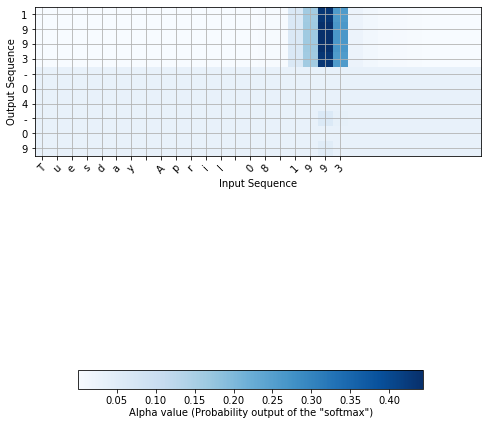

In [19]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday April 08 1993", num = 6, n_s = 128)

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and hasn't much impact on predicting the day/month.

### Congratulations!


You have come to the end of this assignment 

<font color='blue'> **Here's what you should remember from this notebook**:

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.

Congratulations on finishing this assignment! You are now able to implement an attention model and use it to learn complex mappings from one sequence to another. 